# Bluecoats Phase 1: Program Evaluation - Opportunity Discovery
### SCORE Survey PDF Parsing and Unit-level Results
#### Question: Can we use SCORE and similar assessments to identify high opportunity units?
* Yes, there are units and work settings showing obvious struggle.



* Extract SCORE survey summary data from provided pdfs
    * Entity: PPMC
    * Work Settings: all, ER
    * Positions: all, nurse, physician
    * Survey Date: 2020 Dec
    * Benchmarks: percentiles based on "US work settings" in 2020q3

In [1]:
from bluecoats_p1_config import *

import pandas as pd
import numpy as np
from scipy import stats
from jenkspy import JenksNaturalBreaks

import re
import copy
import math
import datetime
from collections import defaultdict

import glob
import os

from pypdf import PdfReader

from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns; 
sns.set()
%matplotlib inline

# Pandas view options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('display.precision', 4)

# Jupyter display options
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

# Program Parameters

### Constants

In [2]:
# SCORE Survey params
NUM_QUESTIONS = 25
BENCHMARK_DATE = '20200901'
SURVEY_DATE = '20201201'

### Collections

In [4]:
question_id = ['q'+str(idx).zfill(2) for idx in range(0,NUM_QUESTIONS)]

question_cat = ['Improvement Readiness','Improvement Readiness',
                'Local Leadership','Local Leadership',
                'Burnout Climate','Personal Burnout','Emotional Thriving',
                'Teamwork','Teamwork','Teamwork',
                'Safety Climate','Safety Climate','Safety Climate',
                'Growth Opportunities','Job Certainty','Decision Making','Advancement','Physical Safety',
                'GME Questions','GME Questions','GME Questions','GME Questions','GME Questions','GME Questions','GME Questions']
question_cat_label = ['Improvement Readiness (defects)','Improvement Readiness (reflect)',
                      'Local Leadership (feedback)','Local Leadership (reflect)',
                      'Burnout Climate','Personal Burnout','Emotional Thriving',
                      'Teamwork (problems)','Teamwork (colleagues)','Teamwork (communication)',
                      'Safety Climate (patient)','Safety Climate (errors)','Safety Climate (values)',
                      'Growth Opportunities','Job Certainty','Decision Making','Advancement','Physical Safety',
                      'GME Questions','GME Questions','GME Questions','GME Questions','GME Questions','GME Questions','GME Questions']
qid_cat_label_dict = {idx:cat_label for idx,cat_label in zip(question_id,question_cat_label)}

question_text = ['In this work setting, the learning environment effectively fixes defects to improve the quality of what we do.', 
                 'In this work setting, the learning environment allows us to pause and reflect on what we do well.', 
                 'In this work setting, local management regularly makes time to provide positive feedback to me about how I am doing.', 
                 'In this work setting, local management regularly makes time to pause and reflect with me about my work.', 
                 'People in this work setting are burned out from their work.', 
                 'I feel burned out from my work.', 
                 'I have a chance to use my strengths every day at work.', 
                 'In this work setting, it is difficult to speak up if I perceive a problem with patient care.', 
                 'Dealing with difficult colleagues is consistently a challenging part of my job.', 
                 'Communication breakdowns are common when this work setting interacts with other work settings.', 
                 'I would feel safe being treated here as a patient.', 
                 'In this work setting, it is difficult to discuss errors.', 
                 'The values of facility leadership are the same values that people in this work setting think are important.', 
                 'With respect to the growth opportunities in this work setting, I have the feeling that I can achieve something.', 
                 'With respect to job-related uncertainty about the future in this work setting, I feel certain that I will keep my current job in the next year.', 
                 'With respect to the participation in decision making that I experience here I have a direct influence on my organization\'s decisions.', 
                 'With respect to advancement in this organization I have opportunities to advance through training courses.', 
                 'I feel safe from crime or violence in my (daily) workspace.',
                 'Faculty in my program participates in educational conferences.',
                 'I feel comfortable speaking up if I am feeling tired while on duty.',
                 'My Program Director is an effective leader.',
                 'I am satisfied with the mentoring I receive.',
                 'The curriculum is of high educational value.',
                 'Faculty in my program are effective teachers.',
                 'I am satisfied with the feedback I have received.']
question_data = [[idx,cat,text] for idx,cat,text in zip(question_id,question_cat,question_text)]

entity_pct_pos = [68.0,65.0,65.0,61.0,19.0,32.0,75.0,68.0,53.0,46.0,81.0,65.0,57.0,66.0,81.0,40.0,62.0,75.0,69.0,25.0,64.0,51.0,66.0,76.0,46]
entity_percentile = [56.0,43.0,54.0,49.0,12.0,4.0,np.nan,68.0,78.0,85.0,83.0,76.0,59.0,23.0,87.0,79.0,99.0,
                  np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
entity_data = [[pct_pos,percentile] for pct_pos,percentile in zip(entity_pct_pos,entity_percentile)]

In [5]:
# Labeling
leadership_keywords = ['leadership','manager','director','administration']

# Class Definitions

# Function Definitions

In [7]:
def parse_outcome(outcome):
    outcome_pct_pos = outcome[0]
    outcome_percentile = outcome[1]
    raw_outcomes = [outcome_pct_pos,outcome_percentile]
    outcome_update = []
    
    for item in raw_outcomes:
        if '--' in item:
            outcome_update.append(np.nan)
        else:
            outcome_update.append(float(item[:-len(item.lstrip('0123456789'))]))
            
    return outcome_update

In [8]:
def set_cg_yticklabels(a, bold_leadership=False):
    yticklabels = a.ax_heatmap.get_yticklabels()
    for item in yticklabels:
        text = item.get_text()
        word_list = text.split('-')
        item.set_text(ws_labels_dict[text])
        if bold_leadership:
            if not set(word_list).isdisjoint(leadership_keywords):
                item.set_fontweight('bold')
    return yticklabels

In [9]:
def save_figure(fig, path, filename, transparent=True):
    if transparent:
        filename = filename + 'clear_'
    name = path + filename + str(datetime.datetime.now().date()).replace('-','') + '.png'
    fig.savefig(name, bbox_inches='tight', pad_inches=0, dpi=SAVE_DPI, transparent=transparent)

# Read Data

In [11]:
master_data = []
master_data_dict = {}
master_data_cols = ['question_id','question_category','question_text','entity_pct_pos','entity_percentile',
                    'group_pct_pos','group_percentile','num_respondents','survey_name','survey_date',
                    'entity','work_setting','position','report_type','benchmark_date']

for path in glob.glob(RAW_SCORE_PATH + '*.pdf'):
    file_name = path.split('/')[-1].split('.')[0]
    file_meta = file_name.split('_')
    print(file_name)
    
    survey_name = file_meta[0]
    survey_date = file_meta[5]
    entity = file_meta[1]
    work_setting = file_meta[2]
    position = file_meta[3]
    report_type = file_meta[4]
    benchmark_date = BENCHMARK_DATE
        
    # Parse summary reports
    if report_type=='summary':
        # Set indices for summary reports
        page_start_idx = 1
        page_end_idx = 4
        
        raw_pages = [page.extract_text() for page in PdfReader(path).pages[page_start_idx:page_end_idx]]
        raw_pages_data = ' '.join(raw_pages).replace('\n',' ')
        num_respondents = float(raw_pages[0].split('\n')[1].split()[0].replace(',',''))
        
        # Define report metadata
        meta_data = [num_respondents,survey_name,survey_date,
                     entity,work_setting,position,report_type,benchmark_date]
        
        # Get group outcome_data
        outcome_data = []
        temp_data=raw_pages_data
        for question in question_text:
            temp_split = temp_data.split(question)
            if '%' in temp_split[1]:
                outcome = temp_split[1].split()
                outcome_update = parse_outcome(outcome)
                outcome_data.append(outcome_update)
            temp_data=temp_split[1]
        
        report_data = [question+entity_outcome+group_outcome+meta_data for question,entity_outcome,group_outcome in 
                       zip(question_data,entity_data,outcome_data)]
    
        report_key = '_'.join([entity,work_setting,position])
        master_data_dict[report_key] = report_data
        master_data.append(report_data)
    
master_data_flat = [item for report in master_data for item in report]

score_PPMC_er-staff_all_summary_20201201
score_PPMC_trauma-administration_all_summary_20201201
score_PPMC_periop-cardiology-vascular_all_summary_20201201
score_PPMC_ace-unit_all_summary_20201201
score_PPMC_all_technologist-surg-lab-rag_summary_20201201
score_PPMC_radiology_all_summary_20201201
score_PPMC_pac4-tsicu_nurse_summary_20201201
score_PPMC_cupp-pavilion-4-east_all_summary_20201201
score_PPMC_or-periop-endoscopy_all_summary_20201201
score_PPMC_all_all_results_20201201
score_PPMC_all_physician-resident-fellow-attending_summary_20201201
score_PPMC_all_all_summary_20201201
score_PPMC_cupp-pavilion-3-east_nurse_summary_20201201
score_PPMC_lab-bloodBank-pathology_all_summary_20201201
score_PPMC_all_other-manager-clinic-manager-supervisor_summary_20201201
score_PPMC_interventional-radiology_all_summary_20201201
score_PPMC_ceqi_all_summary_20201201
score_PPMC_operations-leadership_all_summary_20201201
score_PPMC_med-icu_all_summary_20201201
score_PPMC_all_other_summary_20201201
score_

# Display Data and Save

## Master Data

In [12]:
score_master = pd.DataFrame(master_data_flat, columns=master_data_cols)
score_master['group_entity_pct_pos_diff']=score_master['group_pct_pos']-score_master['entity_pct_pos']

save_name = MASTER_DATA_PATH + 'score_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
score_master.to_csv(save_name)

In [13]:
print(len(score_master))
print(len(score_master.columns))
score_master.head(2)

2600
16


question_id      question_category  \
0         q00  Improvement Readiness   
1         q01  Improvement Readiness   

                                       question_text  entity_pct_pos  \
0  In this work setting, the learning environment...            68.0   
1  In this work setting, the learning environment...            65.0   

   entity_percentile  group_pct_pos  group_percentile  num_respondents  \
0               56.0           51.0              19.0             57.0   
1               43.0           36.0               7.0             57.0   

  survey_name survey_date entity work_setting position report_type  \
0       score    20201201   PPMC     er-staff      all     summary   
1       score    20201201   PPMC     er-staff      all     summary   

  benchmark_date  group_entity_pct_pos_diff  
0       20200901                      -17.0  
1       20200901                      -29.0

In [15]:
score_master.work_setting.unique().tolist()

['er-staff',
 'trauma-administration',
 'periop-cardiology-vascular',
 'ace-unit',
 'all',
 'radiology',
 'pac4-tsicu',
 'cupp-pavilion-4-east',
 'or-periop-endoscopy',
 'cupp-pavilion-3-east',
 'lab-bloodBank-pathology',
 'interventional-radiology',
 'ceqi',
 'operations-leadership',
 'med-icu',
 'other',
 'pastoral-care',
 'cupp-pavilion-3-south',
 'cath-ep-lab',
 'cupp-pavilion-5-south',
 'periop-general',
 'cupp-pavilion-5-east',
 'cupp-pavilion-4-south',
 'case-management',
 'business-operactions',
 'psych-units-behavioral-health',
 'cardiovascular-nurse-manager',
 'penn-cardiology',
 'accounting',
 'neuro-icu-pac5',
 'cherry-hill-infusion',
 'senior-leadership-team',
 'registration-access',
 'pharmacy-leadership',
 'social-work',
 'hematology-oncology-infusion',
 'pac3-hvicu',
 'observation',
 'cardiac-catheterization',
 'periop-cardiology-vascular-general',
 'patient-progression',
 'patient-guest-services',
 'respiratory-therapy',
 'phlebotomy',
 'heart-vascular',
 'ed-psych-med

### Unique Groups
* Groups are unique combinations of [entity, work_setting, position]

In [13]:
groups = score_master[['num_respondents','entity','work_setting','position']].drop_duplicates()

In [14]:
print(len(groups))
print(len(groups.columns))
groups.head(5)

104
4


num_respondents entity                work_setting  \
0               57.0   PPMC                    er-staff   
25              13.0   PPMC       trauma-administration   
50              24.0   PPMC  periop-cardiology-vascular   
75              36.0   PPMC                    ace-unit   
100             73.0   PPMC                         all   

                      position  
0                          all  
25                         all  
50                         all  
75                         all  
100  technologist-surg-lab-rag

## Work Setting Master Data

In [15]:
score_work_settings = score_master[score_master['position']=='all'].copy()

save_name = MASTER_DATA_PATH + 'score_work_settings_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
score_work_settings.to_csv(save_name)

In [16]:
print(len(score_work_settings))
print(len(score_work_settings.columns))
score_work_settings.head(2)

1400
16


question_id      question_category  \
0         q00  Improvement Readiness   
1         q01  Improvement Readiness   

                                       question_text  entity_pct_pos  \
0  In this work setting, the learning environment...            68.0   
1  In this work setting, the learning environment...            65.0   

   entity_percentile  group_pct_pos  group_percentile  num_respondents  \
0               56.0           51.0              19.0             57.0   
1               43.0           36.0               7.0             57.0   

  survey_name survey_date entity work_setting position report_type  \
0       score    20201201   PPMC     er-staff      all     summary   
1       score    20201201   PPMC     er-staff      all     summary   

  benchmark_date  group_entity_pct_pos_diff  
0       20200901                      -17.0  
1       20200901                      -29.0

## Position Master Data

In [17]:
score_positions = score_master[score_master['work_setting']=='all'].copy()

save_name = MASTER_DATA_PATH + 'score_positions_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
score_positions.to_csv(save_name)

In [18]:
print(len(score_positions))
print(len(score_positions.columns))
score_positions.head(2)

575
16


question_id      question_category  \
100         q00  Improvement Readiness   
101         q01  Improvement Readiness   

                                         question_text  entity_pct_pos  \
100  In this work setting, the learning environment...            68.0   
101  In this work setting, the learning environment...            65.0   

     entity_percentile  group_pct_pos  group_percentile  num_respondents  \
100               56.0           64.0              42.0             73.0   
101               43.0           62.0              35.0             73.0   

    survey_name survey_date entity work_setting                   position  \
100       score    20201201   PPMC          all  technologist-surg-lab-rag   
101       score    20201201   PPMC          all  technologist-surg-lab-rag   

    report_type benchmark_date  group_entity_pct_pos_diff  
100     summary       20200901                       -4.0  
101     summary       20200901                       -3.0

## Nurse Master Data

In [19]:
score_nurses = score_master[score_master['position']=='nurse'].copy()

save_name = MASTER_DATA_PATH + 'score_nurses_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
score_nurses.to_csv(save_name)

In [20]:
print(len(score_nurses))
print(len(score_nurses.columns))
score_nurses.head(2)

625
16


question_id      question_category  \
150         q00  Improvement Readiness   
151         q01  Improvement Readiness   

                                         question_text  entity_pct_pos  \
150  In this work setting, the learning environment...            68.0   
151  In this work setting, the learning environment...            65.0   

     entity_percentile  group_pct_pos  group_percentile  num_respondents  \
150               56.0           75.0              58.0             46.0   
151               43.0           75.0              61.0             46.0   

    survey_name survey_date entity work_setting position report_type  \
150       score    20201201   PPMC   pac4-tsicu    nurse     summary   
151       score    20201201   PPMC   pac4-tsicu    nurse     summary   

    benchmark_date  group_entity_pct_pos_diff  
150       20200901                        7.0  
151       20200901                       10.0

## ER Master Data

In [21]:
score_er = score_master[score_master['work_setting']=='er-staff'].copy()

save_name = MASTER_DATA_PATH + 'score_er_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
score_er.to_csv(save_name)

In [22]:
print(len(score_er))
print(len(score_er.columns))
score_er.head(2)

100
16


question_id      question_category  \
0         q00  Improvement Readiness   
1         q01  Improvement Readiness   

                                       question_text  entity_pct_pos  \
0  In this work setting, the learning environment...            68.0   
1  In this work setting, the learning environment...            65.0   

   entity_percentile  group_pct_pos  group_percentile  num_respondents  \
0               56.0           51.0              19.0             57.0   
1               43.0           36.0               7.0             57.0   

  survey_name survey_date entity work_setting position report_type  \
0       score    20201201   PPMC     er-staff      all     summary   
1       score    20201201   PPMC     er-staff      all     summary   

  benchmark_date  group_entity_pct_pos_diff  
0       20200901                      -17.0  
1       20200901                      -29.0

# Data Exploration
* Remove GME questions
* Remove "all" designation for work setting / position as needed to avoid double counting
* Do no combine [work setting A, all positions], with [work setting A, position 1] or similar - this will double count

In [23]:
pd_idx = pd.IndexSlice

ws_respondents_dict = dict(score_master[score_master['position']=='all'][['work_setting','num_respondents']].drop_duplicates().values)
pos_respondents_dict = dict(score_master[score_master['work_setting']=='all'][['position','num_respondents']].drop_duplicates().values)

## Work Settings

In [24]:
# Dictionary for labeling
ws_labels_dict = dict()
for text in ws_respondents_dict.keys():
    clean_label = ' '.join([word.capitalize() for word in text.split('-')])
    resp_label = ' (' + str(ws_respondents_dict[text]) + ')'
    label = clean_label + resp_label
    ws_labels_dict[text]=label

In [25]:
use_cols = ['num_respondents','group_pct_pos','entity_pct_pos','group_entity_pct_pos_diff']
score_ws_grouped = score_work_settings[score_work_settings['question_category']!='GME Questions'].groupby(['work_setting']).mean()[use_cols]
score_ws_grouped_sorted = score_ws_grouped.sort_values('group_entity_pct_pos_diff')

In [26]:
score_ws_grouped.head()

num_respondents  group_pct_pos  entity_pct_pos  \
work_setting                                                           
accounting                        8.0        66.1875         59.9444   
ace-unit                         36.0        56.1667         59.9444   
all                            1473.0        59.9444         59.9444   
anesthesiology-tech               8.0        79.0556         59.9444   
business-operactions              9.0        61.7222         59.9444   

                      group_entity_pct_pos_diff  
work_setting                                     
accounting                               7.6875  
ace-unit                                -3.7778  
all                                      0.0000  
anesthesiology-tech                     19.1111  
business-operactions                     1.7778

In [27]:
score_ws_grouped_sorted.head()

num_respondents  group_pct_pos  \
work_setting                                                         
respiratory-therapy                            25.0        31.0556   
er-staff                                       57.0        38.3889   
cupp-pavilion-4-south                          44.0        42.7222   
periop-cardiology-vascular-general              9.0        43.9444   
trauma-psych-billing-leadership                 5.0        46.6667   

                                    entity_pct_pos  group_entity_pct_pos_diff  
work_setting                                                                   
respiratory-therapy                        59.9444                   -28.8889  
er-staff                                   59.9444                   -21.5556  
cupp-pavilion-4-south                      59.9444                   -17.2222  
periop-cardiology-vascular-general         59.9444                   -16.0000  
trauma-psych-billing-leadership            59.9444                   -13.2778

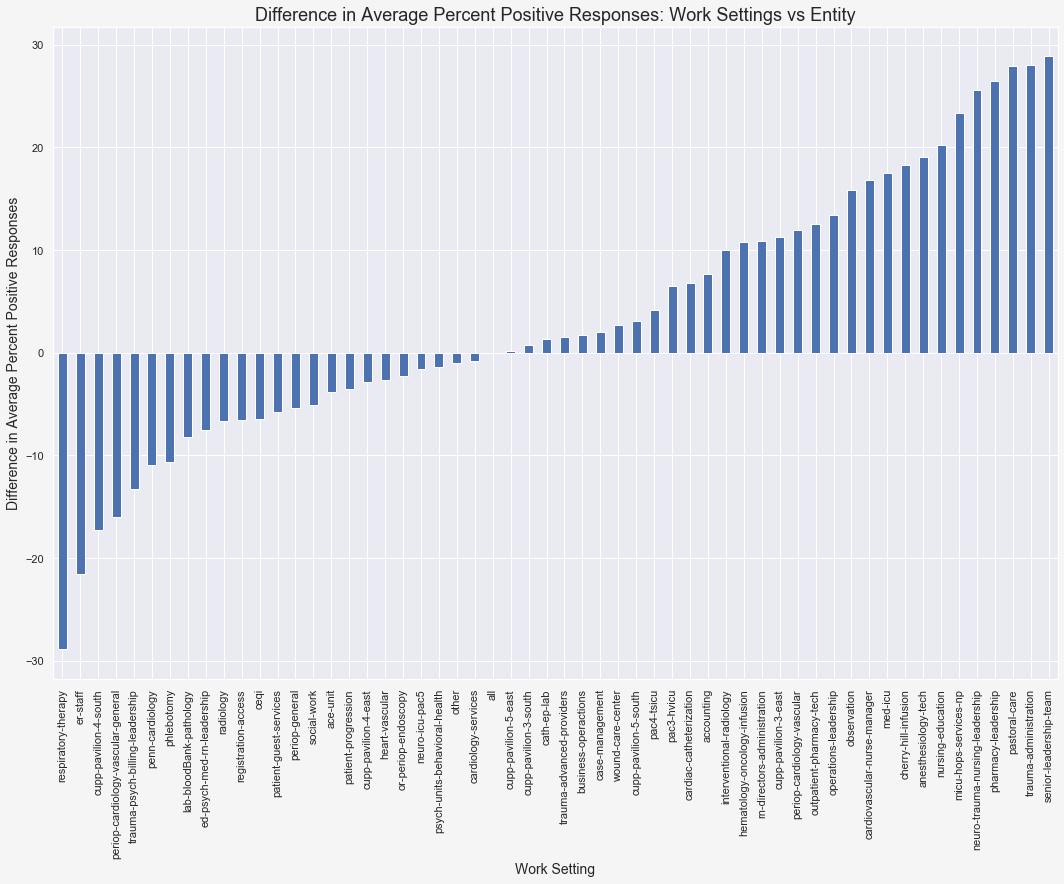

In [28]:
fig, ax = plt.subplots(figsize=(18,12), facecolor='whitesmoke')
plt.grid(False)
score_ws_grouped_sorted['group_entity_pct_pos_diff'].plot(ax=ax, kind='bar')
ax.set_title('Difference in Average Percent Positive Responses: Work Settings vs Entity', fontsize=18)
ax.set_xlabel('Work Setting', fontsize=14)
ax.set_ylabel('Difference in Average Percent Positive Responses', fontsize=14)

save_figure(fig,FIGURE_PATH,'score_ws_pct_pos_')

### Work Setting: Question Category and Question ID

In [29]:
score_ws_qc_data = score_work_settings[score_work_settings['question_category']!='GME Questions']
score_ws_qc_data_grouped = score_ws_qc_data.groupby(['work_setting','question_category']).mean()['group_entity_pct_pos_diff'].unstack()
score_ws_qid_data_grouped = score_ws_qc_data.groupby(['work_setting','question_id']).mean()['group_entity_pct_pos_diff'].unstack()
score_ws_qid_data_grouped.columns = [col+' '+qid_cat_label_dict[col] for col in score_ws_qid_data_grouped.columns]

In [30]:
print(len(score_ws_qc_data_grouped))
print(len(score_ws_qc_data_grouped.columns))
score_ws_qc_data_grouped.head()

56
12


question_category     Advancement  Burnout Climate  Decision Making  \
work_setting                                                          
accounting                  -29.0             18.0             17.0   
ace-unit                     14.0             -2.0             -1.0   
all                           0.0              0.0              0.0   
anesthesiology-tech          26.0              5.0             10.0   
business-operactions        -19.0              4.0            -27.0   

question_category     Emotional Thriving  Growth Opportunities  \
work_setting                                                     
accounting                         -37.0                 -28.0   
ace-unit                            -8.0                  -8.0   
all                                  0.0                   0.0   
anesthesiology-tech                 13.0                   9.0   
business-operactions                 3.0                 -10.0   

question_category     Improvement Readiness  Job Certainty  Local Leadership  \
work_setting                                                                   
accounting                              6.5          -14.0              30.0   
ace-unit                               -5.0          -13.0              -1.5   
all                                     0.0            0.0               0.0   
anesthesiology-tech                    19.5           19.0              31.0   
business-operactions                    6.0            5.0              15.0   

question_category     Personal Burnout  Physical Safety  Safety Climate  \
work_setting                                                              
accounting                         5.0              NaN         28.3333   
ace-unit                          -7.0              0.0         -9.0000   
all                                0.0              0.0          0.0000   
anesthesiology-tech               30.0             25.0         16.0000   
business-operactions               2.0              8.0          9.0000   

question_category     Teamwork  
work_setting                    
accounting             16.5000  
ace-unit               -1.0000  
all                     0.0000  
anesthesiology-tech    19.3333  
business-operactions   -1.0000

In [31]:
print(len(score_ws_qid_data_grouped))
print(len(score_ws_qid_data_grouped.columns))
score_ws_qid_data_grouped.head()

56
18


q00 Improvement Readiness (defects)  \
work_setting                                                
accounting                                            7.0   
ace-unit                                             -4.0   
all                                                   0.0   
anesthesiology-tech                                  18.0   
business-operactions                                 10.0   

                      q01 Improvement Readiness (reflect)  \
work_setting                                                
accounting                                            6.0   
ace-unit                                             -6.0   
all                                                   0.0   
anesthesiology-tech                                  21.0   
business-operactions                                  2.0   

                      q02 Local Leadership (feedback)  \
work_setting                                            
accounting                                       21.0   
ace-unit                                         -7.0   
all                                               0.0   
anesthesiology-tech                              35.0   
business-operactions                             13.0   

                      q03 Local Leadership (reflect)  q04 Burnout Climate  \
work_setting                                                                
accounting                                      39.0                 18.0   
ace-unit                                         4.0                 -2.0   
all                                              0.0                  0.0   
anesthesiology-tech                             27.0                  5.0   
business-operactions                            17.0                  4.0   

                      q05 Personal Burnout  q06 Emotional Thriving  \
work_setting                                                         
accounting                             5.0                   -37.0   
ace-unit                              -7.0                    -8.0   
all                                    0.0                     0.0   
anesthesiology-tech                   30.0                    13.0   
business-operactions                   2.0                     3.0   

                      q07 Teamwork (problems)  q08 Teamwork (colleagues)  \
work_setting                                                               
accounting                                NaN                       22.0   
ace-unit                                  1.0                        3.0   
all                                       0.0                        0.0   
anesthesiology-tech                      32.0                       -3.0   
business-operactions                      3.0                       -3.0   

                      q09 Teamwork (communication)  \
work_setting                                         
accounting                                    11.0   
ace-unit                                      -7.0   
all                                            0.0   
anesthesiology-tech                           29.0   
business-operactions                          -3.0   

                      q10 Safety Climate (patient)  \
work_setting                                         
accounting                                    19.0   
ace-unit                                     -25.0   
all                                            0.0   
anesthesiology-tech                           19.0   
business-operactions                          19.0   

                      q11 Safety Climate (errors)  \
work_setting                                        
accounting                                   23.0   
ace-unit                                     -1.0   
all                                           0.0   
anesthesiology-tech                          23.0   
business-operactions                          2.0   

                      q12 Safety Climate (values)  q13 Growth Opportunit

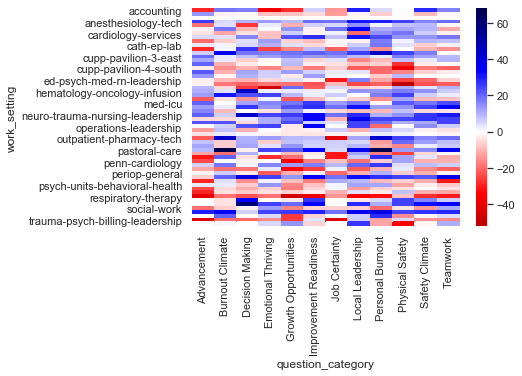

In [32]:
a = sns.heatmap(score_ws_qc_data_grouped.fillna(0),annot=False,cmap='seismic_r',center=0)

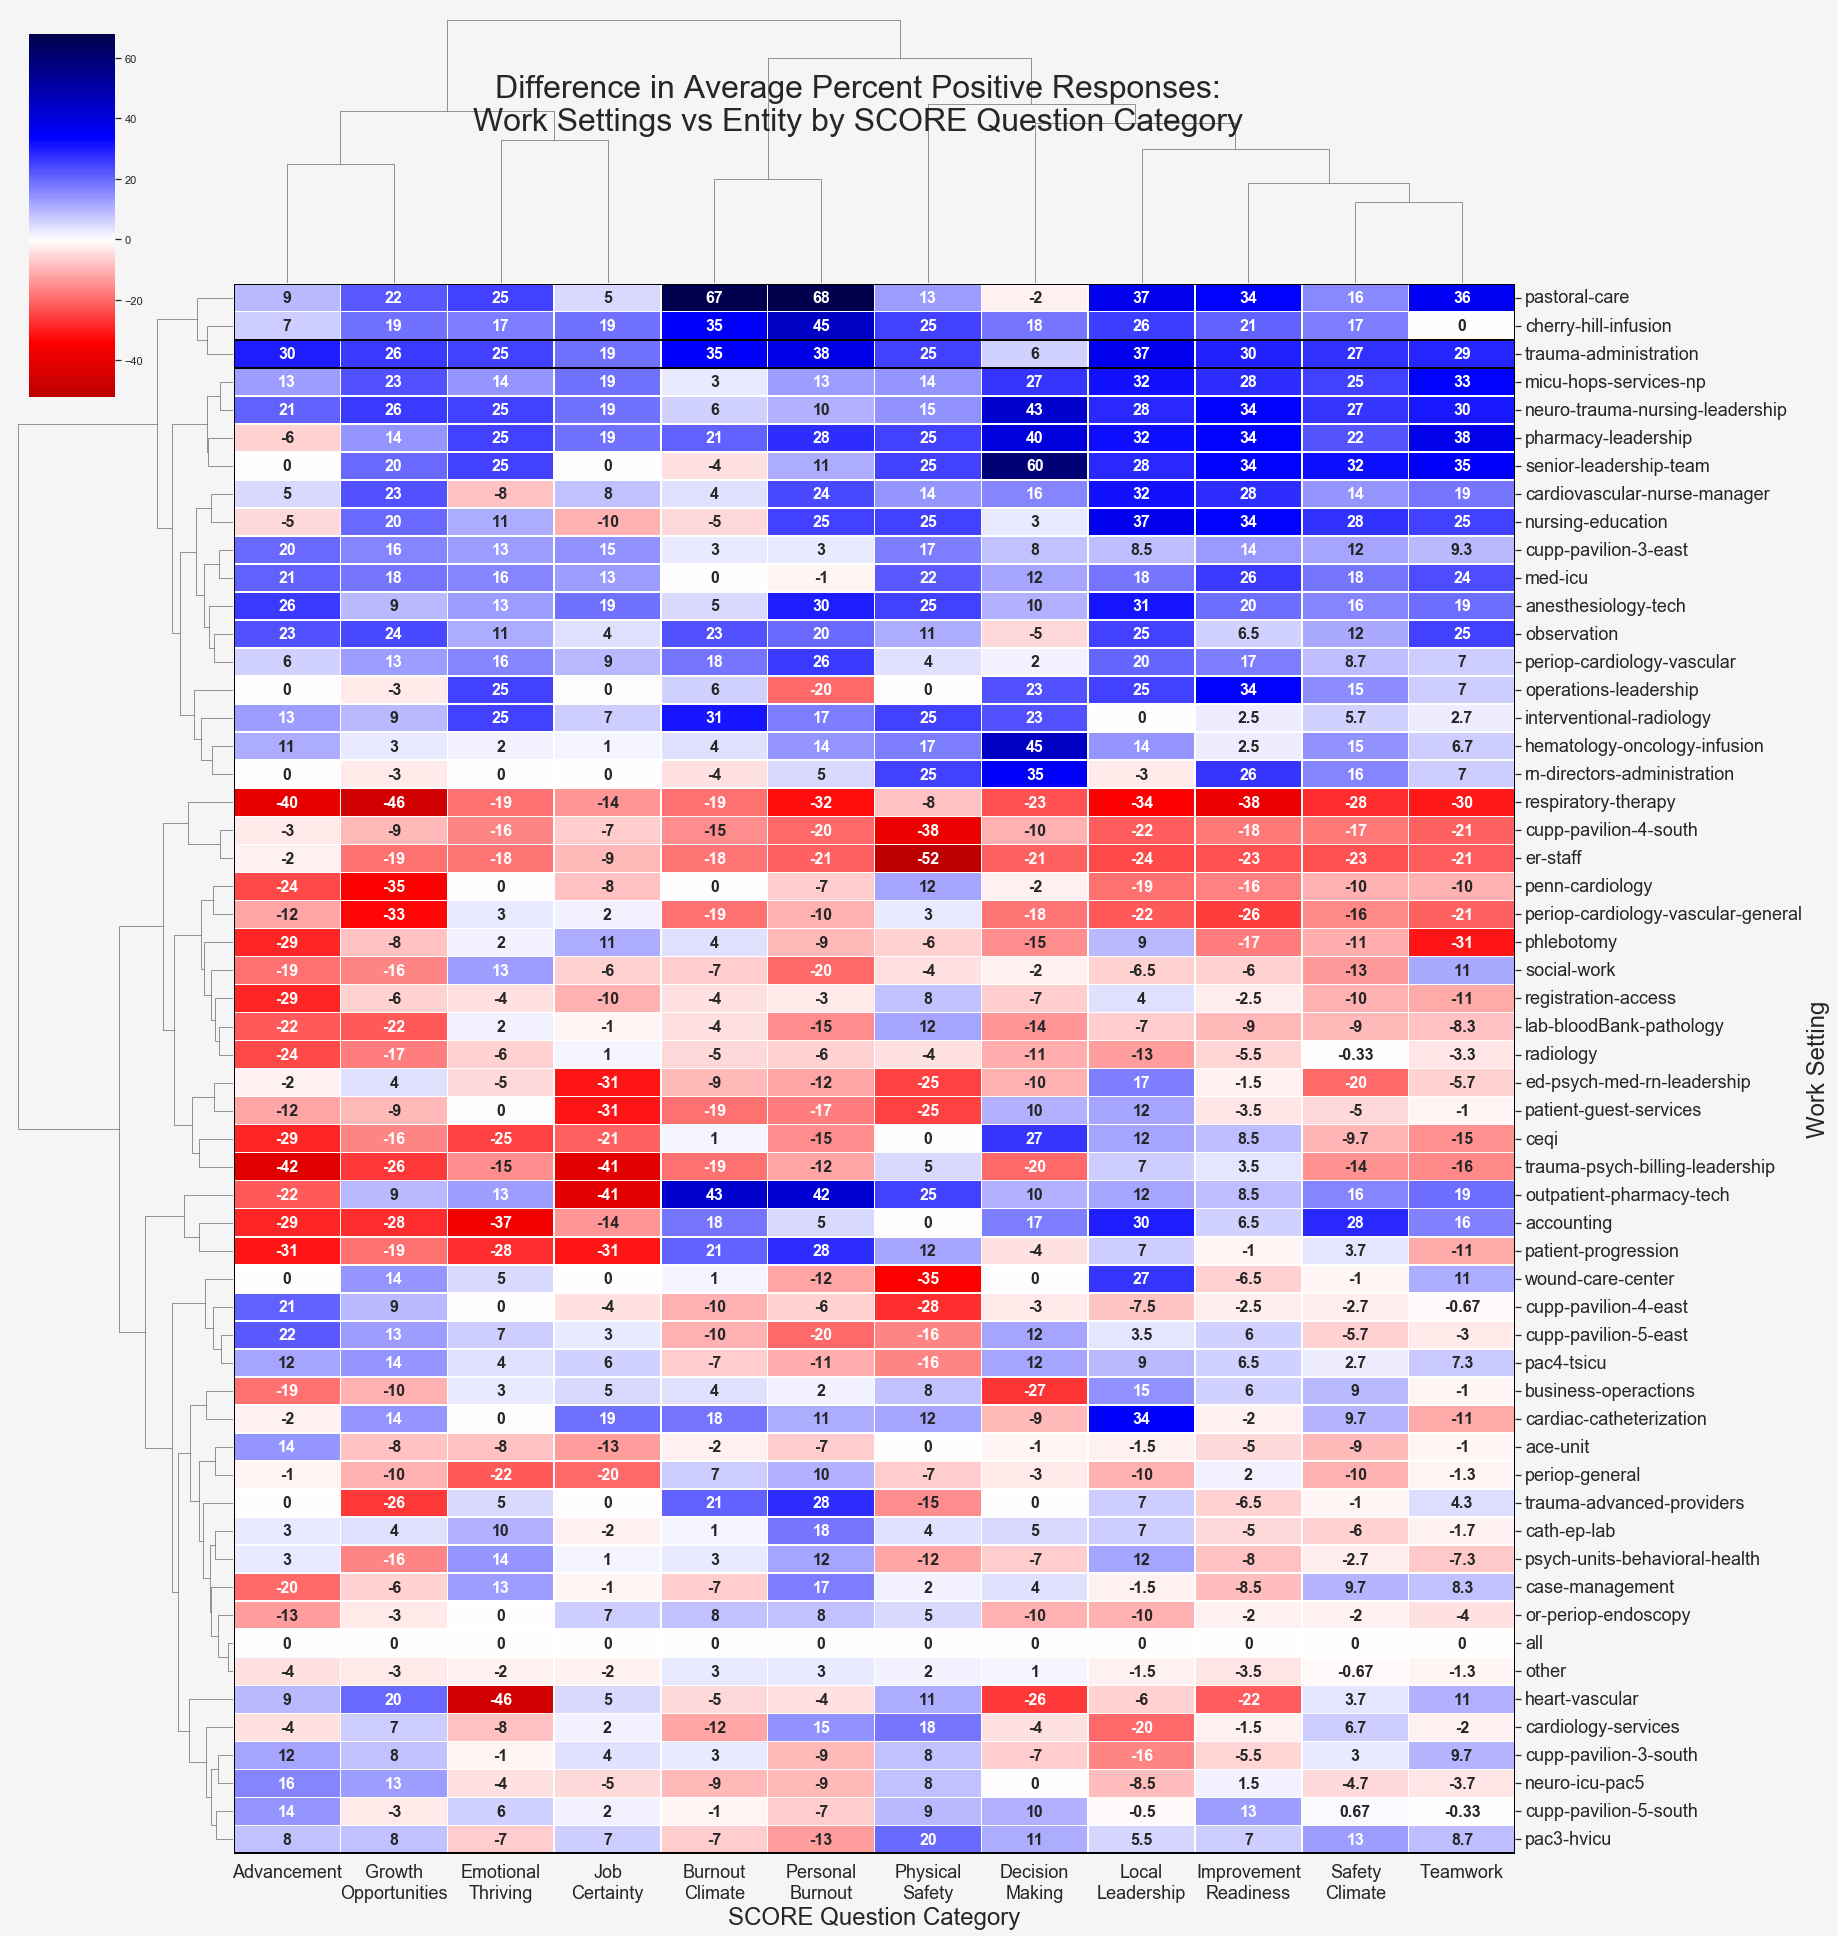

In [33]:
sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'whitesmoke'})

data = score_ws_qc_data_grouped.fillna(0)
a = sns.clustermap(data,method='ward',figsize=(24,28),annot=True,annot_kws={'fontsize':16,'weight':'bold'},
                   cmap='seismic_r',center=0,dendrogram_ratio=[0.15,0.15],lw=0.5)

#labels
title = 'Difference in Average Percent Positive Responses:\nWork Settings vs Entity by SCORE Question Category'
a.fig.suptitle(title, x=0.5, y=0.96, fontsize=32)
a.ax_heatmap.set_xlabel('SCORE Question Category', fontsize=24)
a.ax_heatmap.set_ylabel('Work Setting', fontsize=24)

# tick labels
xticklabels = ['\n'.join(item.get_text().split()) for item in a.ax_heatmap.get_xticklabels()]
yticklabels = a.ax_heatmap.get_yticklabels()
a.ax_heatmap.set_xticklabels(xticklabels, rotation=0, ha='center', fontsize=18)
a.ax_heatmap.set_yticklabels(yticklabels, rotation=0, va='center', fontsize=18)

# bounding boxes
ax = a.ax_heatmap
ax.add_patch(Rectangle((0, 0), len(data.columns), len(data), fill=False, edgecolor='black', lw=2))
ax.add_patch(Rectangle((0, 2), len(data.columns), 1, fill=False, edgecolor='black', lw=2))

#save_figure(a.fig,FIGURE_PATH,'score_ws_qc_pct_pos_')

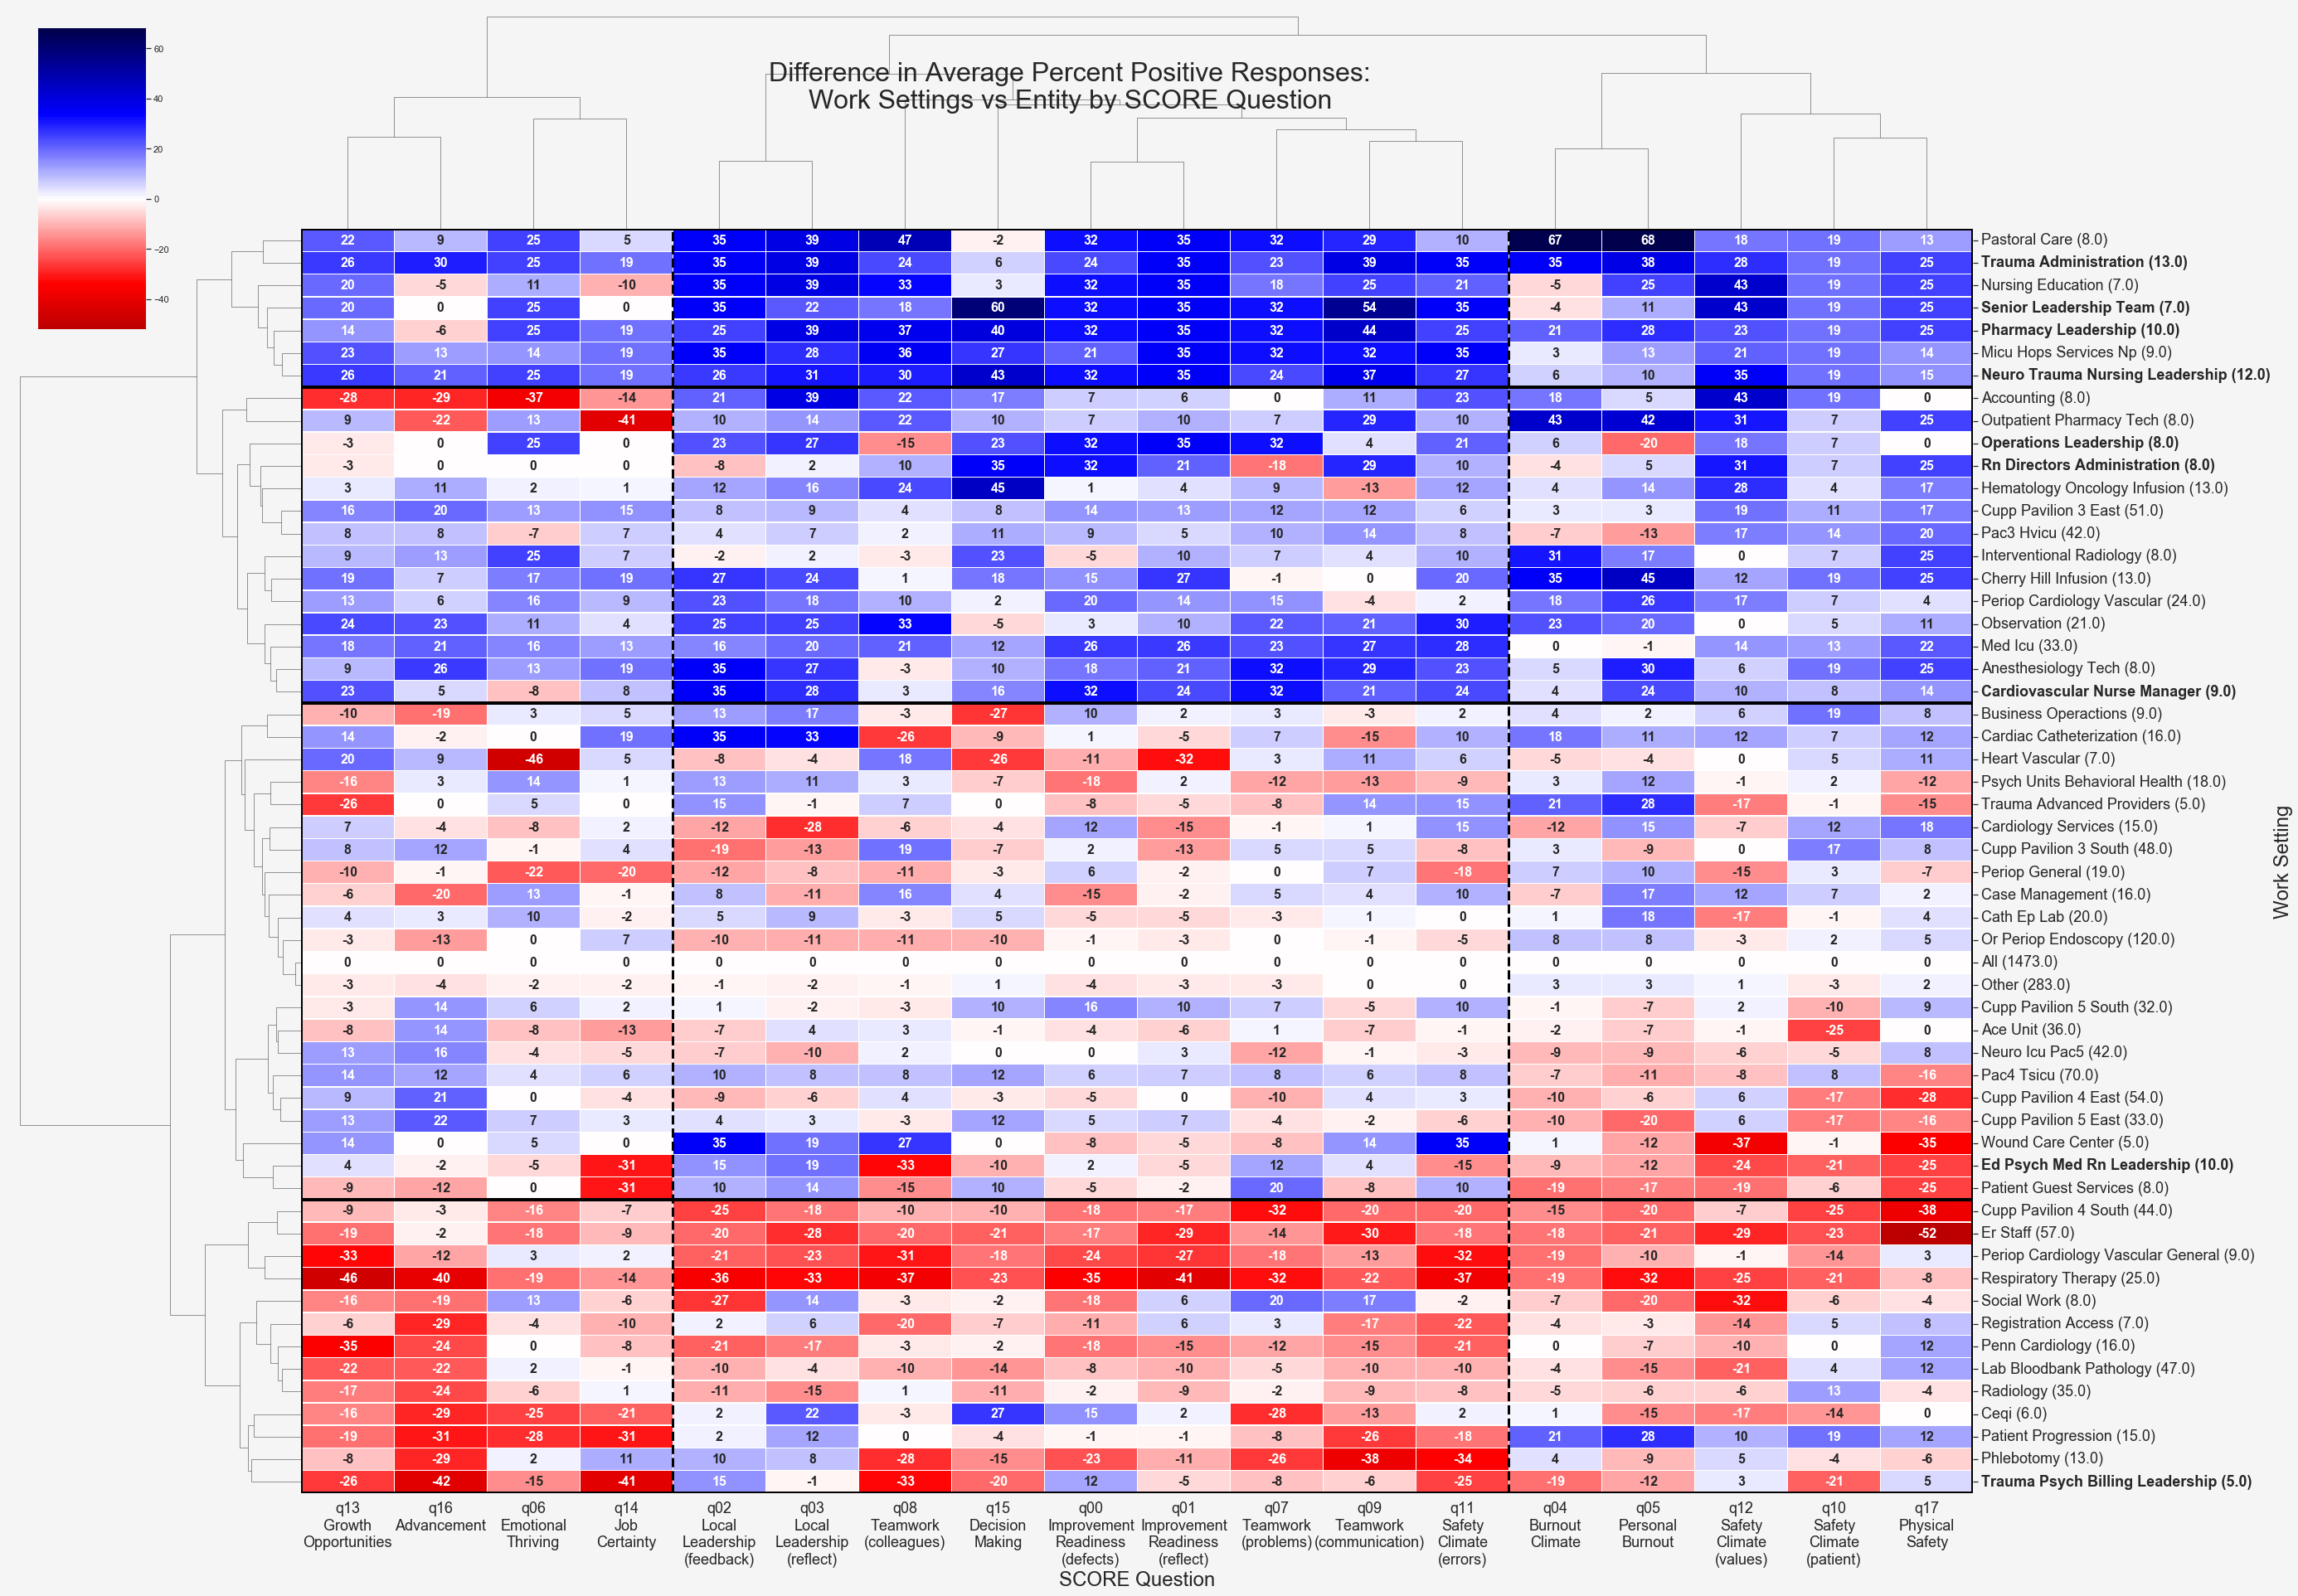

In [34]:
sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'whitesmoke'})

data = score_ws_qid_data_grouped.fillna(0)
a = sns.clustermap(data,method='ward',figsize=(36,28),annot=True,annot_kws={'fontsize':16,'weight':'bold'},
                   cmap='seismic_r',center=0,dendrogram_ratio=[0.15,0.15],lw=0.5)

# labels
title = 'Difference in Average Percent Positive Responses:\nWork Settings vs Entity by SCORE Question'
a.fig.suptitle(title, x=0.5, y=0.96, fontsize=32)
a.ax_heatmap.set_xlabel('SCORE Question', fontsize=24)
a.ax_heatmap.set_ylabel('Work Setting', fontsize=24)

# tick labels
xticklabels = ['\n'.join(item.get_text().split()) for item in a.ax_heatmap.get_xticklabels()]
a.ax_heatmap.set_xticklabels(xticklabels, rotation=0, ha='center', fontsize=18)

yticklabels = set_cg_yticklabels(a,bold_leadership=True)
a.ax_heatmap.set_yticklabels(yticklabels, rotation=0, va='center', fontsize=18)

# bounding boxes
ax = a.ax_heatmap
ax.add_patch(Rectangle((0, 0), len(data.columns), len(data), fill=False, edgecolor='black', lw=4))

# TEMP LINES
#ax.axhline(2, color='black', lw=3, ls='--')
ax.axhline(7, color='black', lw=4)
#ax.axhline(9, color='black', lw=3, ls='--')
ax.axhline(21, color='black', lw=4)
#ax.axhline(34, color='black', lw=3, ls='--')
ax.axhline(43, color='black', lw=4)
#ax.axhline(47, color='black', lw=3, ls='--')

ax.axvline(4, color='black', lw=3, ls='--')
ax.axvline(13, color='black', lw=3, ls='--')

save_figure(a.fig,FIGURE_PATH,'score_ws_qid_pct_pos_',transparent=False)

In [35]:
# Can create custom groups via list of codes [RRL,LLR,RRRL, etc.]
# Can create groups based on number of common ancestors (if two, groups are codes starting with RR,RL,LL,LR)

In [67]:
# to automate bounding boxes for specific rows/cols (work settings / question categories)
yticklabels = a.ax_heatmap.get_yticklabels()
[i for i in range(len(yticklabels)) if yticklabels[i].get_text()=='er-staff']

[44]

In [37]:
#### NOTE 2023/03/14 make score_ws_meta.csv from appendix - show plot below with denom info
#### NOTE 2023/03/14 use bounding boxes to show dendrogram "groups of interest" and then hide the dendrograms
#### Also label the colorbar
#### attach bar graph to left side showing num respondents (and possibly the denom)

In [38]:
# 2023/03/09
# Question1 (for me): Can I use the dengrogram structure to simplify the output and find relevant clusters of...
# work settings, positions, question categories, and questions?
# Yes, but how much work/time and how much value added?
# Question 2 (for me): should I consider custom groupers, such as leadership/non-leadership, clinical/non-clinical...
# similar to previous cobalt work on appointments and provider types
# Yes, this seems easy, but unclear value added until implementation --> do this first

In [219]:
data.index[a.dendrogram_row.reordered_ind].tolist()

['phlebotomy',
 'cupp-pavilion-4-south',
 'er-staff',
 'periop-cardiology-vascular-general',
 'respiratory-therapy',
 'wound-care-center',
 'trauma-psych-billing-leadership',
 'ceqi',
 'patient-progression',
 'heart-vascular',
 'social-work',
 'ed-psych-med-rn-leadership',
 'patient-guest-services',
 'business-operactions',
 'cardiac-catheterization',
 'periop-general',
 'registration-access',
 'penn-cardiology',
 'lab-bloodBank-pathology',
 'radiology',
 'case-management',
 'psych-units-behavioral-health',
 'trauma-advanced-providers',
 'cath-ep-lab',
 'or-periop-endoscopy',
 'all',
 'other',
 'cupp-pavilion-5-south',
 'ace-unit',
 'neuro-icu-pac5',
 'pac4-tsicu',
 'cupp-pavilion-4-east',
 'cupp-pavilion-5-east',
 'cardiology-services',
 'cupp-pavilion-3-south',
 'pastoral-care',
 'nursing-education',
 'trauma-administration',
 'senior-leadership-team',
 'pharmacy-leadership',
 'micu-hops-services-np',
 'neuro-trauma-nursing-leadership',
 'operations-leadership',
 'interventional-radi

In [92]:
data.columns[a.dendrogram_col.reordered_ind]

Index(['q06 Emotional Thriving', 'q14 Job Certainty',
       'q13 Growth Opportunities', 'q16 Advancement', 'q04 Burnout Climate',
       'q05 Personal Burnout', 'q08 Teamwork (colleagues)',
       'q12 Safety Climate (values)', 'q10 Safety Climate (patient)',
       'q17 Physical Safety', 'q15 Decision Making',
       'q02 Local Leadership (feedback)', 'q03 Local Leadership (reflect)',
       'q09 Teamwork (communication)', 'q11 Safety Climate (errors)',
       'q07 Teamwork (problems)', 'q00 Improvement Readiness (defects)',
       'q01 Improvement Readiness (reflect)'],
      dtype='object')

In [32]:
a.dendrogram_row.dendrogram.keys()

dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list', 'leaves_color_list'])

In [163]:
cluster_idx_coords = [[item[0],item[-1]] for item in a.dendrogram_row.dendrogram['icoord']]
cluster_dist_coords = a.dendrogram_row.dendrogram['dcoord']
cluster_idx_coords

[[15.0, 25.0],
 [35.0, 45.0],
 [20.0, 40.0],
 [5.0, 30.0],
 [75.0, 85.0],
 [65.0, 80.0],
 [115.0, 125.0],
 [105.0, 120.0],
 [135.0, 145.0],
 [185.0, 195.0],
 [175.0, 190.0],
 [165.0, 182.5],
 [155.0, 173.75],
 [215.0, 225.0],
 [205.0, 220.0],
 [255.0, 265.0],
 [245.0, 260.0],
 [235.0, 252.5],
 [285.0, 295.0],
 [275.0, 290.0],
 [243.75, 282.5],
 [315.0, 325.0],
 [305.0, 320.0],
 [263.125, 312.5],
 [335.0, 345.0],
 [287.8125, 340.0],
 [212.5, 313.90625],
 [164.375, 263.203125],
 [140.0, 213.7890625],
 [112.5, 176.89453125],
 [95.0, 144.697265625],
 [72.5, 119.8486328125],
 [55.0, 96.17431640625],
 [17.5, 75.587158203125],
 [405.0, 415.0],
 [395.0, 410.0],
 [385.0, 402.5],
 [375.0, 393.75],
 [365.0, 384.375],
 [445.0, 455.0],
 [435.0, 450.0],
 [475.0, 485.0],
 [465.0, 480.0],
 [505.0, 515.0],
 [495.0, 510.0],
 [472.5, 502.5],
 [442.5, 487.5],
 [525.0, 535.0],
 [465.0, 530.0],
 [425.0, 497.5],
 [374.6875, 461.25],
 [545.0, 555.0],
 [417.96875, 550.0],
 [355.0, 483.984375],
 [46.54357910156

In [ ]:
leaves = []
for cluster in cluster_idx_coords:
    midpoint = sum(cluster)/len(cluster)
    for val in cluster:
        if is_leaf(val):
            idx = (int(val)-5)//10
            code = get_code(val,midpoint)[::-1]
            level = len(code)
            leaves.append([idx,code,level])

In [37]:
def is_leaf(val):
    leaf=False
    temp_idx = str(val).split('.')
    temp_whole = int(temp_idx[0])
    temp_dec = int(temp_idx[-1])

    if temp_whole%10==5 and temp_dec==0:
        leaf=True
        
    return leaf

In [159]:
def get_code(val,midpoint):
    if val < midpoint:
        code = 'L'
    else:
        code = 'R'
    for cluster in cluster_idx_coords:
        if midpoint in cluster:
            print('found midpoint', midpoint, 'in cluster', cluster)
            new_val=midpoint
            new_midpoint=sum(cluster)/len(cluster)
            code+=get_code(new_val,new_midpoint)
            break
    return code

In [147]:
sorted(leaves,key=lambda x: x[0])

[[0, 'LLL', 3],
 [1, 'LLRLL', 5],
 [2, 'LLRLR', 5],
 [3, 'LLRRL', 5],
 [4, 'LLRRR', 5],
 [5, 'LRL', 3],
 [6, 'LRRLL', 5],
 [7, 'LRRLRL', 6],
 [8, 'LRRLRR', 6],
 [9, 'LRRRL', 5],
 [10, 'LRRRRLL', 7],
 [11, 'LRRRRLRL', 8],
 [12, 'LRRRRLRR', 8],
 [13, 'LRRRRRLL', 8],
 [14, 'LRRRRRLR', 8],
 [15, 'LRRRRRRLL', 9],
 [16, 'LRRRRRRLRL', 10],
 [17, 'LRRRRRRLRRL', 11],
 [18, 'LRRRRRRLRRRL', 12],
 [19, 'LRRRRRRLRRRR', 12],
 [20, 'LRRRRRRRLL', 10],
 [21, 'LRRRRRRRLRL', 11],
 [22, 'LRRRRRRRLRR', 11],
 [23, 'LRRRRRRRRLLLL', 13],
 [24, 'LRRRRRRRRLLLRL', 14],
 [25, 'LRRRRRRRRLLLRRL', 15],
 [26, 'LRRRRRRRRLLLRRR', 15],
 [27, 'LRRRRRRRRLLRL', 13],
 [28, 'LRRRRRRRRLLRRL', 14],
 [29, 'LRRRRRRRRLLRRR', 14],
 [30, 'LRRRRRRRRLRL', 12],
 [31, 'LRRRRRRRRLRRL', 13],
 [32, 'LRRRRRRRRLRRR', 13],
 [33, 'LRRRRRRRRRL', 11],
 [34, 'LRRRRRRRRRR', 11],
 [36, 'RRLLL', 5],
 [37, 'RRLLRL', 6],
 [38, 'RRLLRRL', 7],
 [39, 'RRLLRRRL', 8],
 [40, 'RRLLRRRRL', 9],
 [41, 'RRLLRRRRR', 9]]

In [148]:
leaves

[[1, 'LLRLL', 5],
 [2, 'LLRLR', 5],
 [3, 'LLRRL', 5],
 [4, 'LLRRR', 5],
 [0, 'LLL', 3],
 [7, 'LRRLRL', 6],
 [8, 'LRRLRR', 6],
 [6, 'LRRLL', 5],
 [11, 'LRRRRLRL', 8],
 [12, 'LRRRRLRR', 8],
 [10, 'LRRRRLL', 7],
 [13, 'LRRRRRLL', 8],
 [14, 'LRRRRRLR', 8],
 [18, 'LRRRRRRLRRRL', 12],
 [19, 'LRRRRRRLRRRR', 12],
 [17, 'LRRRRRRLRRL', 11],
 [16, 'LRRRRRRLRL', 10],
 [15, 'LRRRRRRLL', 9],
 [21, 'LRRRRRRRLRL', 11],
 [22, 'LRRRRRRRLRR', 11],
 [20, 'LRRRRRRRLL', 10],
 [25, 'LRRRRRRRRLLLRRL', 15],
 [26, 'LRRRRRRRRLLLRRR', 15],
 [24, 'LRRRRRRRRLLLRL', 14],
 [23, 'LRRRRRRRRLLLL', 13],
 [28, 'LRRRRRRRRLLRRL', 14],
 [29, 'LRRRRRRRRLLRRR', 14],
 [27, 'LRRRRRRRRLLRL', 13],
 [31, 'LRRRRRRRRLRRL', 13],
 [32, 'LRRRRRRRRLRRR', 13],
 [30, 'LRRRRRRRRLRL', 12],
 [33, 'LRRRRRRRRRL', 11],
 [34, 'LRRRRRRRRRR', 11],
 [9, 'LRRRL', 5],
 [5, 'LRL', 3],
 [40, 'RRLLRRRRL', 9],
 [41, 'RRLLRRRRR', 9],
 [39, 'RRLLRRRL', 8],
 [38, 'RRLLRRL', 7],
 [37, 'RRLLRL', 6],
 [36, 'RRLLL', 5]]

In [155]:
val

445.0

In [149]:
cluster

[445.0, 455.0]

In [150]:
midpoint

450.0

In [153]:
# old code for 36
code

'RRLLL'

In [138]:
a.dendrogram_row.reordered_ind[44]

11

In [139]:
data.iloc[11]

q00 Improvement Readiness (defects)    15.0
q01 Improvement Readiness (reflect)    27.0
q02 Local Leadership (feedback)        27.0
q03 Local Leadership (reflect)         24.0
q04 Burnout Climate                    35.0
q05 Personal Burnout                   45.0
q06 Emotional Thriving                 17.0
q07 Teamwork (problems)                -1.0
q08 Teamwork (colleagues)               1.0
q09 Teamwork (communication)            0.0
q10 Safety Climate (patient)           19.0
q11 Safety Climate (errors)            20.0
q12 Safety Climate (values)            12.0
q13 Growth Opportunities               19.0
q14 Job Certainty                      19.0
q15 Decision Making                    18.0
q16 Advancement                         7.0
q17 Physical Safety                    25.0
Name: cherry-hill-infusion, dtype: float64

In [157]:
cluster_idx_coords[39]

[445.0, 455.0]

In [161]:
cluster_idx_coords

[[15.0, 25.0],
 [35.0, 45.0],
 [20.0, 40.0],
 [5.0, 30.0],
 [75.0, 85.0],
 [65.0, 80.0],
 [115.0, 125.0],
 [105.0, 120.0],
 [135.0, 145.0],
 [185.0, 195.0],
 [175.0, 190.0],
 [165.0, 182.5],
 [155.0, 173.75],
 [215.0, 225.0],
 [205.0, 220.0],
 [255.0, 265.0],
 [245.0, 260.0],
 [235.0, 252.5],
 [285.0, 295.0],
 [275.0, 290.0],
 [243.75, 282.5],
 [315.0, 325.0],
 [305.0, 320.0],
 [263.125, 312.5],
 [335.0, 345.0],
 [287.8125, 340.0],
 [212.5, 313.90625],
 [164.375, 263.203125],
 [140.0, 213.7890625],
 [112.5, 176.89453125],
 [95.0, 144.697265625],
 [72.5, 119.8486328125],
 [55.0, 96.17431640625],
 [17.5, 75.587158203125],
 [405.0, 415.0],
 [395.0, 410.0],
 [385.0, 402.5],
 [375.0, 393.75],
 [365.0, 384.375],
 [445.0, 455.0],
 [435.0, 450.0],
 [475.0, 485.0],
 [465.0, 480.0],
 [505.0, 515.0],
 [495.0, 510.0],
 [472.5, 502.5],
 [442.5, 487.5],
 [525.0, 535.0],
 [465.0, 530.0],
 [425.0, 497.5],
 [374.6875, 461.25],
 [545.0, 555.0],
 [417.96875, 550.0],
 [355.0, 483.984375],
 [46.54357910156

In [160]:
get_code(445.0,450.0)

found midpoint 450.0 in cluster [435.0, 450.0]
found midpoint 442.5 in cluster [442.5, 487.5]
found midpoint 465.0 in cluster [465.0, 480.0]
found midpoint 472.5 in cluster [472.5, 502.5]
found midpoint 487.5 in cluster [442.5, 487.5]
found midpoint 465.0 in cluster [465.0, 480.0]
found midpoint 472.5 in cluster [472.5, 502.5]
found midpoint 487.5 in cluster [442.5, 487.5]
found midpoint 465.0 in cluster [465.0, 480.0]
found midpoint 472.5 in cluster [472.5, 502.5]
found midpoint 487.5 in cluster [442.5, 487.5]
found midpoint 465.0 in cluster [465.0, 480.0]
found midpoint 472.5 in cluster [472.5, 502.5]
found midpoint 487.5 in cluster [442.5, 487.5]
found midpoint 465.0 in cluster [465.0, 480.0]
found midpoint 472.5 in cluster [472.5, 502.5]
found midpoint 487.5 in cluster [442.5, 487.5]
found midpoint 465.0 in cluster [465.0, 480.0]
found midpoint 472.5 in cluster [472.5, 502.5]
found midpoint 487.5 in cluster [442.5, 487.5]
found midpoint 465.0 in cluster [465.0, 480.0]
found midpoin

RecursionError: maximum recursion depth exceeded while calling a Python object

In [168]:
[[idx,dist] for idx,dist in zip(cluster_idx_coords,cluster_dist_coords)]

[[[15.0, 25.0], [0.0, 41.49698784249286, 41.49698784249286, 0.0]],
 [[35.0, 45.0], [0.0, 62.67375846396959, 62.67375846396959, 0.0]],
 [[20.0, 40.0],
  [41.49698784249286,
   74.51080434028813,
   74.51080434028813,
   62.67375846396959]],
 [[5.0, 30.0], [0.0, 85.80113869655187, 85.80113869655187, 74.51080434028813]],
 [[75.0, 85.0], [0.0, 81.46778504415104, 81.46778504415104, 0.0]],
 [[65.0, 80.0],
  [0.0, 84.65506078485208, 84.65506078485208, 81.46778504415104]],
 [[115.0, 125.0], [0.0, 48.31148931672465, 48.31148931672465, 0.0]],
 [[105.0, 120.0],
  [0.0, 71.93016431873019, 71.93016431873019, 48.31148931672465]],
 [[135.0, 145.0], [0.0, 59.07622195096772, 59.07622195096772, 0.0]],
 [[185.0, 195.0], [0.0, 32.31098884280702, 32.31098884280702, 0.0]],
 [[175.0, 190.0],
  [0.0, 38.30123902278618, 38.30123902278618, 32.31098884280702]],
 [[165.0, 182.5],
  [0.0, 47.2445648815436, 47.2445648815436, 38.30123902278618]],
 [[155.0, 173.75],
  [0.0, 57.581373858570934, 57.581373858570934, 47.

In [ ]:
# for simple automated anomaly detection
jenks_data = data.loc['operations-leadership']
jnb = JenksNaturalBreaks(4)
jnb.fit(jenks_data)
print(jnb.labels_)
print(jnb.groups_)
print(jnb.breaks_)
print(jnb.inner_breaks_)

[sorted(item) for item in jnb.groups_]

## Positions

In [35]:
use_cols = ['num_respondents','group_pct_pos','entity_pct_pos','group_entity_pct_pos_diff']
score_pos_grouped = score_positions[score_positions['question_category']!='GME Questions'].groupby(['position']).mean()[use_cols]
score_pos_grouped_sorted = score_pos_grouped.sort_values('group_entity_pct_pos_diff')

In [36]:
score_pos_grouped.head()

num_respondents  group_pct_pos  \
position                                                                     
admin-support-clerk-secretary-receptionist             71.0        56.0556   
adv-prac-reg-nurse-cnm-cns-crna-np                     86.0        61.7778   
all                                                  1473.0        59.9444   
chaplain                                                9.0        79.7778   
clinical-support-ma-csa-emt-psa                        43.0        60.6667   

                                            entity_pct_pos  \
position                                                     
admin-support-clerk-secretary-receptionist         59.9444   
adv-prac-reg-nurse-cnm-cns-crna-np                 59.9444   
all                                                59.9444   
chaplain                                           59.9444   
clinical-support-ma-csa-emt-psa                    59.9444   

                                            group_entity_pct_pos_diff  
position                                                               
admin-support-clerk-secretary-receptionist                    -3.8889  
adv-prac-reg-nurse-cnm-cns-crna-np                             1.8333  
all                                                            0.0000  
chaplain                                                      19.8333  
clinical-support-ma-csa-emt-psa                                0.7222

In [37]:
score_pos_grouped_sorted.head()

num_respondents  group_pct_pos  \
position                                                           
therapist-pt-ot-speech-pta-ota               41.0        32.1667   
technician-surg-lab-ekg-rad-cpht             69.0        48.2778   
it-is-him-analyst-developer                  19.0        49.8889   
physician-resident                           56.0        51.3125   
technologist-surg-lab-rag                    73.0        54.4444   

                                  entity_pct_pos  group_entity_pct_pos_diff  
position                                                                     
therapist-pt-ot-speech-pta-ota           59.9444                   -27.7778  
technician-surg-lab-ekg-rad-cpht         59.9444                   -11.6667  
it-is-him-analyst-developer              59.9444                   -10.0556  
physician-resident                       59.9444                    -7.1875  
technologist-surg-lab-rag                59.9444                    -5.5000

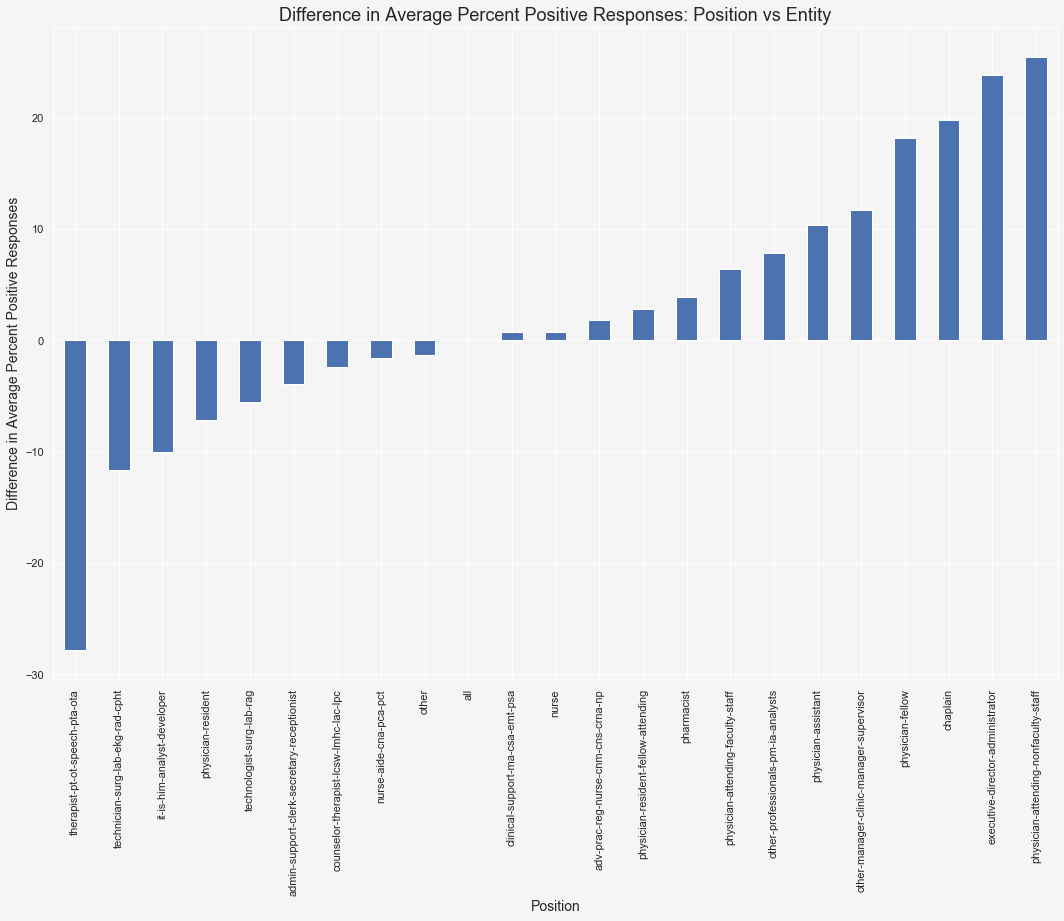

In [38]:
fig, ax = plt.subplots(figsize=(18,12), facecolor='whitesmoke')
plt.grid(False)
score_pos_grouped_sorted['group_entity_pct_pos_diff'].plot(kind='bar',figsize=(18,12))
ax.set_title('Difference in Average Percent Positive Responses: Position vs Entity', fontsize=18)
ax.set_xlabel('Position', fontsize=14)
ax.set_ylabel('Difference in Average Percent Positive Responses', fontsize=14)

save_figure(fig,FIGURE_PATH,'score_pos_pct_pos_')

### Position: Question Category and Question ID

In [39]:
score_pos_qc_data = score_positions[score_positions['question_category']!='GME Questions']
score_pos_qc_data_grouped = score_pos_qc_data.groupby(['position','question_category']).mean()['group_entity_pct_pos_diff'].unstack()
score_pos_qid_data_grouped = score_pos_qc_data.groupby(['position','question_id']).mean()['group_entity_pct_pos_diff'].unstack()
score_pos_qid_data_grouped.columns = [col+' '+qid_cat_label_dict[col] for col in score_pos_qid_data_grouped.columns]

In [40]:
print(len(score_pos_qc_data_grouped))
print(len(score_pos_qc_data_grouped.columns))
score_pos_qc_data_grouped.head()

23
12


question_category                           Advancement  Burnout Climate  \
position                                                                   
admin-support-clerk-secretary-receptionist        -10.0              2.0   
adv-prac-reg-nurse-cnm-cns-crna-np                -11.0             -1.0   
all                                                 0.0              0.0   
chaplain                                           -6.0             48.0   
clinical-support-ma-csa-emt-psa                     9.0              1.0   

question_category                           Decision Making  \
position                                                      
admin-support-clerk-secretary-receptionist             -9.0   
adv-prac-reg-nurse-cnm-cns-crna-np                     -2.0   
all                                                     0.0   
chaplain                                               -7.0   
clinical-support-ma-csa-emt-psa                       -12.0   

question_category                           Emotional Thriving  \
position                                                         
admin-support-clerk-secretary-receptionist                -7.0   
adv-prac-reg-nurse-cnm-cns-crna-np                         2.0   
all                                                        0.0   
chaplain                                                  14.0   
clinical-support-ma-csa-emt-psa                            6.0   

question_category                           Growth Opportunities  \
position                                                           
admin-support-clerk-secretary-receptionist                  -9.0   
adv-prac-reg-nurse-cnm-cns-crna-np                          -3.0   
all                                                          0.0   
chaplain                                                    12.0   
clinical-support-ma-csa-emt-psa                             10.0   

question_category                           Improvement Readiness  \
position                                                            
admin-support-clerk-secretary-receptionist                  -16.0   
adv-prac-reg-nurse-cnm-cns-crna-np                            7.5   
all                                                           0.0   
chaplain                                                     33.5   
clinical-support-ma-csa-emt-psa                               3.5   

question_category                           Job Certainty  Local Leadership  \
position                                                                      
admin-support-clerk-secretary-receptionist          -10.0               4.5   
adv-prac-reg-nurse-cnm-cns-crna-np                   11.0              -6.0   
all                                                   0.0               0.0   
chaplain                                             -3.0              31.5   
clinical-support-ma-csa-emt-psa                       0.0               6.5   

question_category                           Personal Burnout  Physical Safety  \
position                                                                        
admin-support-clerk-secretary-receptionist              10.0             -5.0   
adv-prac-reg-nurse-cnm-cns-crna-np                       3.0              0.0   
all                                                      0.0              0.0   
chaplain                                                46.0             25.0   
clinical-support-ma-csa-emt-psa                          8.0              4.0   

question_category                           Safety Climate  Teamwork  
position                                                              
admin-support-clerk-secretary-receptionist         -2.0000   -1.0000  
adv-prac-reg-nurse-cnm-cns-crna-np                  4.3333    6.0000  
all                                                 0.0000    0.0000  
chaplain                                            6.6667   26.0000  
clinical-support-ma-csa-emt-psa                    -4

In [41]:
print(len(score_pos_qid_data_grouped))
print(len(score_pos_qid_data_grouped.columns))
score_pos_qid_data_grouped.head()

23
18


q00 Improvement Readiness (defects)  \
position                                                                          
admin-support-clerk-secretary-receptionist                                -20.0   
adv-prac-reg-nurse-cnm-cns-crna-np                                          9.0   
all                                                                         0.0   
chaplain                                                                   32.0   
clinical-support-ma-csa-emt-psa                                             1.0   

                                            q01 Improvement Readiness (reflect)  \
position                                                                          
admin-support-clerk-secretary-receptionist                                -12.0   
adv-prac-reg-nurse-cnm-cns-crna-np                                          6.0   
all                                                                         0.0   
chaplain                                                                   35.0   
clinical-support-ma-csa-emt-psa                                             6.0   

                                            q02 Local Leadership (feedback)  \
position                                                                      
admin-support-clerk-secretary-receptionist                              3.0   
adv-prac-reg-nurse-cnm-cns-crna-np                                     -6.0   
all                                                                     0.0   
chaplain                                                               35.0   
clinical-support-ma-csa-emt-psa                                         3.0   

                                            q03 Local Leadership (reflect)  \
position                                                                     
admin-support-clerk-secretary-receptionist                             6.0   
adv-prac-reg-nurse-cnm-cns-crna-np                                    -6.0   
all                                                                    0.0   
chaplain                                                              28.0   
clinical-support-ma-csa-emt-psa                                       10.0   

                                            q04 Burnout Climate  \
position                                                          
admin-support-clerk-secretary-receptionist                  2.0   
adv-prac-reg-nurse-cnm-cns-crna-np                         -1.0   
all                                                         0.0   
chaplain                                                   48.0   
clinical-support-ma-csa-emt-psa                             1.0   

                                            q05 Personal Burnout  \
position                                                           
admin-support-clerk-secretary-receptionist                  10.0   
adv-prac-reg-nurse-cnm-cns-crna-np                           3.0   
all                                                          0.0   
chaplain                                                    46.0   
clinical-support-ma-csa-emt-psa                              8.0   

                                            q06 Emotional Thriving  \
position                                                             
admin-support-clerk-secretary-receptionist                    -7.0   
adv-prac-reg-nurse-cnm-cns-crna-np                             2.0   
all                                                            0.0   
chaplain                                                      14.0   
clinical-support-ma-csa-emt-psa                                6.0   

                                            q07 Teamwork (problems)  \
position                                                              
admin-support-clerk-secretary-receptionist                     -6.0   
adv-prac-reg-nurse-cnm-cns-crna-np                             11.0   
all                                                      

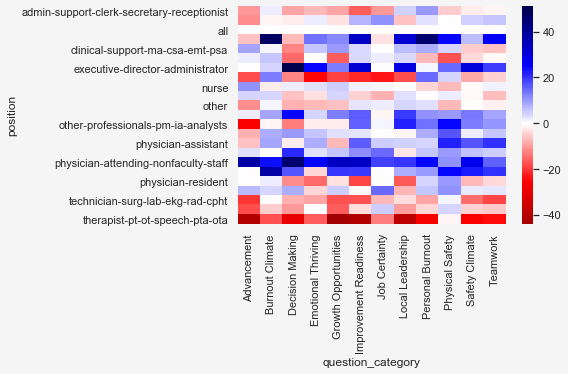

In [42]:
sns.heatmap(score_pos_qc_data_grouped.fillna(0),annot=False,cmap='seismic_r',center=0)

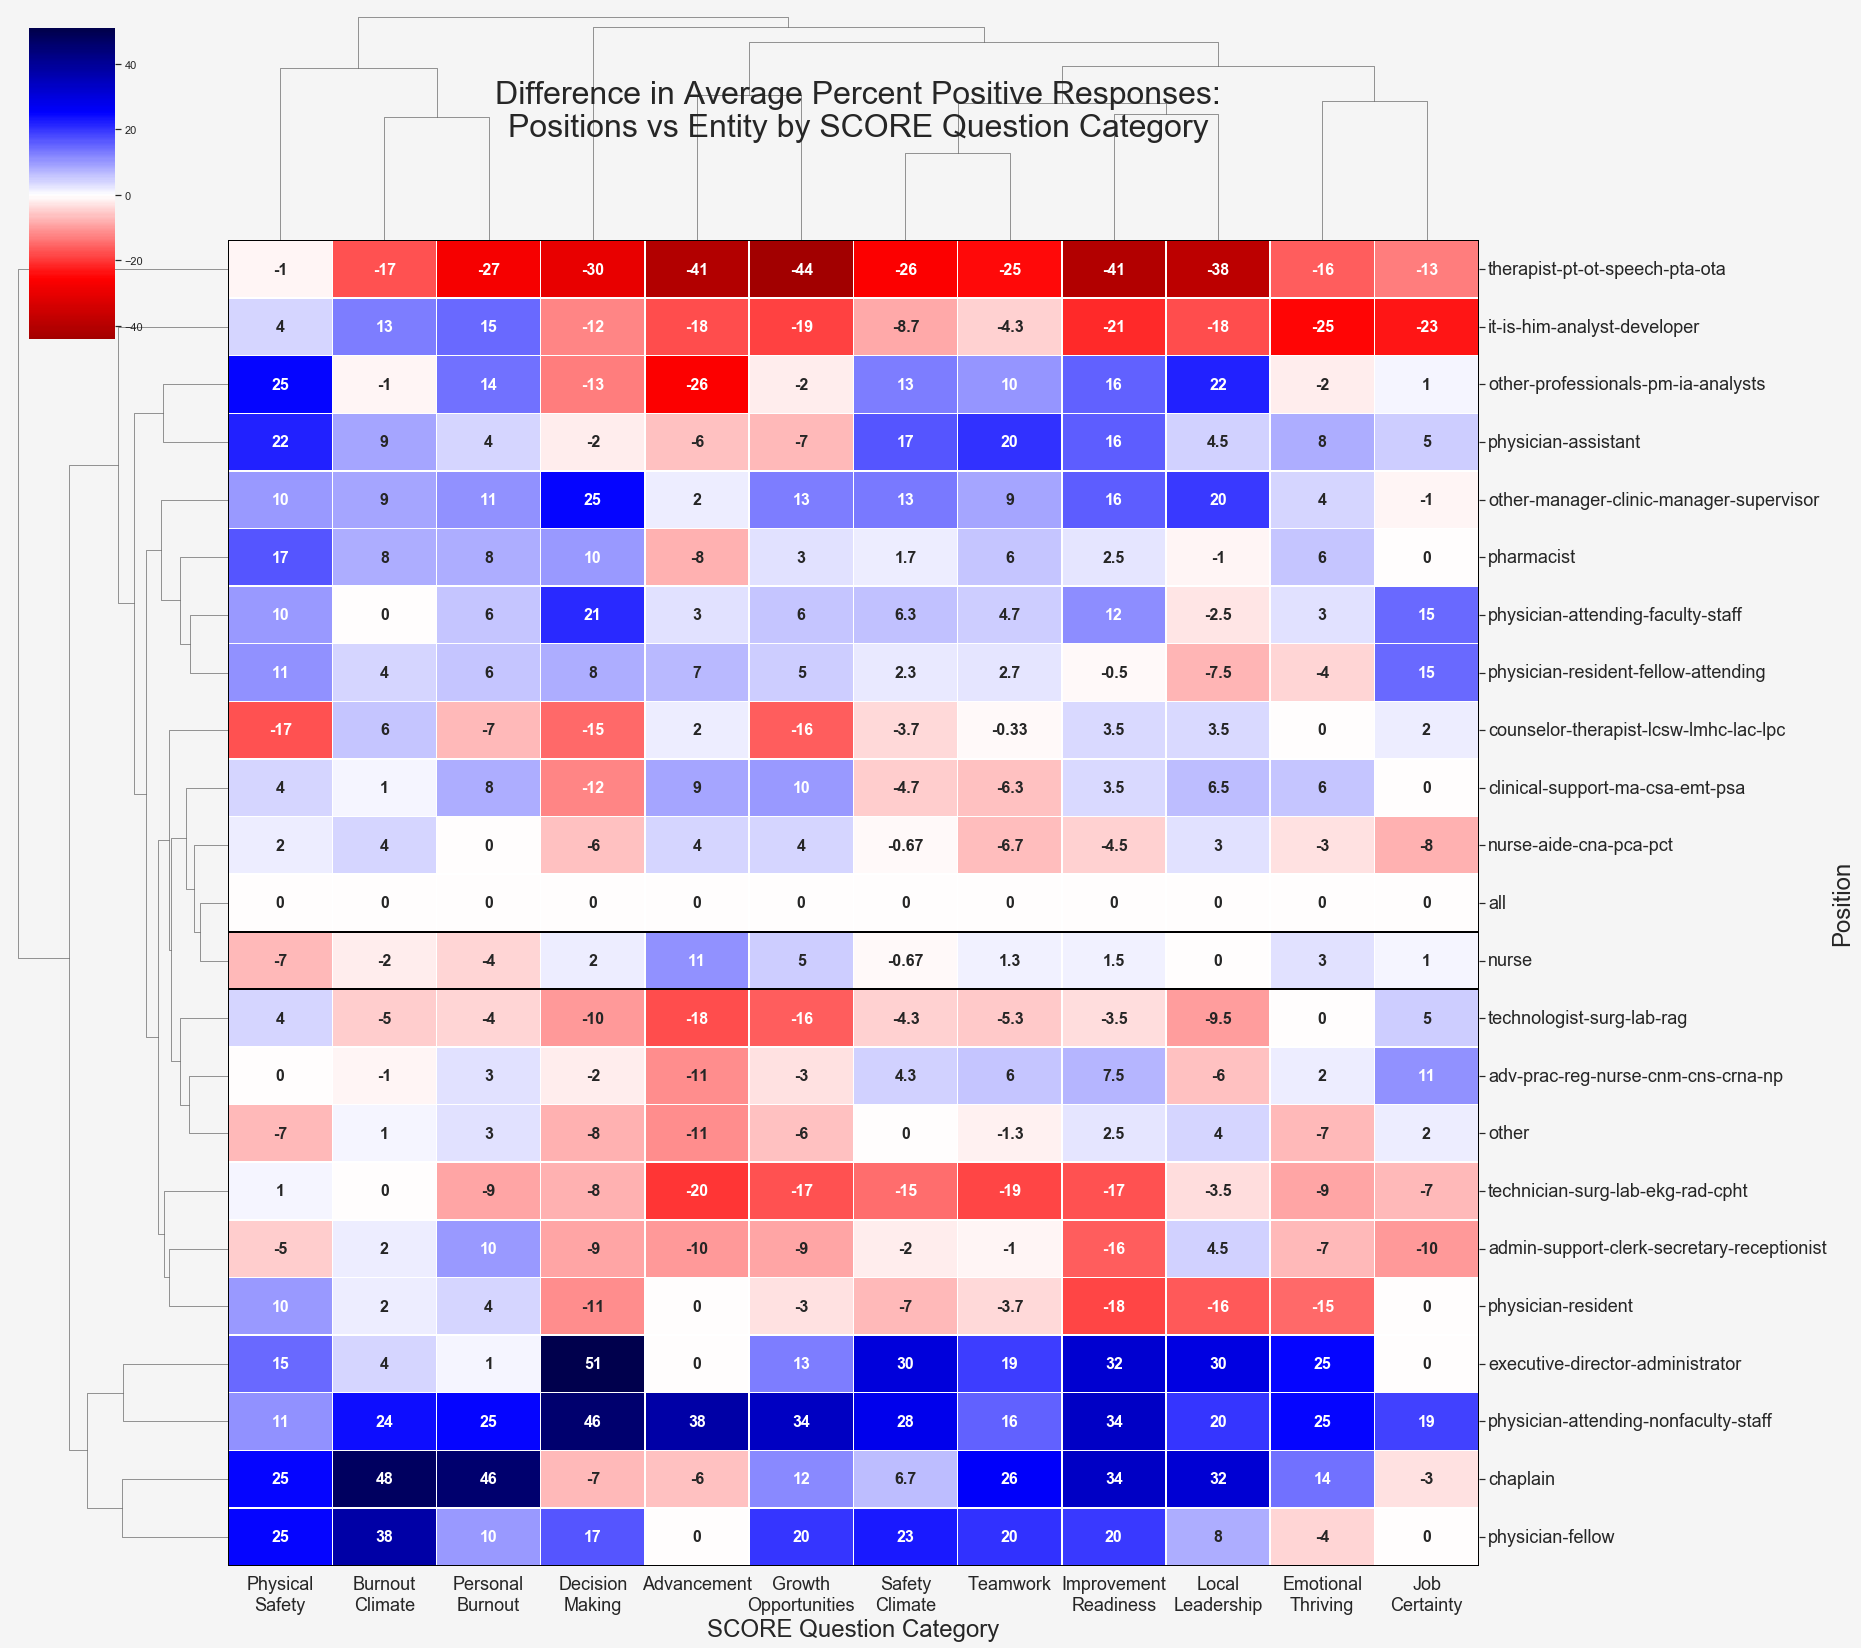

In [43]:
sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'whitesmoke'})

data = score_pos_qc_data_grouped.fillna(0)
a = sns.clustermap(data,figsize=(24,24),annot=True,annot_kws={'fontsize':16,'weight':'bold'},
                   cmap='seismic_r',center=0,dendrogram_ratio=[0.15,0.15],lw=0.5)

# labels
title = 'Difference in Average Percent Positive Responses:\nPositions vs Entity by SCORE Question Category'
a.fig.suptitle(title, x=0.5, y=0.95, fontsize=32)
a.ax_heatmap.set_xlabel('SCORE Question Category', fontsize=24)
a.ax_heatmap.set_ylabel('Position', fontsize=24)

# tick labels
xticklabels = ['\n'.join(item.get_text().split()) for item in a.ax_heatmap.get_xticklabels()]
yticklabels = a.ax_heatmap.get_yticklabels()
a.ax_heatmap.set_xticklabels(xticklabels, rotation=0, ha='center', fontsize=18)
a.ax_heatmap.set_yticklabels(yticklabels, rotation=0, va='center', fontsize=18)

# bounding boxes
ax = a.ax_heatmap
ax.add_patch(Rectangle((0, 0), len(data.columns), len(data), fill=False, edgecolor='black', lw=2))
ax.add_patch(Rectangle((0, 12), len(data.columns), 1, fill=False, edgecolor='black', lw=2))

save_figure(a.fig,FIGURE_PATH,'score_pos_qc_pct_pos_')

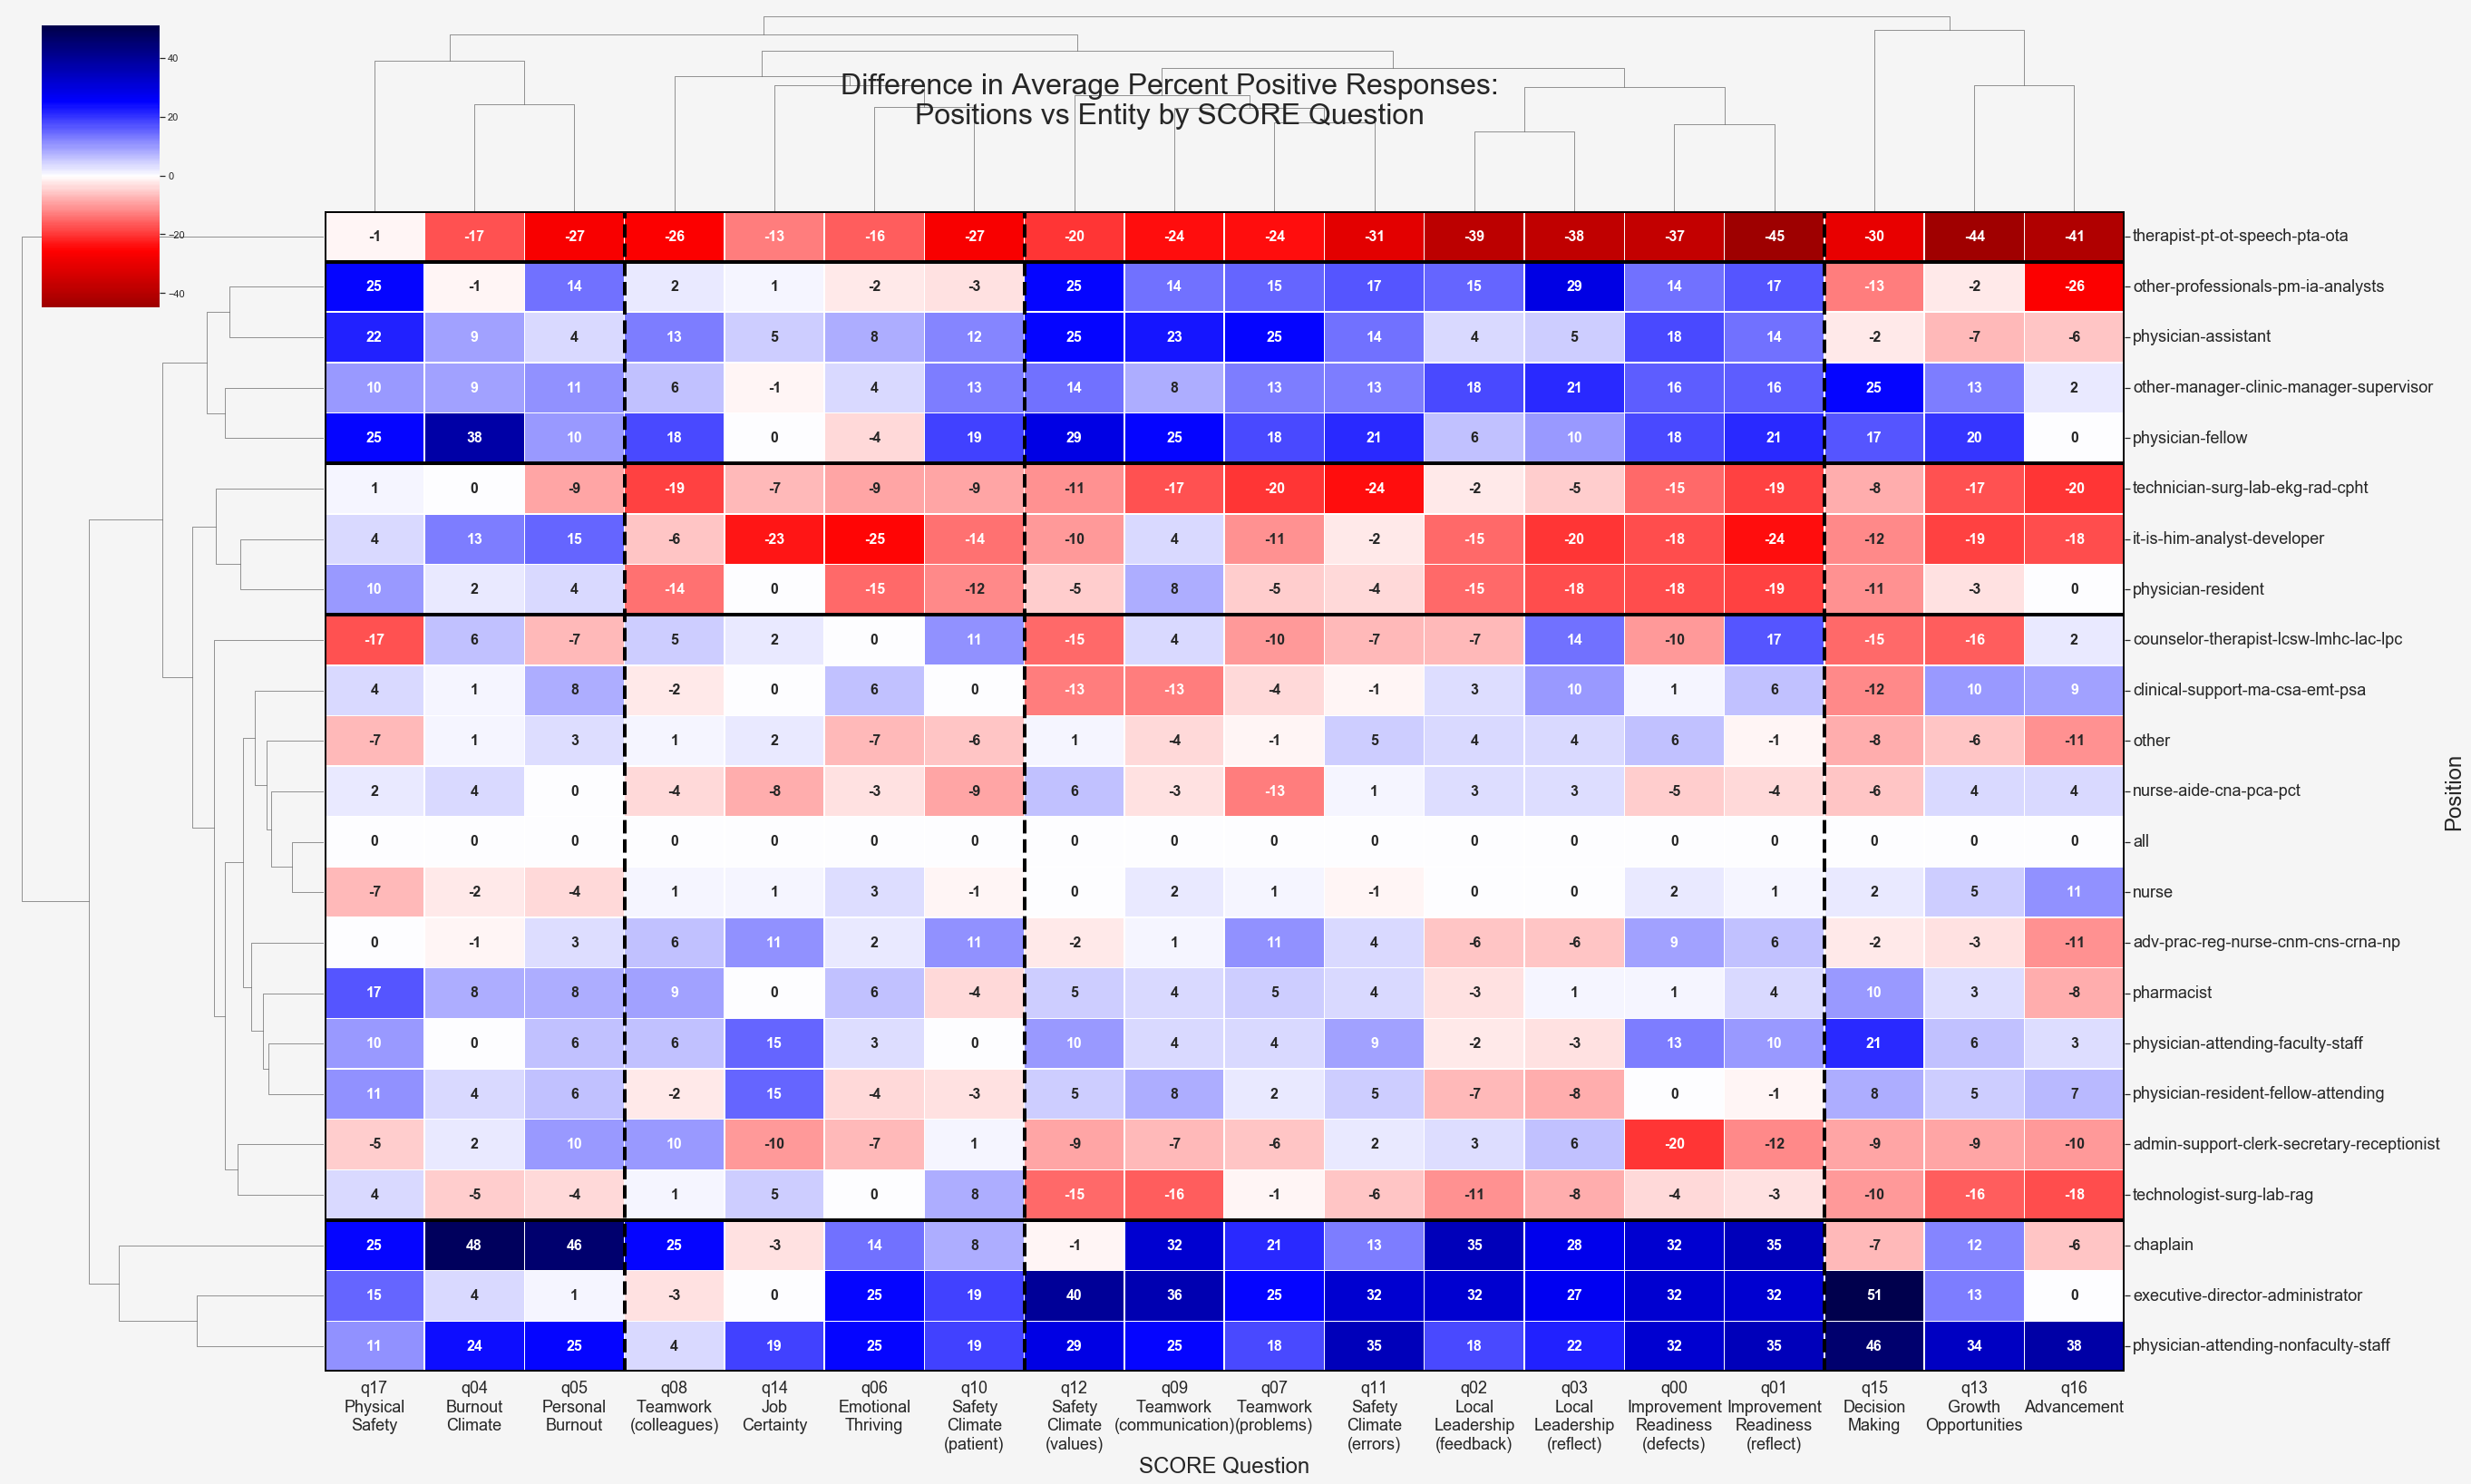

In [44]:
sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'whitesmoke'})

data = score_pos_qid_data_grouped.fillna(0)
a = sns.clustermap(data,figsize=(36,24),annot=True,annot_kws={'fontsize':16,'weight':'bold'},
                   cmap='seismic_r',center=0,dendrogram_ratio=[0.15,0.15],lw=0.5)

# labels
title = 'Difference in Average Percent Positive Responses:\nPositions vs Entity by SCORE Question'
a.fig.suptitle(title, x=0.5, y=0.95, fontsize=32)
a.ax_heatmap.set_xlabel('SCORE Question', fontsize=24)
a.ax_heatmap.set_ylabel('Position', fontsize=24)

# tick labels
xticklabels = ['\n'.join(item.get_text().split()) for item in a.ax_heatmap.get_xticklabels()]
yticklabels = a.ax_heatmap.get_yticklabels()
a.ax_heatmap.set_xticklabels(xticklabels, rotation=0, ha='center', fontsize=18)
a.ax_heatmap.set_yticklabels(yticklabels, rotation=0, va='center', fontsize=18)

# bounding boxes
ax = a.ax_heatmap
ax.add_patch(Rectangle((0, 0), len(data.columns), len(data), fill=False, edgecolor='black', lw=4))
#ax.add_patch(Rectangle((0, 13), len(data.columns), 1, fill=False, edgecolor='black', lw=2))

# TEMP LINES
ax.axhline(1, color='black', lw=4)
ax.axhline(5, color='black', lw=4)
ax.axhline(8, color='black', lw=4)
ax.axhline(20, color='black', lw=4)

ax.axvline(3, color='black', lw=4, ls='--')
ax.axvline(7, color='black', lw=4, ls='--')
ax.axvline(15, color='black', lw=4, ls='--')

#save_figure(a.fig,FIGURE_PATH,'score_pos_qid_pct_pos_')

## Nurses

In [45]:
use_cols = ['num_respondents','group_pct_pos','entity_pct_pos','group_entity_pct_pos_diff']
score_nurse_grouped = score_nurses[score_nurses['question_category']!='GME Questions'].groupby(['work_setting']).mean()[use_cols]
score_nurse_grouped_sorted = score_nurse_grouped.sort_values('group_entity_pct_pos_diff')

In [46]:
score_nurse_grouped.head()

num_respondents  group_pct_pos  entity_pct_pos  \
work_setting                                                              
ace-unit                            25.0        53.5556         59.9444   
all                                579.0        60.7222         59.9444   
cardiac-catheterization             10.0        58.9444         59.9444   
case-management                      8.0        64.0000         59.9444   
cath-ep-lab                         14.0        54.7222         59.9444   

                         group_entity_pct_pos_diff  
work_setting                                        
ace-unit                                   -6.3889  
all                                         0.7778  
cardiac-catheterization                    -1.0000  
case-management                             4.0556  
cath-ep-lab                                -5.2222

In [47]:
score_nurse_grouped_sorted.head()

num_respondents  group_pct_pos  \
work_setting                                                         
er-staff                                       41.0        31.4444   
cupp-pavilion-4-south                          23.0        35.5000   
periop-cardiology-vascular-general              5.0        40.0000   
or-periop-endoscopy                            29.0        45.3333   
psych-units-behavioral-health                   5.0        45.5556   

                                    entity_pct_pos  group_entity_pct_pos_diff  
work_setting                                                                   
er-staff                                   59.9444                   -28.5000  
cupp-pavilion-4-south                      59.9444                   -24.4444  
periop-cardiology-vascular-general         59.9444                   -19.5625  
or-periop-endoscopy                        59.9444                   -14.6111  
psych-units-behavioral-health              59.9444                   -14.3889

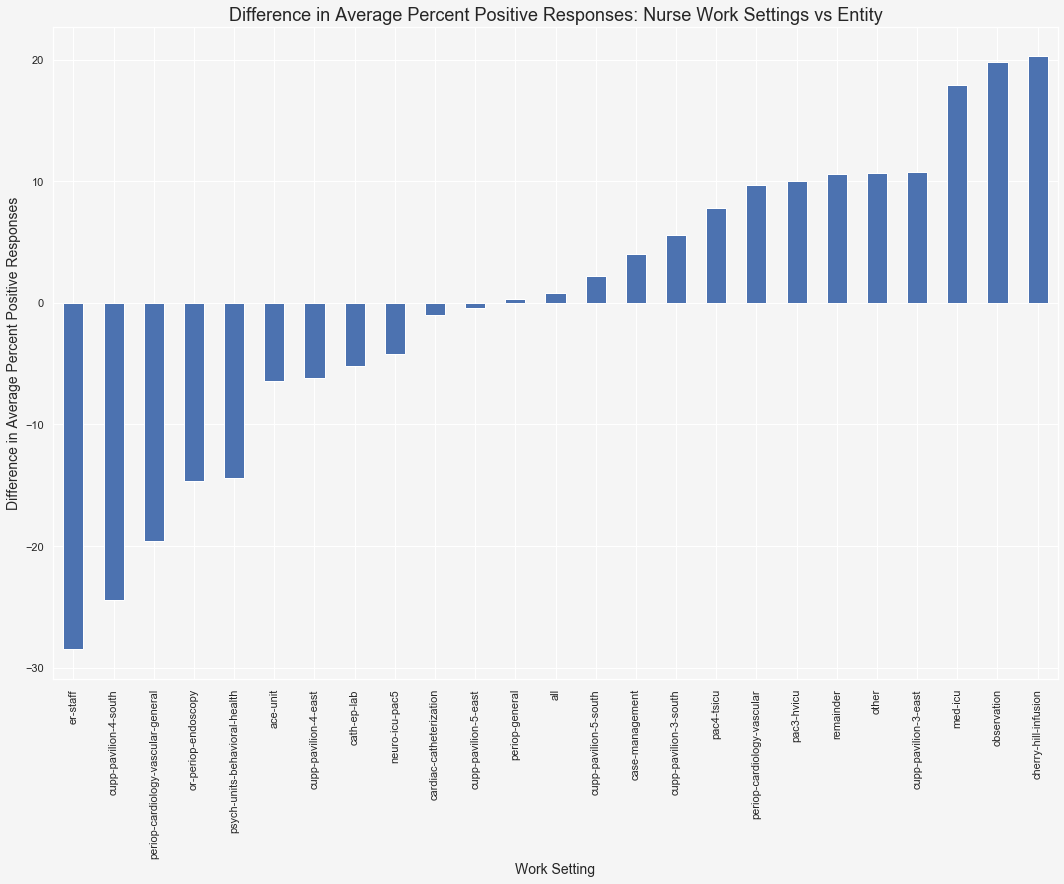

In [48]:
fig, ax = plt.subplots(figsize=(18,12), facecolor='whitesmoke')
plt.grid(False)
score_nurse_grouped_sorted['group_entity_pct_pos_diff'].plot(kind='bar',figsize=(18,12))
ax.set_title('Difference in Average Percent Positive Responses: Nurse Work Settings vs Entity', fontsize=18)
ax.set_xlabel('Work Setting', fontsize=14)
ax.set_ylabel('Difference in Average Percent Positive Responses', fontsize=14)

save_figure(fig,FIGURE_PATH,'score_nurse_pct_pos_')

### Nurses: Question Category and Question ID

In [49]:
score_nurse_qc_data = score_nurses[score_nurses['question_category']!='GME Questions']
score_nurse_qc_data_grouped = score_nurse_qc_data.groupby(['work_setting','question_category']).mean()['group_entity_pct_pos_diff'].unstack()
score_nurse_qid_data_grouped = score_nurse_qc_data.groupby(['work_setting','question_id']).mean()['group_entity_pct_pos_diff'].unstack()
score_nurse_qid_data_grouped.columns = [col+' '+qid_cat_label_dict[col] for col in score_nurse_qid_data_grouped.columns]

In [50]:
print(len(score_nurse_qc_data_grouped))
print(len(score_nurse_qc_data_grouped.columns))
score_nurse_qc_data_grouped.head()

25
12


question_category        Advancement  Burnout Climate  Decision Making  \
work_setting                                                             
ace-unit                        18.0            -11.0             -4.0   
all                             11.0             -2.0              2.0   
cardiac-catheterization        -12.0             11.0            -10.0   
case-management                -12.0              5.0             10.0   
cath-ep-lab                      2.0              3.0             -4.0   

question_category        Emotional Thriving  Growth Opportunities  \
work_setting                                                        
ace-unit                               -7.0                  -6.0   
all                                     3.0                   5.0   
cardiac-catheterization                -5.0                  12.0   
case-management                        13.0                 -23.0   
cath-ep-lab                             4.0                  -2.0   

question_category        Improvement Readiness  Job Certainty  \
work_setting                                                    
ace-unit                                 -11.5          -13.0   
all                                        1.5            1.0   
cardiac-catheterization                  -25.0           19.0   
case-management                           -6.5           -6.0   
cath-ep-lab                              -18.0          -10.0   

question_category        Local Leadership  Personal Burnout  Physical Safety  \
work_setting                                                                   
ace-unit                             -3.5              -8.0              5.0   
all                                   0.0              -4.0             -7.0   
cardiac-catheterization              32.0               8.0              3.0   
case-management                       5.0              17.0              8.0   
cath-ep-lab                          -6.0              11.0             -4.0   

question_category        Safety Climate  Teamwork  
work_setting                                       
ace-unit                       -13.0000   -6.6667  
all                             -0.6667    1.3333  
cardiac-catheterization         -1.0000  -18.3333  
case-management                 11.6667    9.6667  
cath-ep-lab                    -13.0000   -2.3333

In [51]:
print(len(score_nurse_qid_data_grouped))
print(len(score_nurse_qid_data_grouped.columns))
score_nurse_qid_data_grouped.head()

25
18


q00 Improvement Readiness (defects)  \
work_setting                                                   
ace-unit                                               -12.0   
all                                                      2.0   
cardiac-catheterization                                -18.0   
case-management                                        -11.0   
cath-ep-lab                                            -14.0   

                         q01 Improvement Readiness (reflect)  \
work_setting                                                   
ace-unit                                               -11.0   
all                                                      1.0   
cardiac-catheterization                                -32.0   
case-management                                         -2.0   
cath-ep-lab                                            -22.0   

                         q02 Local Leadership (feedback)  \
work_setting                                               
ace-unit                                            -9.0   
all                                                  0.0   
cardiac-catheterization                             35.0   
case-management                                     21.0   
cath-ep-lab                                         -8.0   

                         q03 Local Leadership (reflect)  q04 Burnout Climate  \
work_setting                                                                   
ace-unit                                            2.0                -11.0   
all                                                 0.0                 -2.0   
cardiac-catheterization                            29.0                 11.0   
case-management                                   -11.0                  5.0   
cath-ep-lab                                        -4.0                  3.0   

                         q05 Personal Burnout  q06 Emotional Thriving  \
work_setting                                                            
ace-unit                                 -8.0                    -7.0   
all                                      -4.0                     3.0   
cardiac-catheterization                   8.0                    -5.0   
case-management                          17.0                    13.0   
cath-ep-lab                              11.0                     4.0   

                         q07 Teamwork (problems)  q08 Teamwork (colleagues)  \
work_setting                                                                  
ace-unit                                     0.0                       -3.0   
all                                          1.0                        1.0   
cardiac-catheterization                     -8.0                      -31.0   
case-management                              3.0                       22.0   
cath-ep-lab                                 -4.0                       -3.0   

                         q09 Teamwork (communication)  \
work_setting                                            
ace-unit                                        -17.0   
all                                               2.0   
cardiac-catheterization                         -16.0   
case-management                                   4.0   
cath-ep-lab                                       0.0   

                         q10 Safety Climate (patient)  \
work_setting                                            
ace-unit                                        -29.0   
all                                              -1.0   
cardiac-catheterization                          -1.0   
case-management                                   7.0   
cath-ep-lab                                     -10.0   

                         q11 Safety Climate (errors)  \
work_setting                                           
ace-unit                                        -9.0   
all                                             -1.0   
cardiac-catheterization                         -5.0   

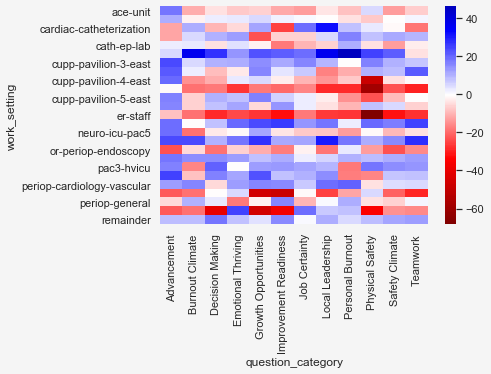

In [52]:
sns.heatmap(score_nurse_qc_data_grouped.fillna(0),annot=False,cmap='seismic_r',center=0)

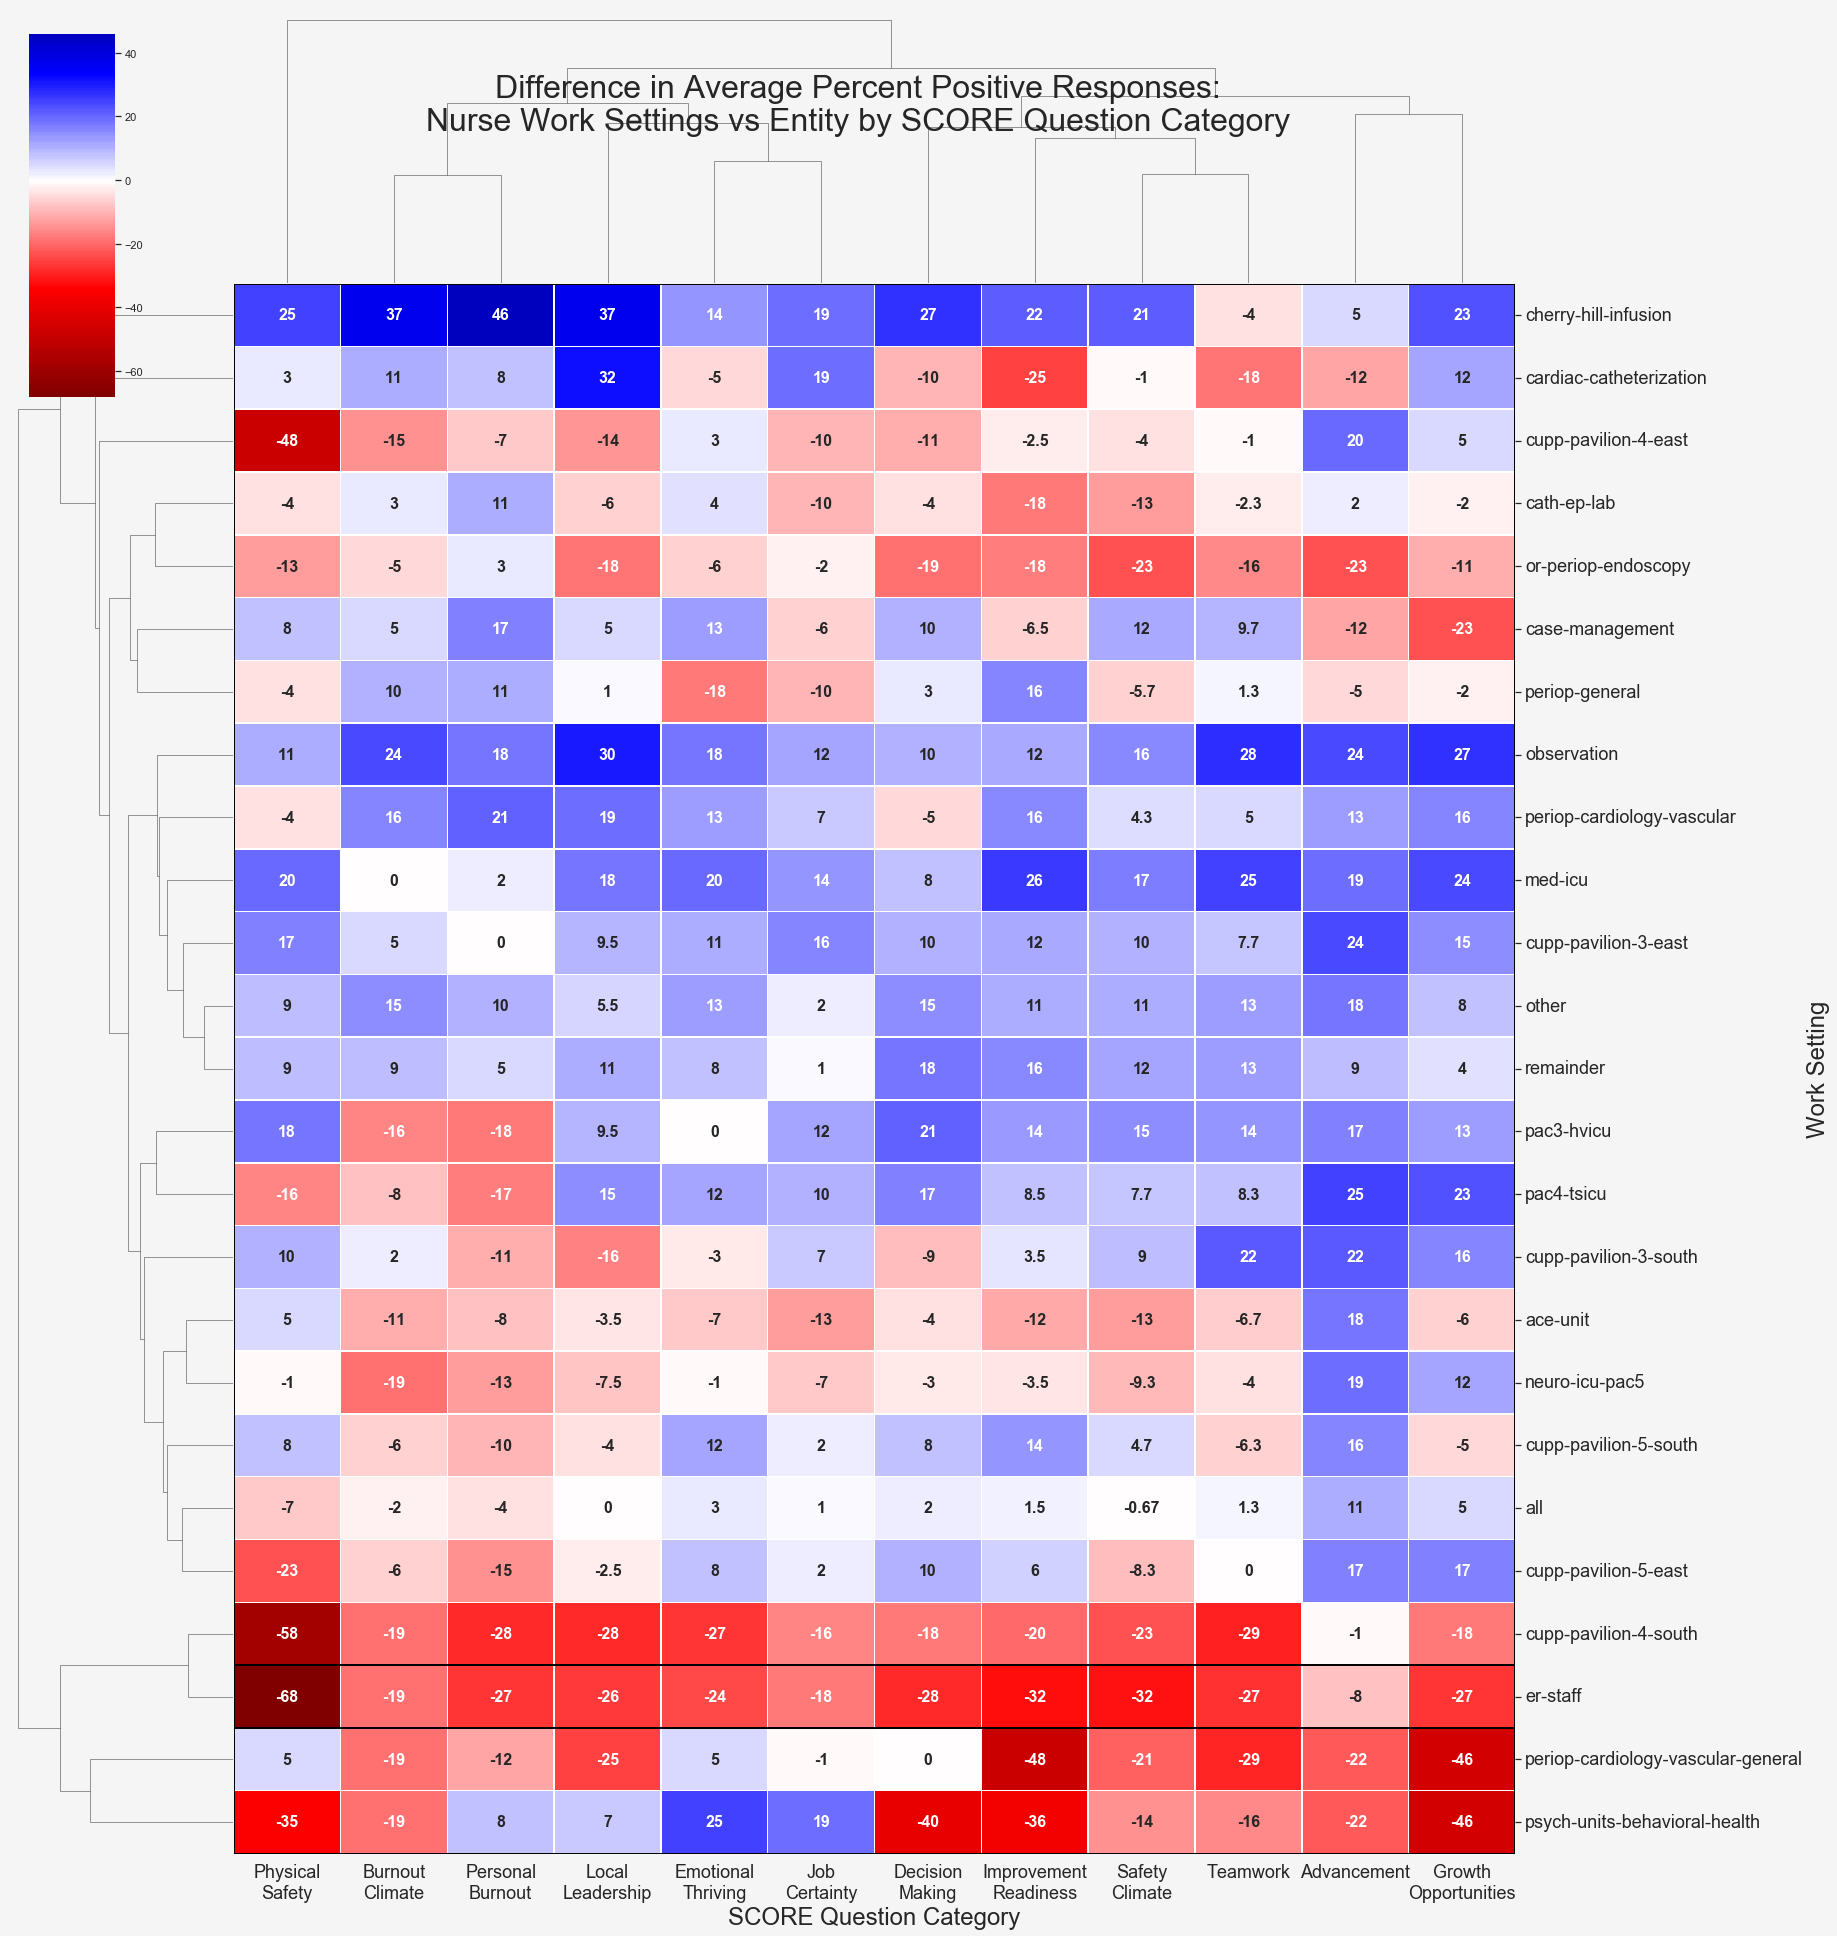

In [53]:
sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'whitesmoke'})

data = score_nurse_qc_data_grouped.fillna(0)
a = sns.clustermap(data,figsize=(24,28),annot=True,annot_kws={'fontsize':16,'weight':'bold'},
                   cmap='seismic_r',center=0,dendrogram_ratio=[0.15,0.15],lw=0.5)

#labels
title = 'Difference in Average Percent Positive Responses:\nNurse Work Settings vs Entity by SCORE Question Category'
a.fig.suptitle(title, x=0.5, y=0.96, fontsize=32)
a.ax_heatmap.set_xlabel('SCORE Question Category', fontsize=24)
a.ax_heatmap.set_ylabel('Work Setting', fontsize=24)

# tick labels
xticklabels = ['\n'.join(item.get_text().split()) for item in a.ax_heatmap.get_xticklabels()]
yticklabels = a.ax_heatmap.get_yticklabels()
a.ax_heatmap.set_xticklabels(xticklabels, rotation=0, ha='center', fontsize=18)
a.ax_heatmap.set_yticklabels(yticklabels, rotation=0, va='center', fontsize=18)

# bounding boxes
ax = a.ax_heatmap
ax.add_patch(Rectangle((0, 0), len(data.columns), len(data), fill=False, edgecolor='black', lw=2))
ax.add_patch(Rectangle((0, 22), len(data.columns), 1, fill=False, edgecolor='black', lw=2))

save_figure(a.fig,FIGURE_PATH,'score_nurse_qc_pct_pos_')

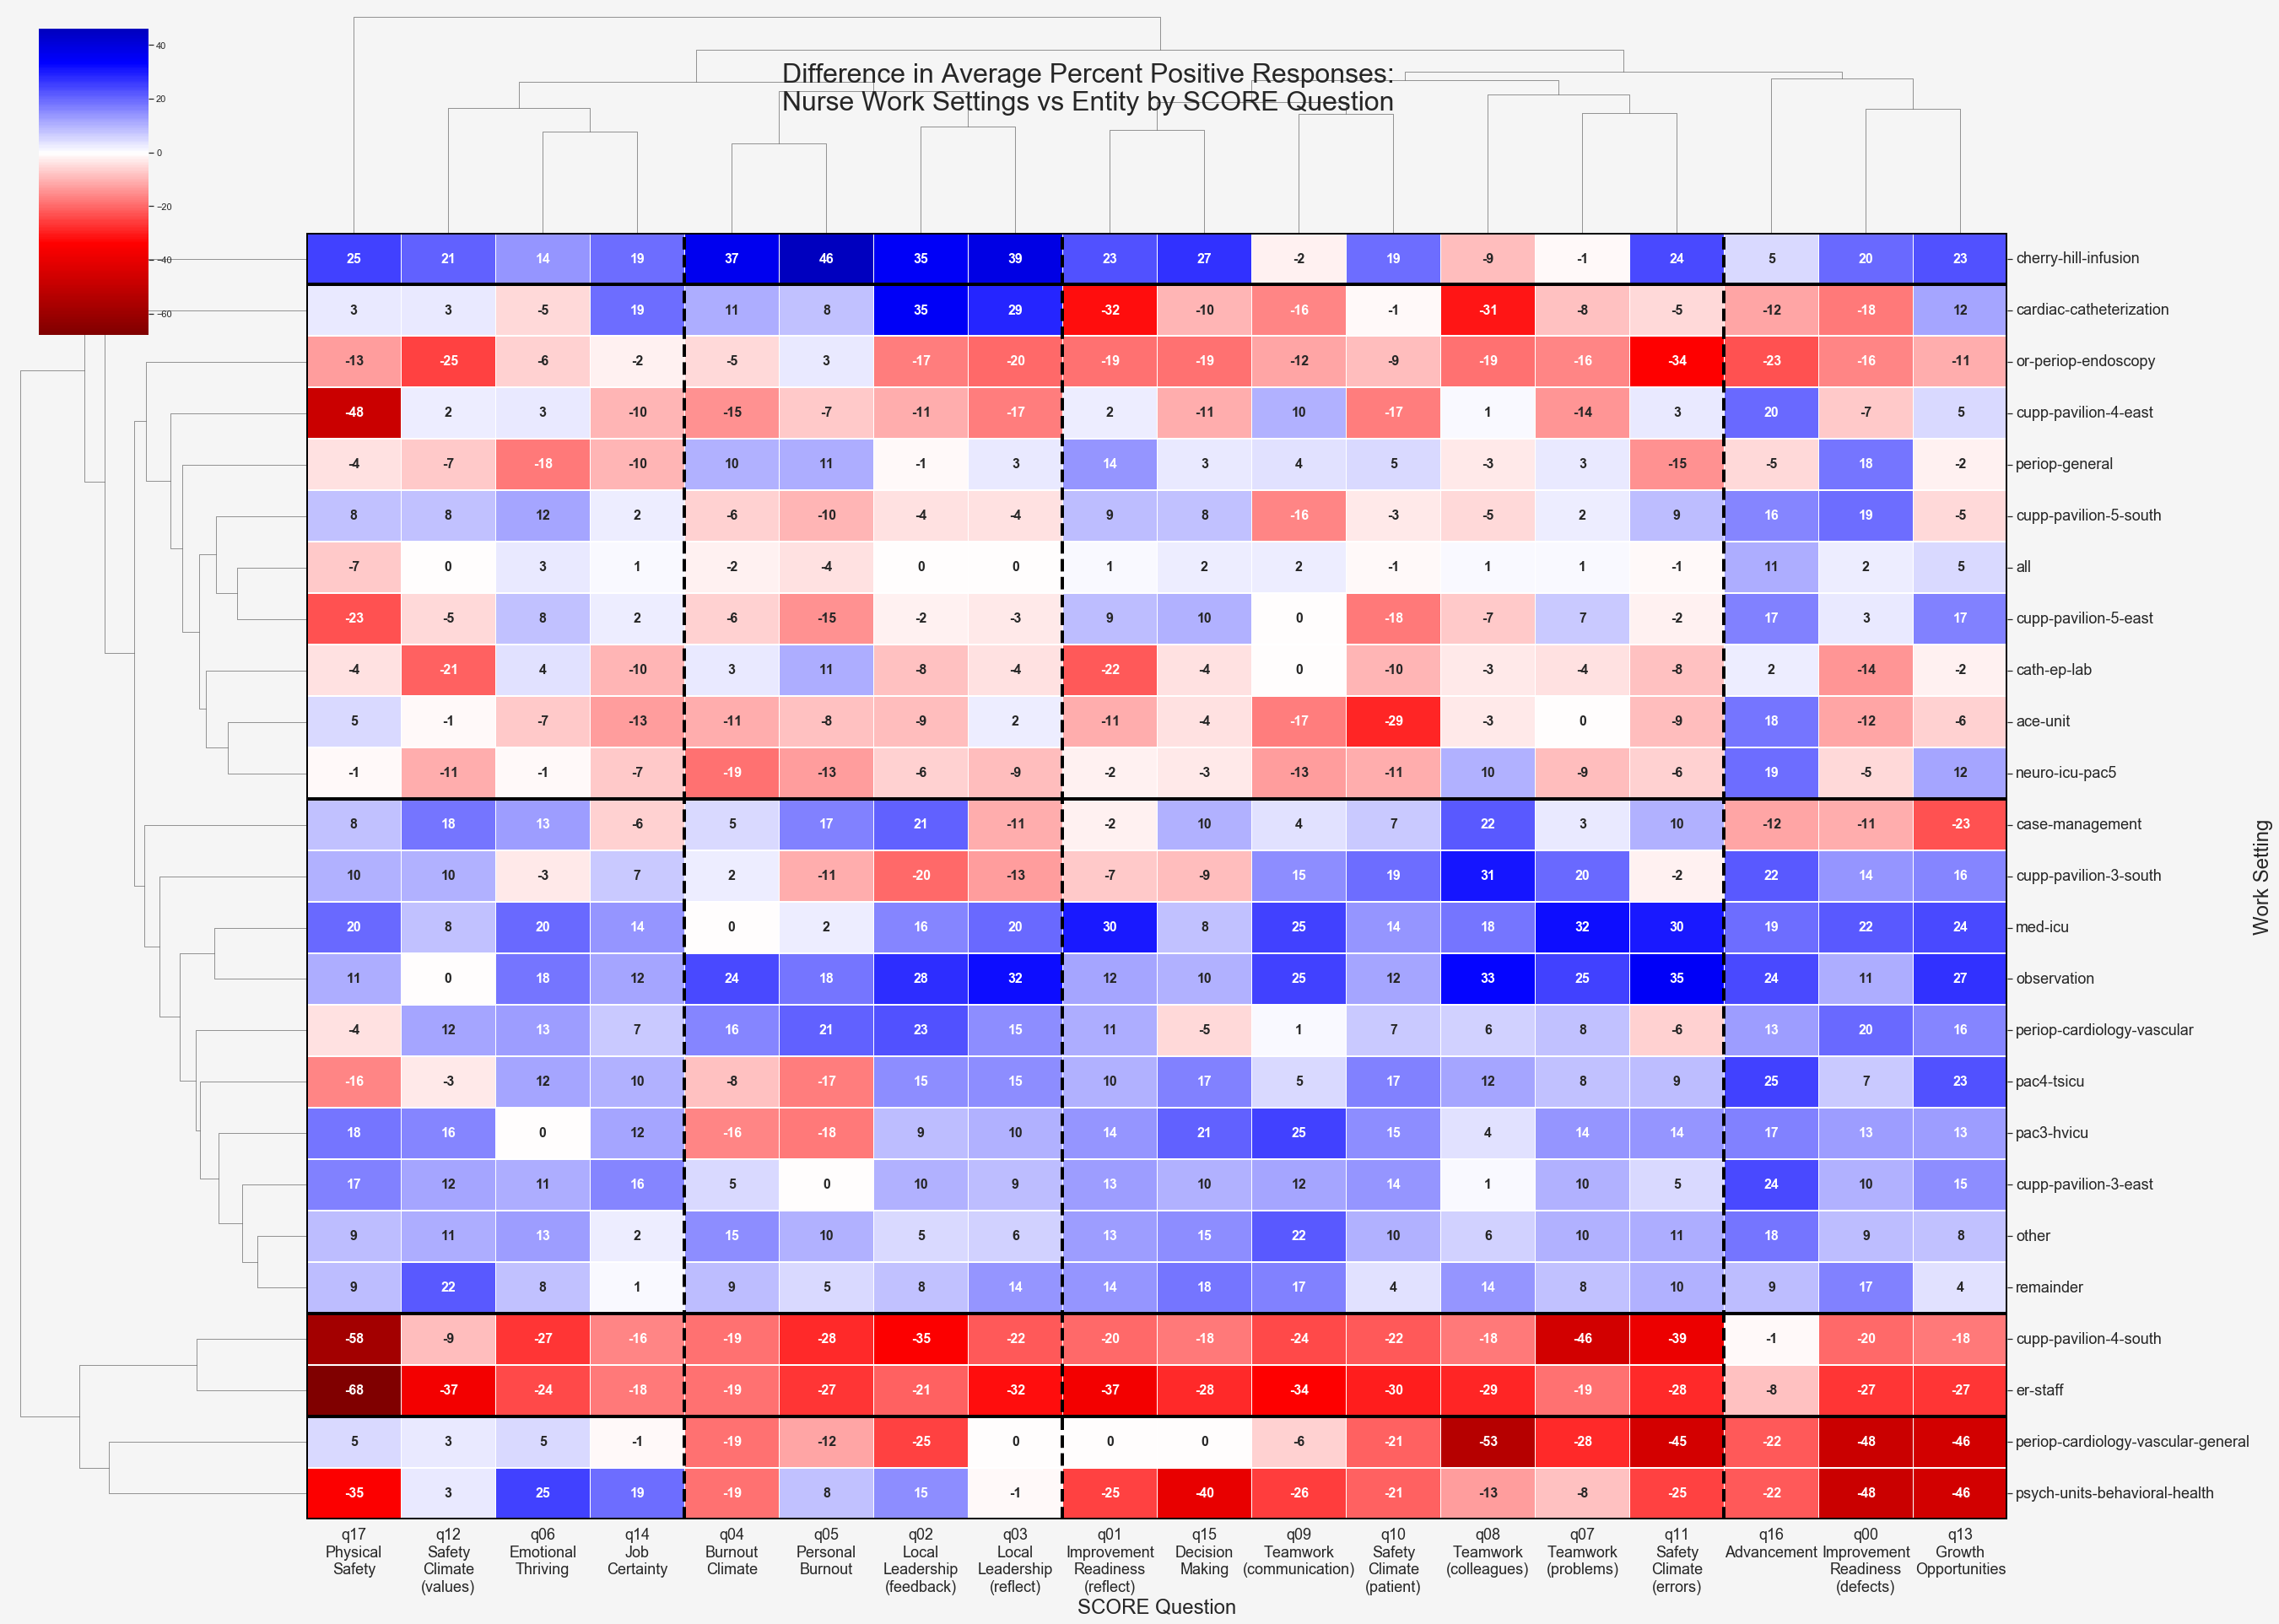

In [54]:
sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'whitesmoke'})

data = score_nurse_qid_data_grouped.fillna(0)
a = sns.clustermap(data,figsize=(36,28),annot=True,annot_kws={'fontsize':16,'weight':'bold'},
                   cmap='seismic_r',center=0,dendrogram_ratio=[0.15,0.15],lw=0.5)

# labels
title = 'Difference in Average Percent Positive Responses:\nNurse Work Settings vs Entity by SCORE Question'
a.fig.suptitle(title, x=0.5, y=0.96, fontsize=32)
a.ax_heatmap.set_xlabel('SCORE Question', fontsize=24)
a.ax_heatmap.set_ylabel('Work Setting', fontsize=24)

# tick labels
xticklabels = ['\n'.join(item.get_text().split()) for item in a.ax_heatmap.get_xticklabels()]
yticklabels = a.ax_heatmap.get_yticklabels()
a.ax_heatmap.set_xticklabels(xticklabels, rotation=0, ha='center', fontsize=18)
a.ax_heatmap.set_yticklabels(yticklabels, rotation=0, va='center', fontsize=18)

# bounding boxes
ax = a.ax_heatmap
ax.add_patch(Rectangle((0, 0), len(data.columns), len(data), fill=False, edgecolor='black', lw=4))
#ax.add_patch(Rectangle((0, 22), len(data.columns), 1, fill=False, edgecolor='black', lw=2))

# TEMP LINES
ax.axhline(1, color='black', lw=4)
ax.axhline(11, color='black', lw=4)
ax.axhline(21, color='black', lw=4)
ax.axhline(23, color='black', lw=4)

ax.axvline(4, color='black', lw=4, ls='--')
ax.axvline(8, color='black', lw=4, ls='--')
ax.axvline(15, color='black', lw=4, ls='--')

#save_figure(a.fig,FIGURE_PATH,'score_nurse_qid_pct_pos_')

#### Some random explorations

In [55]:
temp_data = []
for col in score_nurse_qid_data_grouped.columns:
    temp_data.append(score_nurse_qid_data_grouped[col].sort_values().tolist())
temp_df = pd.DataFrame(temp_data).transpose()
temp_df.columns = score_nurse_qid_data_grouped.columns

In [56]:
temp_df.head(2)

q00 Improvement Readiness (defects)  q01 Improvement Readiness (reflect)  \
0                                -48.0                                -37.0   
1                                -48.0                                -32.0   

   q02 Local Leadership (feedback)  q03 Local Leadership (reflect)  \
0                            -35.0                           -32.0   
1                            -25.0                           -22.0   

   q04 Burnout Climate  q05 Personal Burnout  q06 Emotional Thriving  \
0                -19.0                 -28.0                   -27.0   
1                -19.0                 -27.0                   -24.0   

   q07 Teamwork (problems)  q08 Teamwork (colleagues)  \
0                    -46.0                      -53.0   
1                    -28.0                      -31.0   

   q09 Teamwork (communication)  q10 Safety Climate (patient)  \
0                         -34.0                         -30.0   
1                         -26.0                         -29.0   

   q11 Safety Climate (errors)  q12 Safety Climate (values)  \
0                        -45.0                        -37.0   
1                        -39.0                        -25.0   

   q13 Growth Opportunities  q14 Job Certainty  q15 Decision Making  \
0                     -46.0              -18.0                -40.0   
1                     -46.0              -16.0                -28.0   

   q16 Advancement  q17 Physical Safety  
0            -23.0                -68.0  
1            -22.0                -58.0

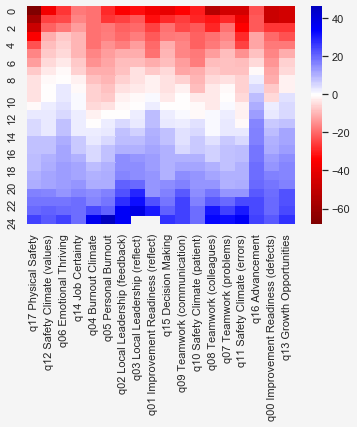

In [57]:
use_cols = [item.get_text().replace('\n', ' ') for item in a.ax_heatmap.get_xticklabels()]
sns.heatmap(temp_df[use_cols], cmap='seismic_r', center=0)

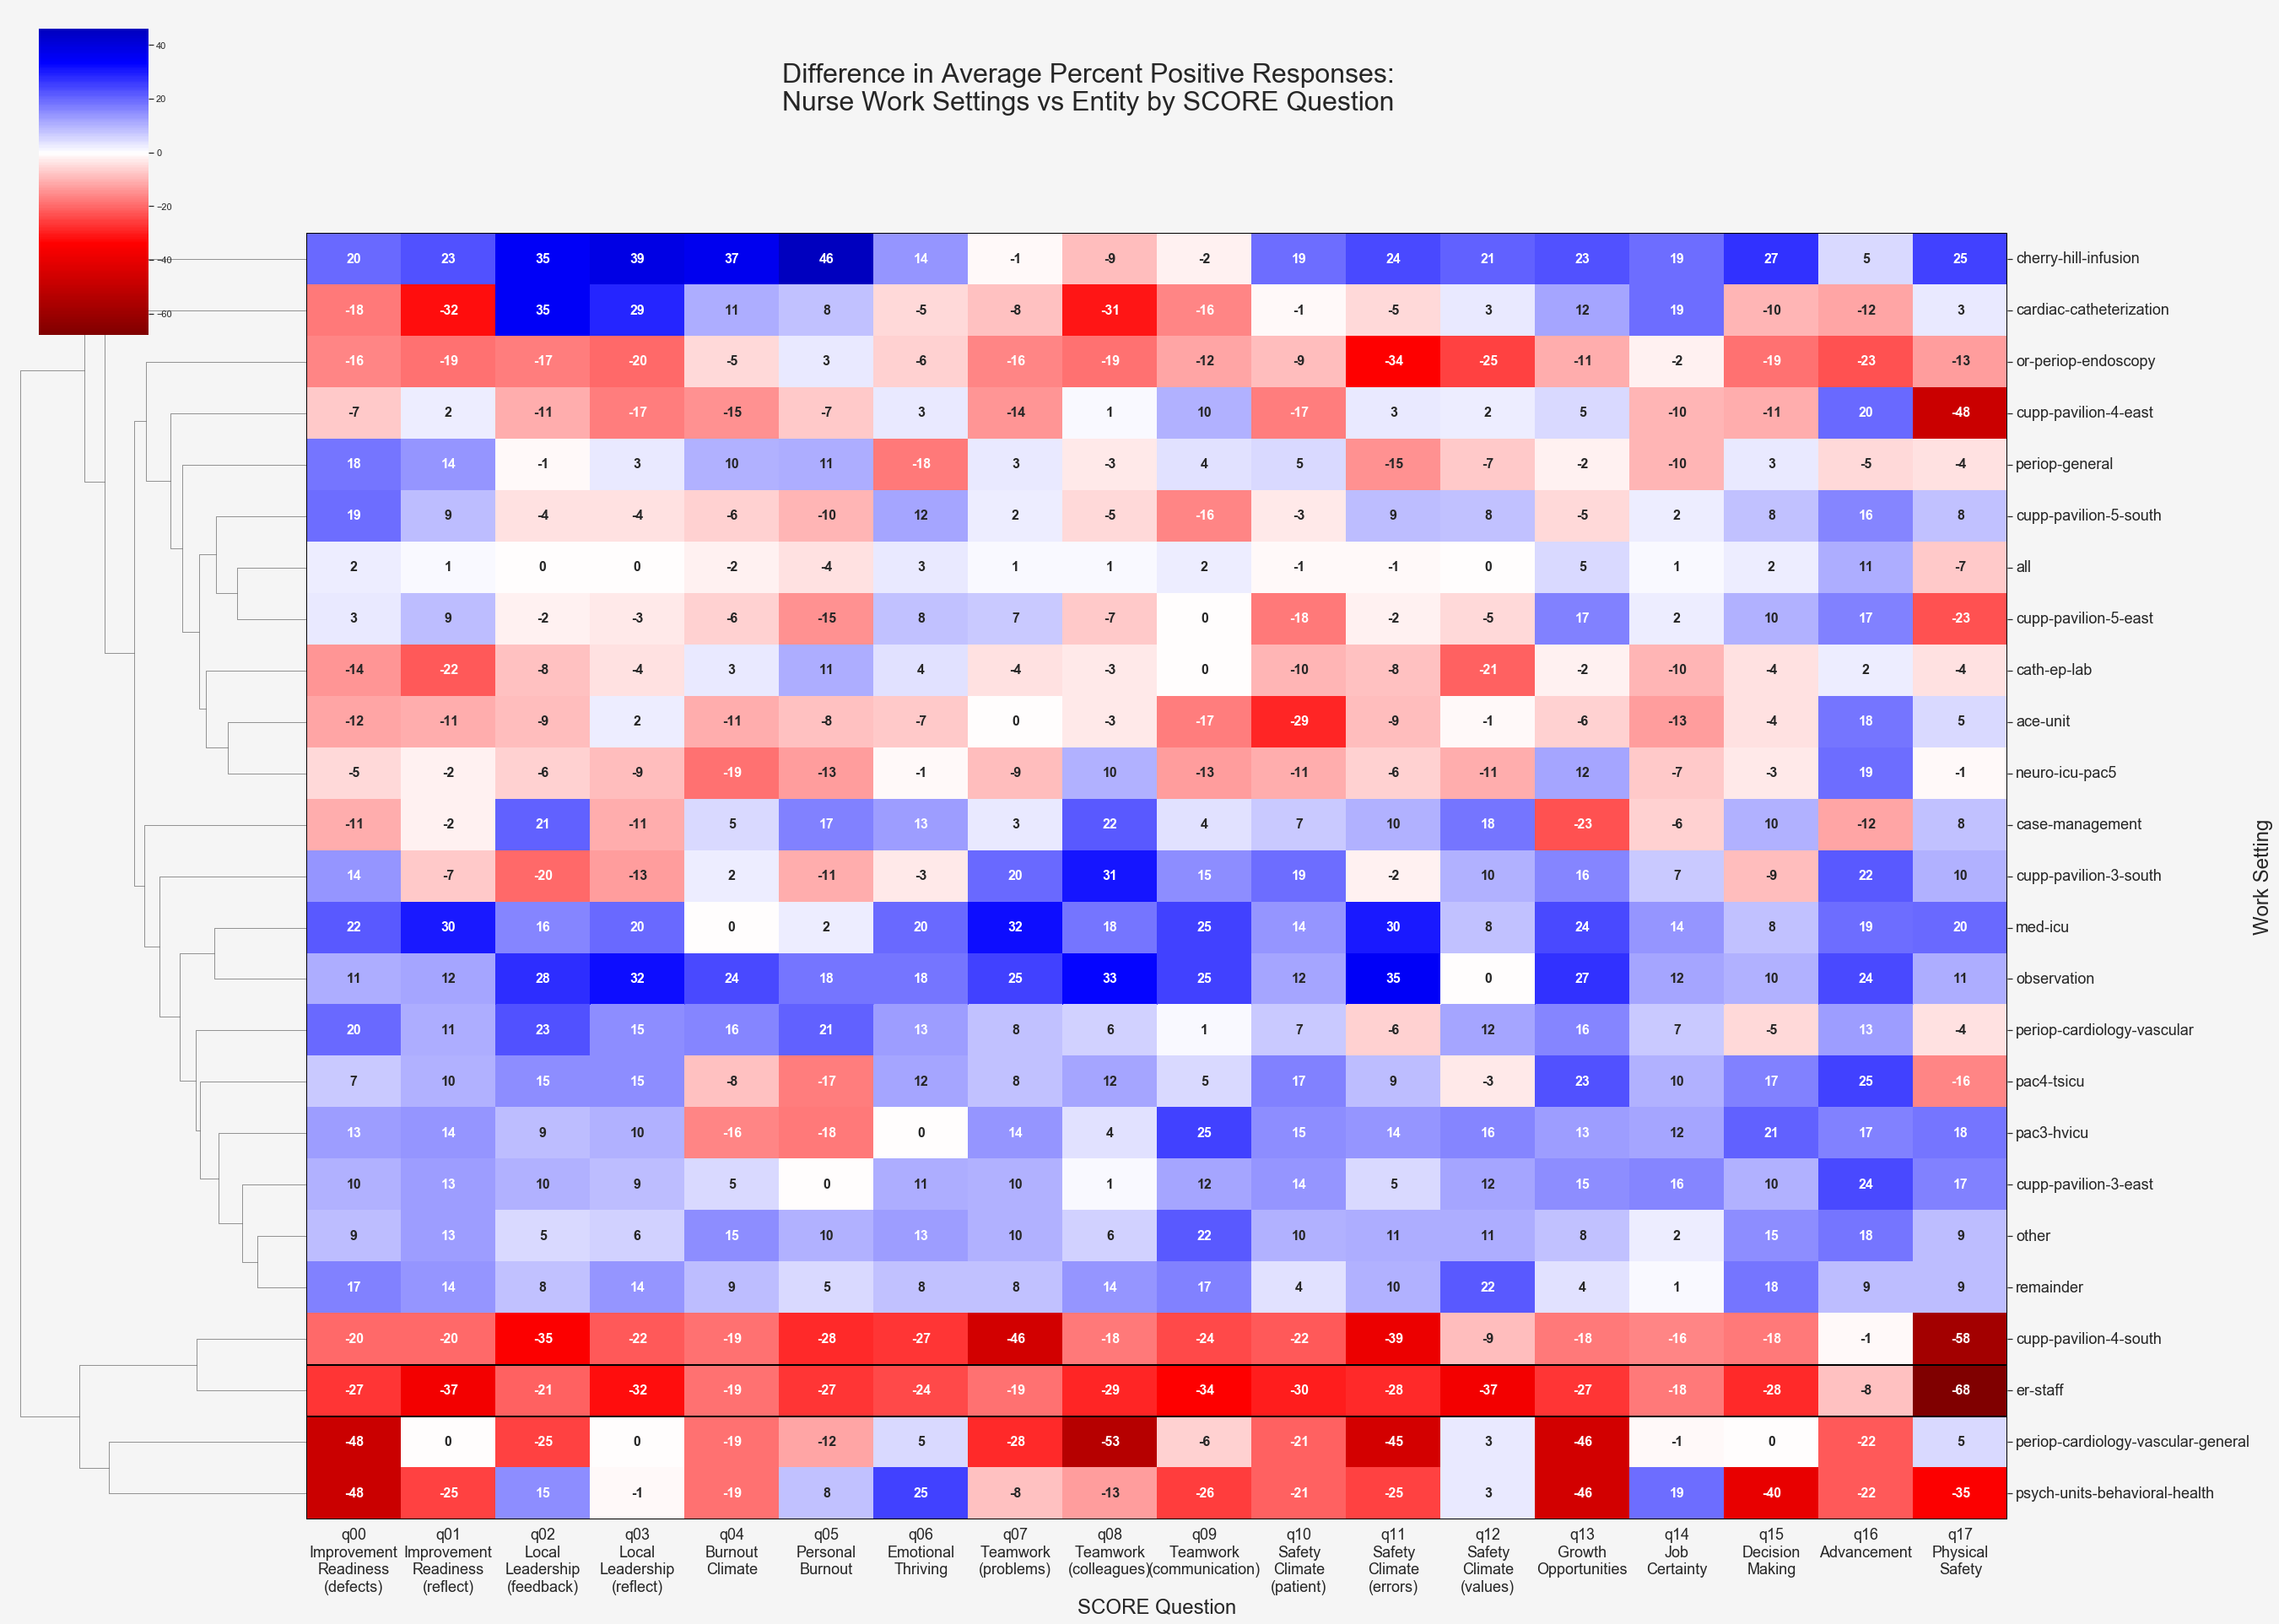

In [58]:
sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'whitesmoke'})

data = score_nurse_qid_data_grouped.fillna(0)
a = sns.clustermap(data,figsize=(36,28),annot=True,annot_kws={'fontsize':16,'weight':'bold'},
                   cmap='seismic_r',center=0,dendrogram_ratio=[0.15,0.15], col_cluster=False)

# labels
title = 'Difference in Average Percent Positive Responses:\nNurse Work Settings vs Entity by SCORE Question'
a.fig.suptitle(title, x=0.5, y=0.96, fontsize=32)
a.ax_heatmap.set_xlabel('SCORE Question', fontsize=24)
a.ax_heatmap.set_ylabel('Work Setting', fontsize=24)

# tick labels
xticklabels = ['\n'.join(item.get_text().split()) for item in a.ax_heatmap.get_xticklabels()]
yticklabels = a.ax_heatmap.get_yticklabels()
a.ax_heatmap.set_xticklabels(xticklabels, rotation=0, ha='center', fontsize=18)
a.ax_heatmap.set_yticklabels(yticklabels, rotation=0, va='center', fontsize=18)

# bounding boxes
ax = a.ax_heatmap
ax.add_patch(Rectangle((0, 0), len(data.columns), len(data), fill=False, edgecolor='black', lw=2))
ax.add_patch(Rectangle((0, 22), len(data.columns), 1, fill=False, edgecolor='black', lw=2))

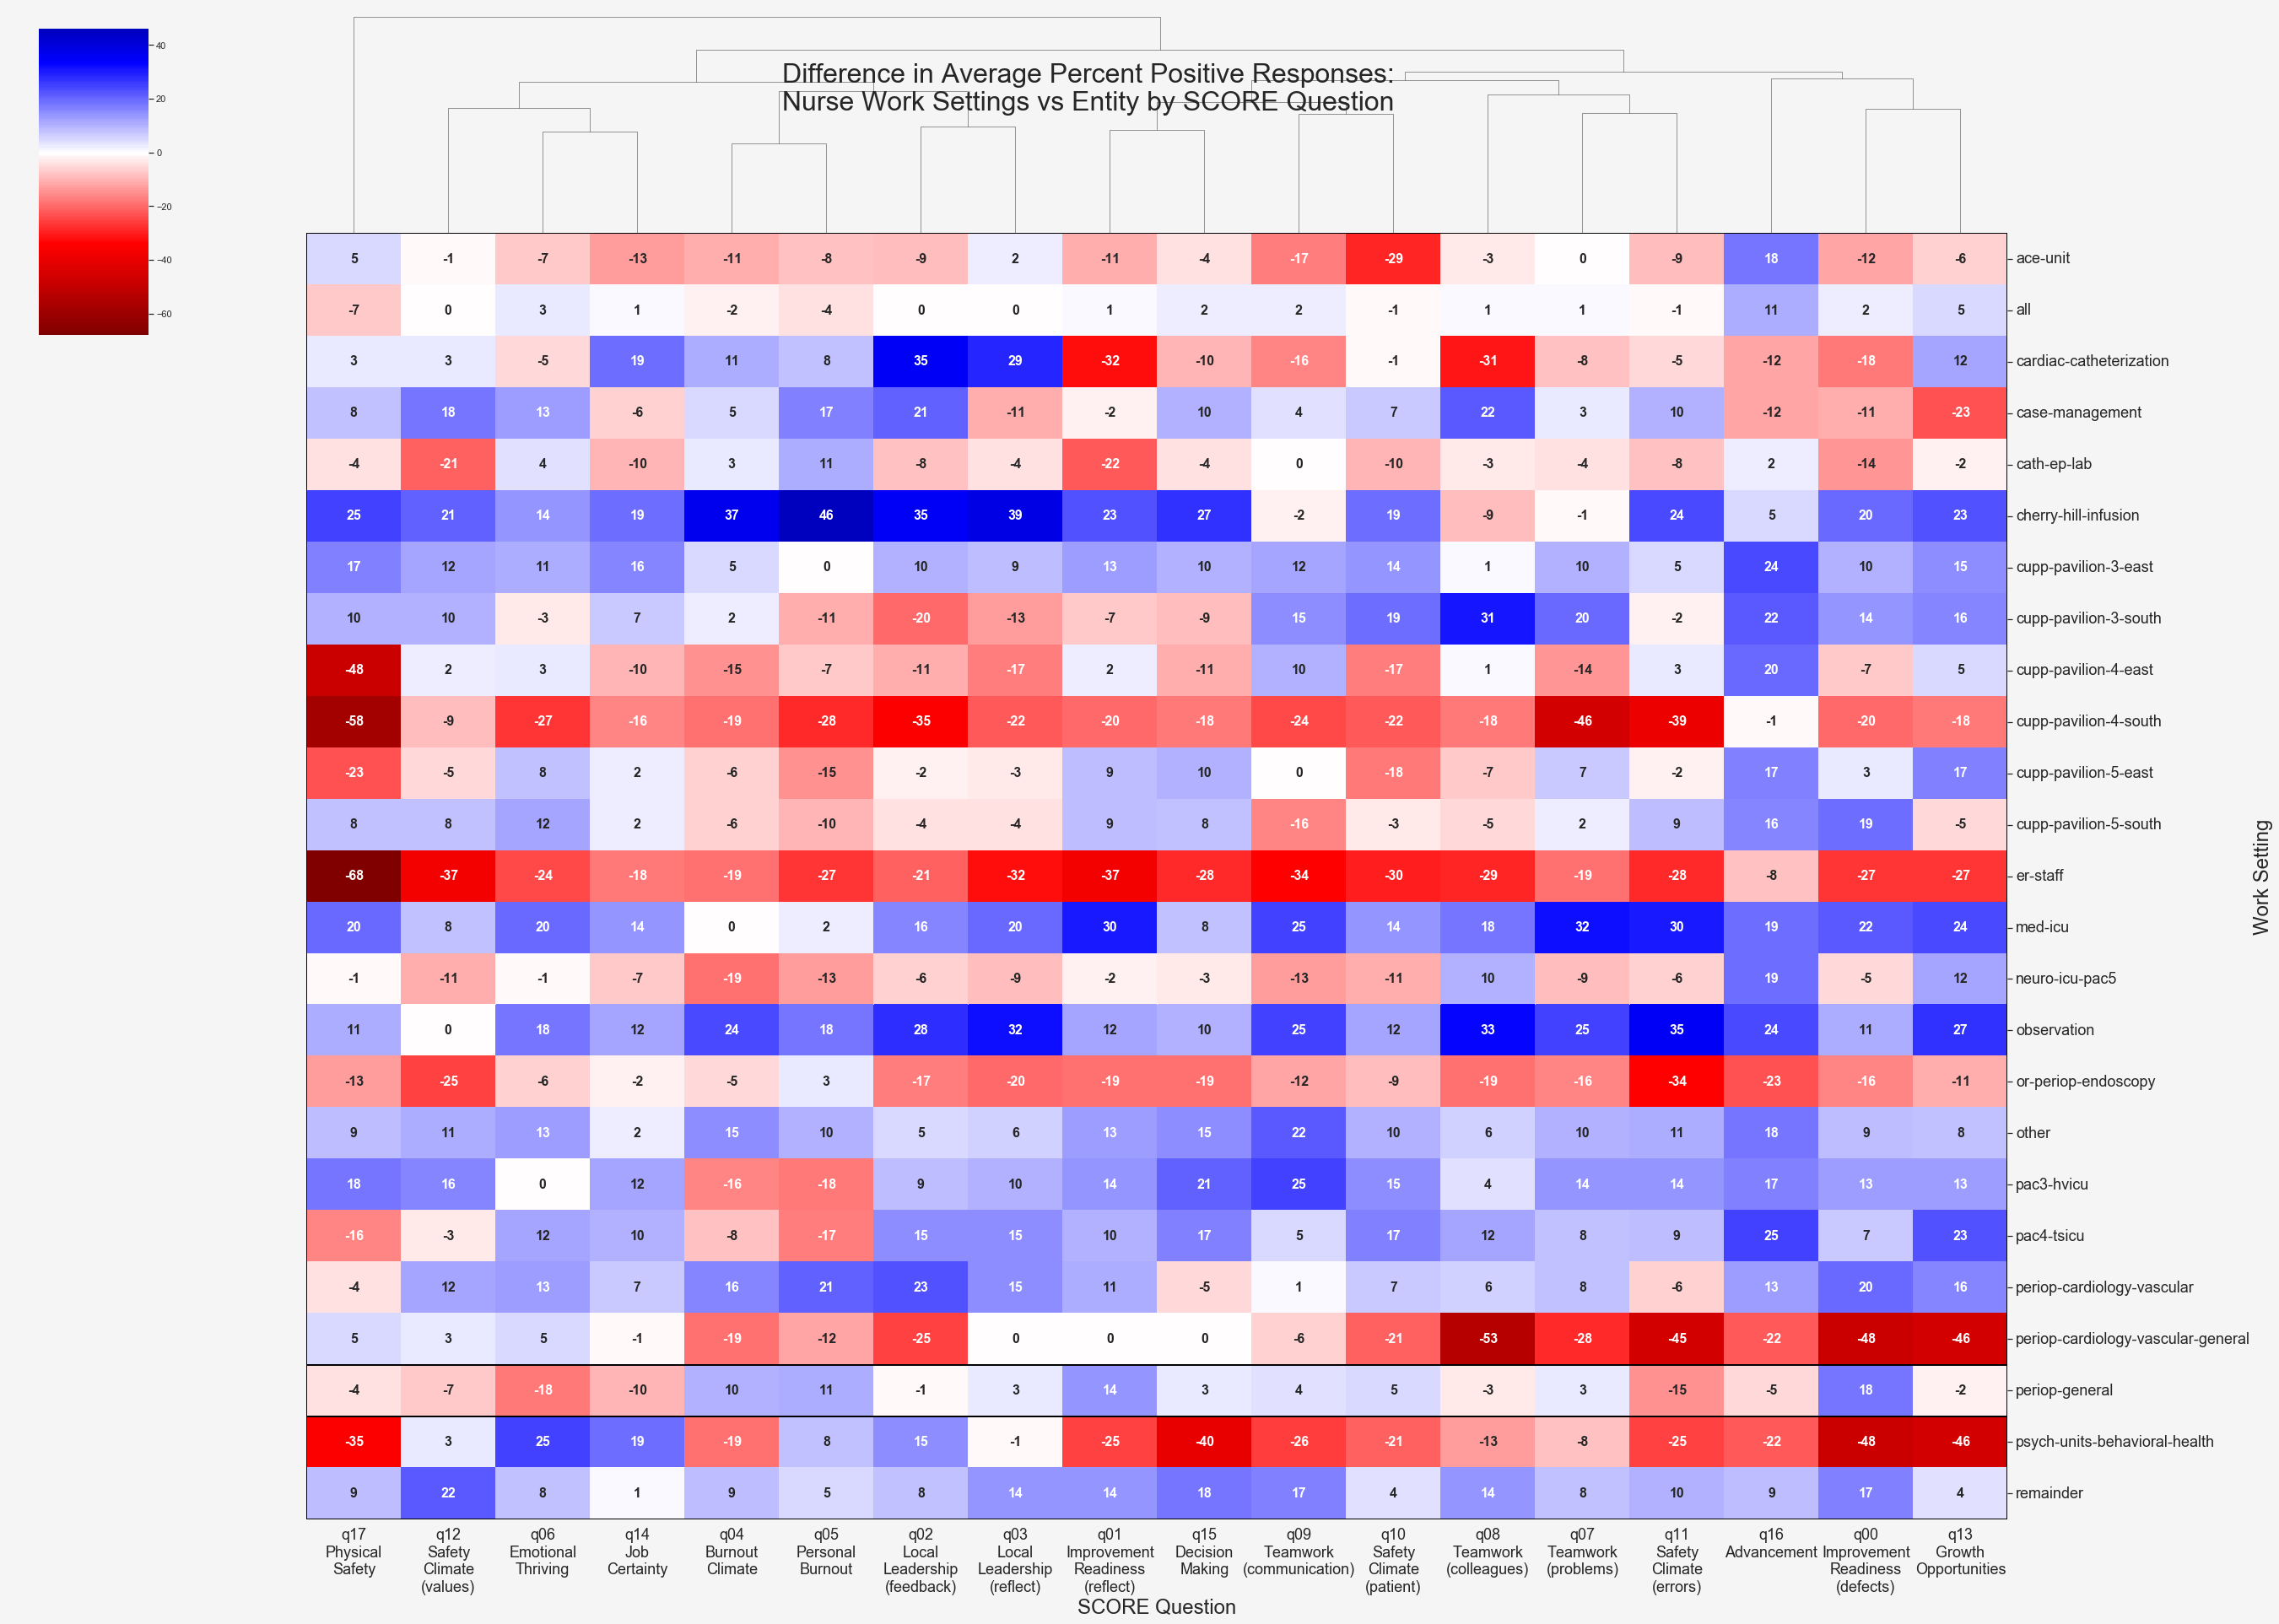

In [59]:
sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'whitesmoke'})

data = score_nurse_qid_data_grouped.fillna(0)
a = sns.clustermap(data,figsize=(36,28),annot=True,annot_kws={'fontsize':16,'weight':'bold'},
                   cmap='seismic_r',center=0,dendrogram_ratio=[0.15,0.15], row_cluster=False)

# labels
title = 'Difference in Average Percent Positive Responses:\nNurse Work Settings vs Entity by SCORE Question'
a.fig.suptitle(title, x=0.5, y=0.96, fontsize=32)
a.ax_heatmap.set_xlabel('SCORE Question', fontsize=24)
a.ax_heatmap.set_ylabel('Work Setting', fontsize=24)

# tick labels
xticklabels = ['\n'.join(item.get_text().split()) for item in a.ax_heatmap.get_xticklabels()]
yticklabels = a.ax_heatmap.get_yticklabels()
a.ax_heatmap.set_xticklabels(xticklabels, rotation=0, ha='center', fontsize=18)
a.ax_heatmap.set_yticklabels(yticklabels, rotation=0, va='center', fontsize=18)

# bounding boxes
ax = a.ax_heatmap
ax.add_patch(Rectangle((0, 0), len(data.columns), len(data), fill=False, edgecolor='black', lw=2))
ax.add_patch(Rectangle((0, 22), len(data.columns), 1, fill=False, edgecolor='black', lw=2))

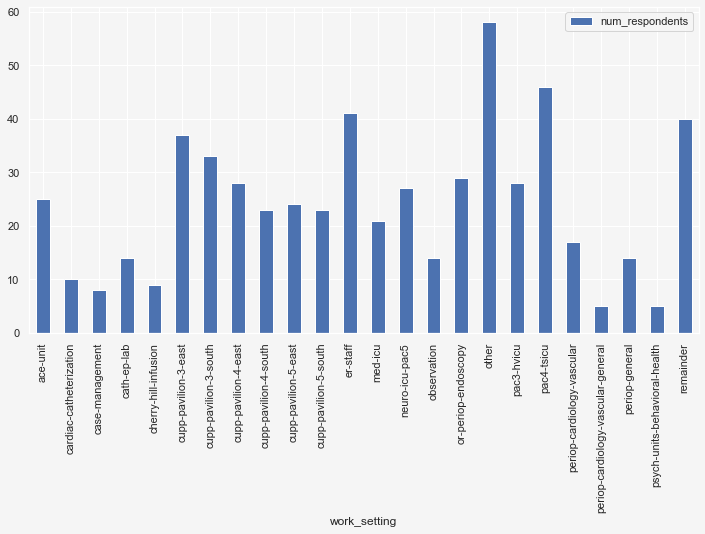

In [60]:
data = score_nurse_grouped[score_nurse_grouped.index != 'all'][['num_respondents']]
data.plot(kind='bar', figsize=(12,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118cb6290>]],
      dtype=object)

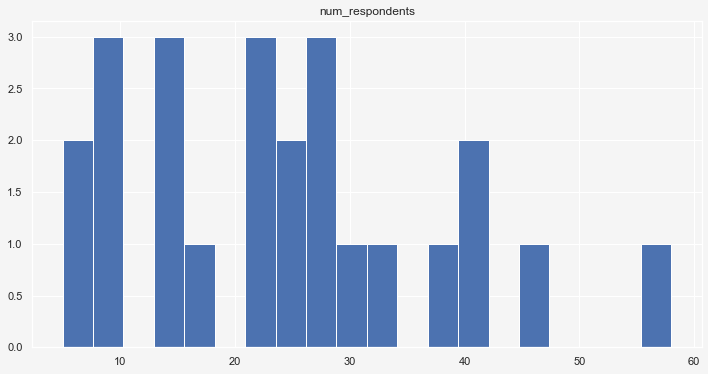

In [61]:
data = score_nurse_grouped[score_nurse_grouped.index != 'all'][['num_respondents']]
data.hist(bins=20,figsize=(12,6))

In [62]:
score_nurse_qc_data_grouped.corr()

question_category      Advancement  Burnout Climate  Decision Making  \
question_category                                                      
Advancement                 1.0000           0.1791           0.5321   
Burnout Climate             0.1791           1.0000           0.5232   
Decision Making             0.5321           0.5232           1.0000   
Emotional Thriving          0.2437           0.3591           0.3783   
Growth Opportunities        0.7833           0.5485           0.6107   
Improvement Readiness       0.7245           0.5632           0.7295   
Job Certainty               0.1459           0.4398           0.3059   
Local Leadership            0.2645           0.7298           0.5233   
Personal Burnout           -0.1215           0.8499           0.2972   
Physical Safety             0.2881           0.5749           0.7052   
Safety Climate              0.5699           0.6551           0.7676   
Teamwork                    0.6863           0.4810           0.5991   

question_category      Emotional Thriving  Growth Opportunities  \
question_category                                                 
Advancement                        0.2437                0.7833   
Burnout Climate                    0.3591                0.5485   
Decision Making                    0.3783                0.6107   
Emotional Thriving                 1.0000                0.2402   
Growth Opportunities               0.2402                1.0000   
Improvement Readiness              0.3466                0.8060   
Job Certainty                      0.6800                0.4064   
Local Leadership                   0.6007                0.5923   
Personal Burnout                   0.5111                0.2353   
Physical Safety                    0.5048                0.4552   
Safety Climate                     0.6232                0.6902   
Teamwork                           0.5244                0.6999   

question_category      Improvement Readiness  Job Certainty  Local Leadership  \
question_category                                                               
Advancement                           0.7245         0.1459            0.2645   
Burnout Climate                       0.5632         0.4398            0.7298   
Decision Making                       0.7295         0.3059            0.5233   
Emotional Thriving                    0.3466         0.6800            0.6007   
Growth Opportunities                  0.8060         0.4064            0.5923   
Improvement Readiness                 1.0000         0.3223            0.5428   
Job Certainty                         0.3223         1.0000            0.7568   
Local Leadership                      0.5428         0.7568            1.0000   
Personal Burnout                      0.3264         0.4367            0.6961   
Physical Safety                       0.5249         0.5371            0.5836   
Safety Climate                        0.8063         0.6405            0.7571   
Teamwork                              0.7876         0.3885            0.5114   

question_category      Personal Burnout  Physical Safety  Safety Climate  \
question_category                                                          
Advancement                     -0.1215           0.2881          0.5699   
Burnout Climate                  0.8499           0.5749          0.6551   
Decision Making                  0.2972           0.7052          0.7676   
Emotional Thriving               0.5111           0.5048          0.6232   
Growth Opportunities             0.2353           0.4552          0.6902   
Improvement Readiness            0.3264           0.5249          0.8063   
Job Certainty                    0.4367           0.5371          0.6405   
Local Leadership                 0.6961           0.5836          0.7571   
Personal Burnout                 1.0000           0.5133          0.5024   
Physical Safety                  0.5133           1.0000          0.7341   
Safet

In [63]:

score_nurse_qc_data_grouped.transpose().corr()

work_setting                        ace-unit     all  cardiac-catheterization  \
work_setting                                                                    
ace-unit                              1.0000  0.4212                  -0.1578   
all                                   0.4212  1.0000                  -0.2927   
cardiac-catheterization              -0.1578 -0.2927                   1.0000   
case-management                      -0.2417 -0.6124                  -0.0459   
cath-ep-lab                           0.3104 -0.0021                   0.1751   
cherry-hill-infusion                 -0.3020 -0.5680                   0.5949   
cupp-pavilion-3-east                  0.6516  0.5650                  -0.1297   
cupp-pavilion-3-south                 0.3280  0.4062                  -0.4247   
cupp-pavilion-4-east                  0.1108  0.8670                  -0.3130   
cupp-pavilion-4-south                 0.0652  0.8137                  -0.1363   
cupp-pavilion-5-east                  0.1915  0.9255                  -0.2658   
cupp-pavilion-5-south                 0.4222  0.4063                  -0.5493   
er-staff                             -0.0214  0.7127                   0.0270   
med-icu                               0.1817  0.3569                  -0.3547   
neuro-icu-pac5                        0.7196  0.7508                  -0.2857   
observation                           0.1807  0.3320                   0.3112   
or-periop-endoscopy                  -0.4080 -0.4059                   0.3852   
other                                 0.4373  0.3739                  -0.6510   
pac3-hvicu                            0.3368  0.3460                  -0.3109   
pac4-tsicu                            0.2238  0.8816                  -0.1310   
periop-cardiology-vascular           -0.1341  0.2014                   0.3066   
periop-cardiology-vascular-general    0.1239 -0.3415                   0.1766   
periop-general                       -0.2028 -0.2709                  -0.1713   
psych-units-behavioral-health        -0.2516 -0.0975                   0.4027   
remainder                             0.0481  0.0211                  -0.5909   

work_setting                        case-management  cath-ep-lab  \
work_setting                                                       
ace-unit                                    -0.2417       0.3104   
all                                         -0.6124      -0.0021   
cardiac-catheterization                     -0.0459       0.1751   
case-management                              1.0000       0.2699   
cath-ep-lab                                  0.2699       1.0000   
cherry-hill-infusion                         0.2485       0.2102   
cupp-pavilion-3-east                        -0.6451      -0.2949   
cupp-pavilion-3-south                       -0.5014      -0.1380   
cupp-pavilion-4-east                        -0.3921       0.1155   
cupp-pavilion-4-south                       -0.4896      -0.0088   
cupp-pavilion-5-east                        -0.6439      -0.0813   
cupp-pavilion-5-south                       -0.1667      -0.3686   
er-staff                                    -0.2836       0.2089   
med-icu                                     -0.4237      -0.5152   
neuro-icu-pac5                              -0.6643       0.0138   
observation                                 -0.2263       0.3602   
or-periop-endoscopy                          0.1803       0.5213   
other                                        0.1428       0.3581   
pac3-hvicu                                  -0.3527      -0.6376   
pac4-tsicu                                  -0.5808      -0.2853   
periop-cardiology-vascular                  -0.2391       0.3022   
periop-cardiology-vascular-general           0.5737       0.3337   
periop-general                               0.0168      -0.0654   
psych-units-behavioral-health                0.4135       0.2743   
remainder                                   

In [64]:
score_nurse_qid_data_grouped.corr()

q00 Improvement Readiness (defects)  \
q00 Improvement Readiness (defects)                               1.0000   
q01 Improvement Readiness (reflect)                               0.8749   
q02 Local Leadership (feedback)                                   0.3909   
q03 Local Leadership (reflect)                                    0.5084   
q04 Burnout Climate                                               0.5900   
q05 Personal Burnout                                              0.2903   
q06 Emotional Thriving                                            0.2331   
q07 Teamwork (problems)                                           0.7198   
q08 Teamwork (colleagues)                                         0.6721   
q09 Teamwork (communication)                                      0.6561   
q10 Safety Climate (patient)                                      0.7539   
q11 Safety Climate (errors)                                       0.7526   
q12 Safety Climate (values)                                       0.4648   
q13 Growth Opportunities                                          0.8280   
q14 Job Certainty                                                 0.2784   
q15 Decision Making                                               0.7052   
q16 Advancement                                                   0.7171   
q17 Physical Safety                                               0.5343   

                                     q01 Improvement Readiness (reflect)  \
q00 Improvement Readiness (defects)                               0.8749   
q01 Improvement Readiness (reflect)                               1.0000   
q02 Local Leadership (feedback)                                   0.4120   
q03 Local Leadership (reflect)                                    0.5498   
q04 Burnout Climate                                               0.4570   
q05 Personal Burnout                                              0.3198   
q06 Emotional Thriving                                            0.5190   
q07 Teamwork (problems)                                           0.6750   
q08 Teamwork (colleagues)                                         0.5990   
q09 Teamwork (communication)                                      0.7502   
q10 Safety Climate (patient)                                      0.6828   
q11 Safety Climate (errors)                                       0.7626   
q12 Safety Climate (values)                                       0.6427   
q13 Growth Opportunities                                          0.6663   
q14 Job Certainty                                                 0.3706   
q15 Decision Making                                               0.8170   
q16 Advancement                                                   0.6321   
q17 Physical Safety                                               0.6095   

                                     q02 Local Leadership (feedback)  \
q00 Improvement Readiness (defects)                           0.3909   
q01 Improvement Readiness (reflect)                           0.4120   
q02 Local Leadership (feedback)                               1.0000   
q03 Local Leadership (reflect)                                0.8654   
q04 Burnout Climate                                           0.6754   
q05 Personal Burnout                                          0.7096   
q06 Emotional Thriving                                        0.6403   
q07 Teamwork (problems)                                       0.5757   
q08 Teamwork (colleagues)                                     0.3410   
q09 Teamwork (communication)                                  0.3522   
q10 Safety Climate (patient)                                  0.6041   
q11 Safety Climate (errors)                                   0.6908   
q12 Safety Climate (values)                                   0.5488   
q13 Growth Opportunities                                      0.4732   
q14 Job Certainty                                             0.736

In [65]:
score_nurse_qid_data_grouped.transpose().corr()

work_setting                        ace-unit     all  cardiac-catheterization  \
work_setting                                                                    
ace-unit                              1.0000  0.3256                   0.0007   
all                                   0.3256  1.0000                  -0.2461   
cardiac-catheterization               0.0007 -0.2461                   1.0000   
case-management                      -0.1501 -0.4946                  -0.0554   
cath-ep-lab                           0.2083  0.0346                   0.1808   
cherry-hill-infusion                 -0.1122 -0.4613                   0.6457   
cupp-pavilion-3-east                  0.2934  0.4918                   0.0280   
cupp-pavilion-3-south                 0.0844  0.3140                  -0.5036   
cupp-pavilion-4-east                  0.0710  0.7787                  -0.3617   
cupp-pavilion-4-south                 0.0369  0.6646                  -0.1461   
cupp-pavilion-5-east                  0.2945  0.8528                  -0.2004   
cupp-pavilion-5-south                 0.3826  0.2970                  -0.3219   
er-staff                              0.0095  0.6559                   0.0918   
med-icu                               0.0816  0.2634                  -0.3621   
neuro-icu-pac5                        0.5644  0.6475                  -0.3067   
observation                           0.1464  0.1735                   0.1289   
or-periop-endoscopy                  -0.3718 -0.2505                   0.2635   
other                                 0.0696  0.3171                  -0.4743   
pac3-hvicu                            0.0894  0.3126                  -0.2454   
pac4-tsicu                            0.0422  0.7842                  -0.0725   
periop-cardiology-vascular           -0.0071  0.1852                   0.3605   
periop-cardiology-vascular-general    0.0612 -0.2332                   0.2683   
periop-general                       -0.2692 -0.1593                  -0.1908   
psych-units-behavioral-health        -0.0111 -0.1112                   0.4437   
remainder                             0.1724  0.0579                  -0.4167   

work_setting                        case-management  cath-ep-lab  \
work_setting                                                       
ace-unit                                    -0.1501       0.2083   
all                                         -0.4946       0.0346   
cardiac-catheterization                     -0.0554       0.1808   
case-management                              1.0000       0.0630   
cath-ep-lab                                  0.0630       1.0000   
cherry-hill-infusion                         0.0056       0.0627   
cupp-pavilion-3-east                        -0.5437      -0.2390   
cupp-pavilion-3-south                       -0.2073      -0.0242   
cupp-pavilion-4-east                        -0.1586       0.0209   
cupp-pavilion-4-south                       -0.2897      -0.1198   
cupp-pavilion-5-east                        -0.5316      -0.0501   
cupp-pavilion-5-south                       -0.1834      -0.3968   
er-staff                                    -0.1858       0.2447   
med-icu                                     -0.3502      -0.2970   
neuro-icu-pac5                              -0.3333       0.0717   
observation                                 -0.0742       0.4564   
or-periop-endoscopy                         -0.0148       0.4844   
other                                       -0.0161       0.2423   
pac3-hvicu                                  -0.2743      -0.5198   
pac4-tsicu                                  -0.4202      -0.1610   
periop-cardiology-vascular                  -0.1626       0.0882   
periop-cardiology-vascular-general           0.2607       0.0814   
periop-general                              -0.2032      -0.1042   
psych-units-behavioral-health                0.4408       0.1473   
remainder                                   

## ER Work Setting
* Positions: nurse, physician (resident, fellow, attending), remainder*
    * Remainder includes all remaining positions in the ER setting that did not have enough respondents to be reported explicitly.

In [66]:
use_cols = ['num_respondents','group_pct_pos','entity_pct_pos','group_entity_pct_pos_diff']
score_er_grouped = score_er[score_er['question_category']!='GME Questions'].groupby(['position']).mean()[use_cols]
score_er_grouped_sorted = score_er_grouped.sort_values('group_entity_pct_pos_diff')

In [67]:
score_er_grouped.head()

num_respondents  group_pct_pos  \
position                                                              
all                                             57.0        38.3889   
nurse                                           41.0        31.4444   
physician-resident-fellow-attending              7.0        65.0556   
remainder                                        9.0        49.7778   

                                     entity_pct_pos  group_entity_pct_pos_diff  
position                                                                        
all                                         59.9444                   -21.5556  
nurse                                       59.9444                   -28.5000  
physician-resident-fellow-attending         59.9444                     5.1111  
remainder                                   59.9444                   -10.1667

In [68]:
score_er_grouped_sorted.head()

num_respondents  group_pct_pos  \
position                                                              
nurse                                           41.0        31.4444   
all                                             57.0        38.3889   
remainder                                        9.0        49.7778   
physician-resident-fellow-attending              7.0        65.0556   

                                     entity_pct_pos  group_entity_pct_pos_diff  
position                                                                        
nurse                                       59.9444                   -28.5000  
all                                         59.9444                   -21.5556  
remainder                                   59.9444                   -10.1667  
physician-resident-fellow-attending         59.9444                     5.1111

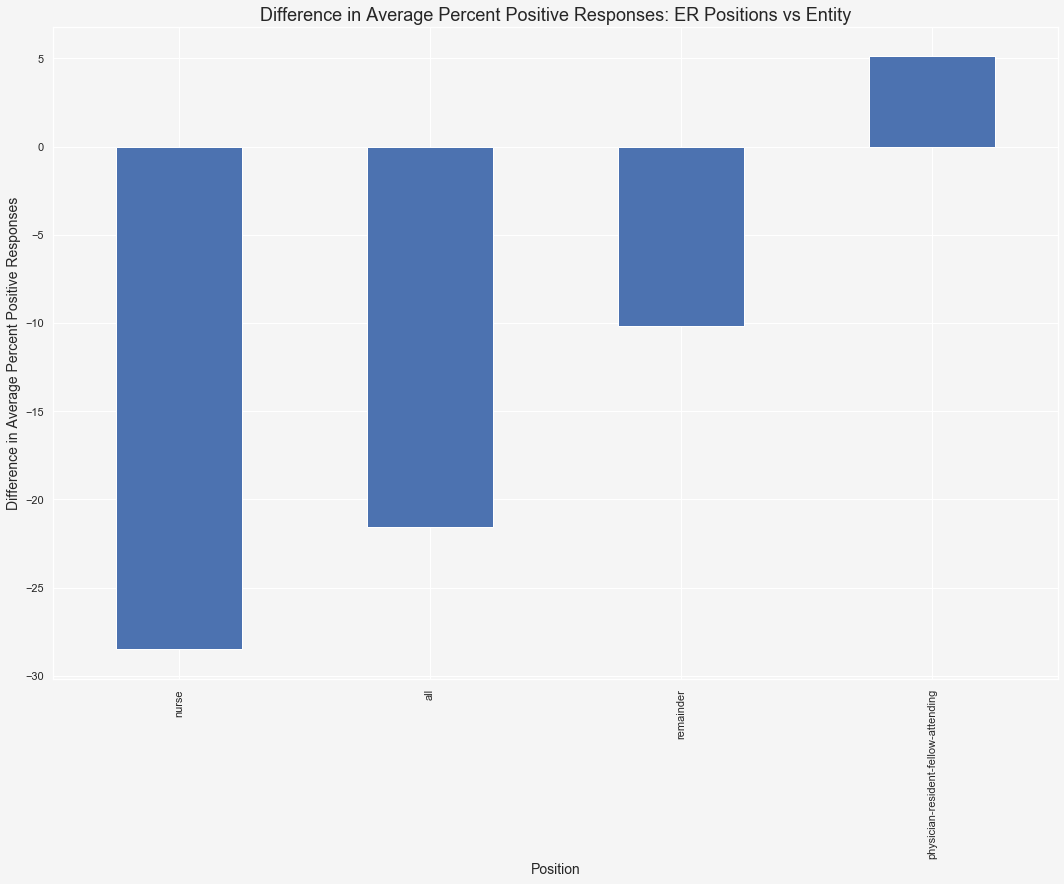

In [69]:
fig, ax = plt.subplots(figsize=(18,12), facecolor='whitesmoke')
plt.grid(False)
score_er_grouped_sorted['group_entity_pct_pos_diff'].plot(kind='bar',figsize=(18,12))
ax.set_title('Difference in Average Percent Positive Responses: ER Positions vs Entity', fontsize=18)
ax.set_xlabel('Position', fontsize=14)
ax.set_ylabel('Difference in Average Percent Positive Responses', fontsize=14)

save_figure(fig,FIGURE_PATH,'score_er_pct_pos_')

### ER Work Setting: Question Category and Question ID - Entity Comparison

In [70]:
score_er_qc_data = score_er[score_er['question_category']!='GME Questions']
score_er_qc_data_grouped = score_er_qc_data.groupby(['position','question_category']).mean()['group_entity_pct_pos_diff'].unstack()
score_er_qid_data_grouped = score_er_qc_data.groupby(['position','question_id']).mean()['group_entity_pct_pos_diff'].unstack()
score_er_qid_data_grouped.columns = [col+' '+qid_cat_label_dict[col] for col in score_er_qid_data_grouped.columns]

In [71]:
print(len(score_er_qc_data_grouped))
print(len(score_er_qc_data_grouped.columns))
score_er_qc_data_grouped.head()

4
12


question_category                    Advancement  Burnout Climate  \
position                                                            
all                                         -2.0            -18.0   
nurse                                       -8.0            -19.0   
physician-resident-fellow-attending         38.0            -19.0   
remainder                                   -6.0             -8.0   

question_category                    Decision Making  Emotional Thriving  \
position                                                                   
all                                            -21.0               -18.0   
nurse                                          -28.0               -24.0   
physician-resident-fellow-attending             17.0                11.0   
remainder                                      -18.0               -12.0   

question_category                    Growth Opportunities  \
position                                                    
all                                                 -19.0   
nurse                                               -27.0   
physician-resident-fellow-attending                  20.0   
remainder                                           -10.0   

question_category                    Improvement Readiness  Job Certainty  \
position                                                                    
all                                                  -23.0           -9.0   
nurse                                                -32.0          -18.0   
physician-resident-fellow-attending                   19.0           19.0   
remainder                                            -13.5            8.0   

question_category                    Local Leadership  Personal Burnout  \
position                                                                  
all                                             -24.0             -21.0   
nurse                                           -26.5             -27.0   
physician-resident-fellow-attending               1.0              -3.0   
remainder                                       -34.0             -10.0   

question_category                    Physical Safety  Safety Climate  Teamwork  
position                                                                        
all                                            -52.0        -23.3333  -21.3333  
nurse                                          -68.0        -31.6667  -27.3333  
physician-resident-fellow-attending             -4.0         -1.0000   -8.0000  
remainder                                      -19.0         -0.6667   -3.6667

In [72]:
print(len(score_er_qid_data_grouped))
print(len(score_er_qid_data_grouped.columns))
score_er_qid_data_grouped.head()

4
18


q00 Improvement Readiness (defects)  \
position                                                                   
all                                                                -17.0   
nurse                                                              -27.0   
physician-resident-fellow-attending                                 32.0   
remainder                                                          -12.0   

                                     q01 Improvement Readiness (reflect)  \
position                                                                   
all                                                                -29.0   
nurse                                                              -37.0   
physician-resident-fellow-attending                                  6.0   
remainder                                                          -15.0   

                                     q02 Local Leadership (feedback)  \
position                                                               
all                                                            -20.0   
nurse                                                          -21.0   
physician-resident-fellow-attending                              6.0   
remainder                                                      -40.0   

                                     q03 Local Leadership (reflect)  \
position                                                              
all                                                           -28.0   
nurse                                                         -32.0   
physician-resident-fellow-attending                            -4.0   
remainder                                                     -28.0   

                                     q04 Burnout Climate  \
position                                                   
all                                                -18.0   
nurse                                              -19.0   
physician-resident-fellow-attending                -19.0   
remainder                                           -8.0   

                                     q05 Personal Burnout  \
position                                                    
all                                                 -21.0   
nurse                                               -27.0   
physician-resident-fellow-attending                  -3.0   
remainder                                           -10.0   

                                     q06 Emotional Thriving  \
position                                                      
all                                                   -18.0   
nurse                                                 -24.0   
physician-resident-fellow-attending                    11.0   
remainder                                             -12.0   

                                     q07 Teamwork (problems)  \
position                                                       
all                                                    -14.0   
nurse                                                  -19.0   
physician-resident-fellow-attending                     18.0   
remainder                                              -12.0   

                                     q08 Teamwork (colleagues)  \
position                                                         
all                                                      -20.0   
nurse                                                    -29.0   
physician-resident-fellow-attending                      -10.0   
remainder                                                 14.0   

                                     q09 Teamwork (communication)  \
position                                                            
all                                                         -30.0   
nurse                                                       -34.0   
physician-resident-fellow-attending                         -32.0   
remainder                    

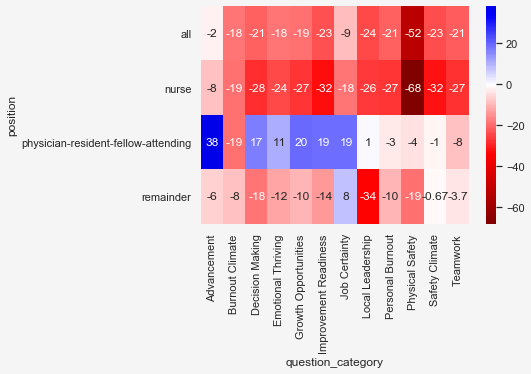

In [73]:
sns.heatmap(score_er_qc_data_grouped.fillna(0),annot=True,cmap='seismic_r',center=0)

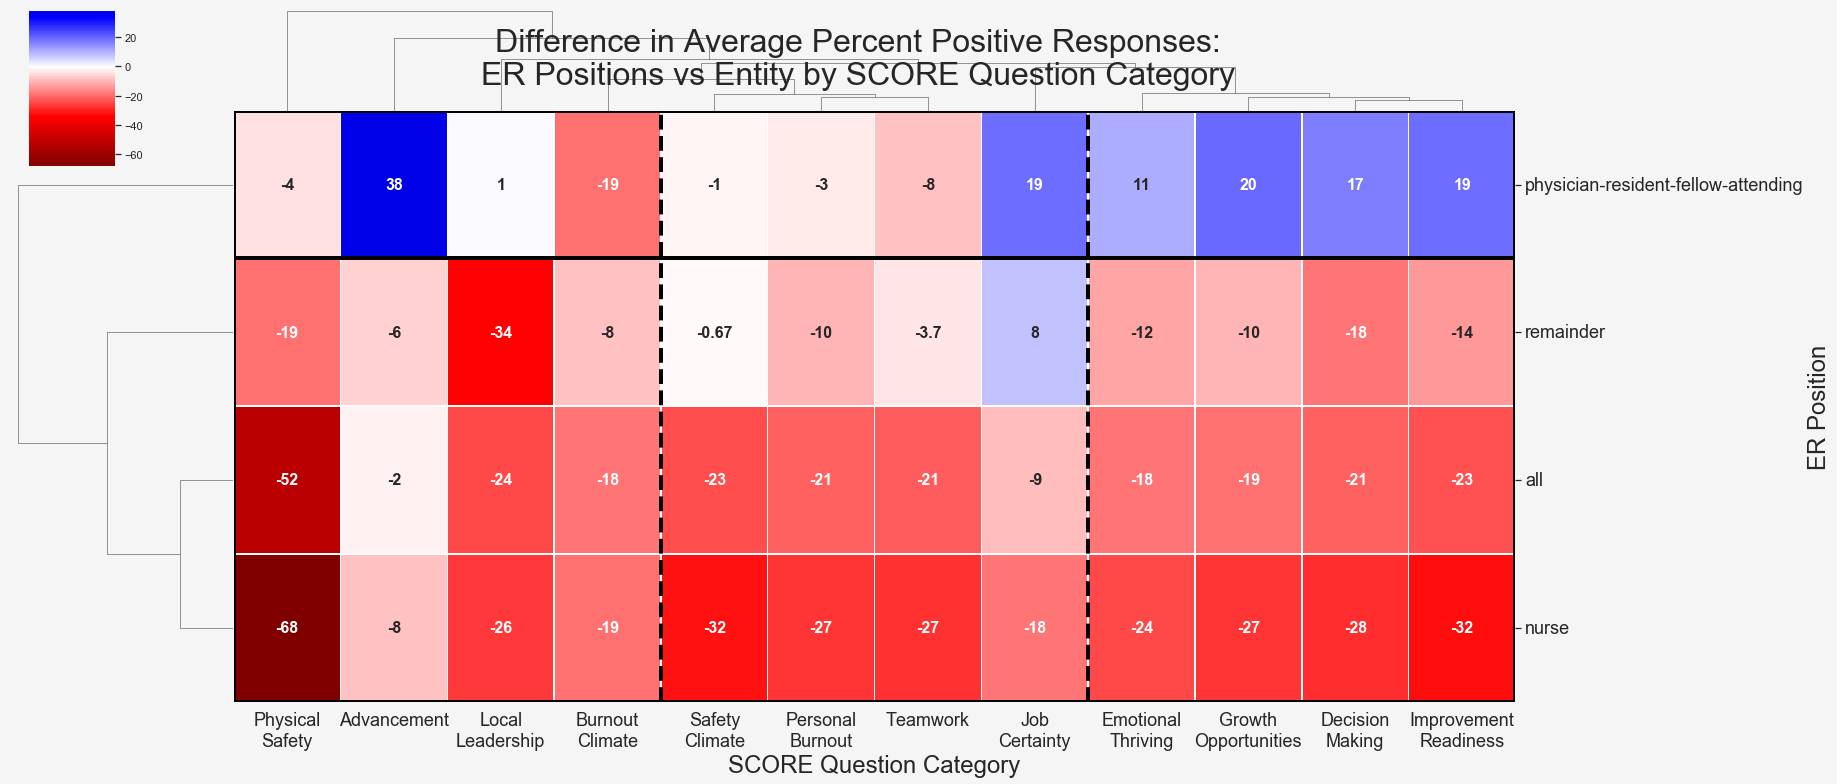

In [74]:
sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'whitesmoke'})

data = score_er_qc_data_grouped.fillna(0)
a = sns.clustermap(data,figsize=(24,12),annot=True,annot_kws={'fontsize':16,'weight':'bold'},
                   cmap='seismic_r',center=0,dendrogram_ratio=[0.15,0.15],lw=0.5)

#labels
title = 'Difference in Average Percent Positive Responses:\nER Positions vs Entity by SCORE Question Category'
a.fig.suptitle(title, x=0.5, y=0.96, fontsize=32)
a.ax_heatmap.set_xlabel('SCORE Question Category', fontsize=24)
a.ax_heatmap.set_ylabel('ER Position', fontsize=24)

# tick labels
xticklabels = ['\n'.join(item.get_text().split()) for item in a.ax_heatmap.get_xticklabels()]
yticklabels = a.ax_heatmap.get_yticklabels()
a.ax_heatmap.set_xticklabels(xticklabels, rotation=0, ha='center', fontsize=18)
a.ax_heatmap.set_yticklabels(yticklabels, rotation=0, va='center', fontsize=18)

# bounding boxes
ax = a.ax_heatmap
ax.add_patch(Rectangle((0, 0), len(data.columns), len(data), fill=False, edgecolor='black', lw=4))
#ax.add_patch(Rectangle((0, 3), len(data.columns), 1, fill=False, edgecolor='black', lw=2))

# TEMP LINES
ax.axhline(1, color='black', lw=4)
ax.axhline(11, color='black', lw=4)
ax.axhline(21, color='black', lw=4)
ax.axhline(23, color='black', lw=4)

ax.axvline(4, color='black', lw=4, ls='--')
ax.axvline(8, color='black', lw=4, ls='--')
ax.axvline(15, color='black', lw=4, ls='--')

#save_figure(a.fig,FIGURE_PATH,'score_er_qc_pct_pos_')

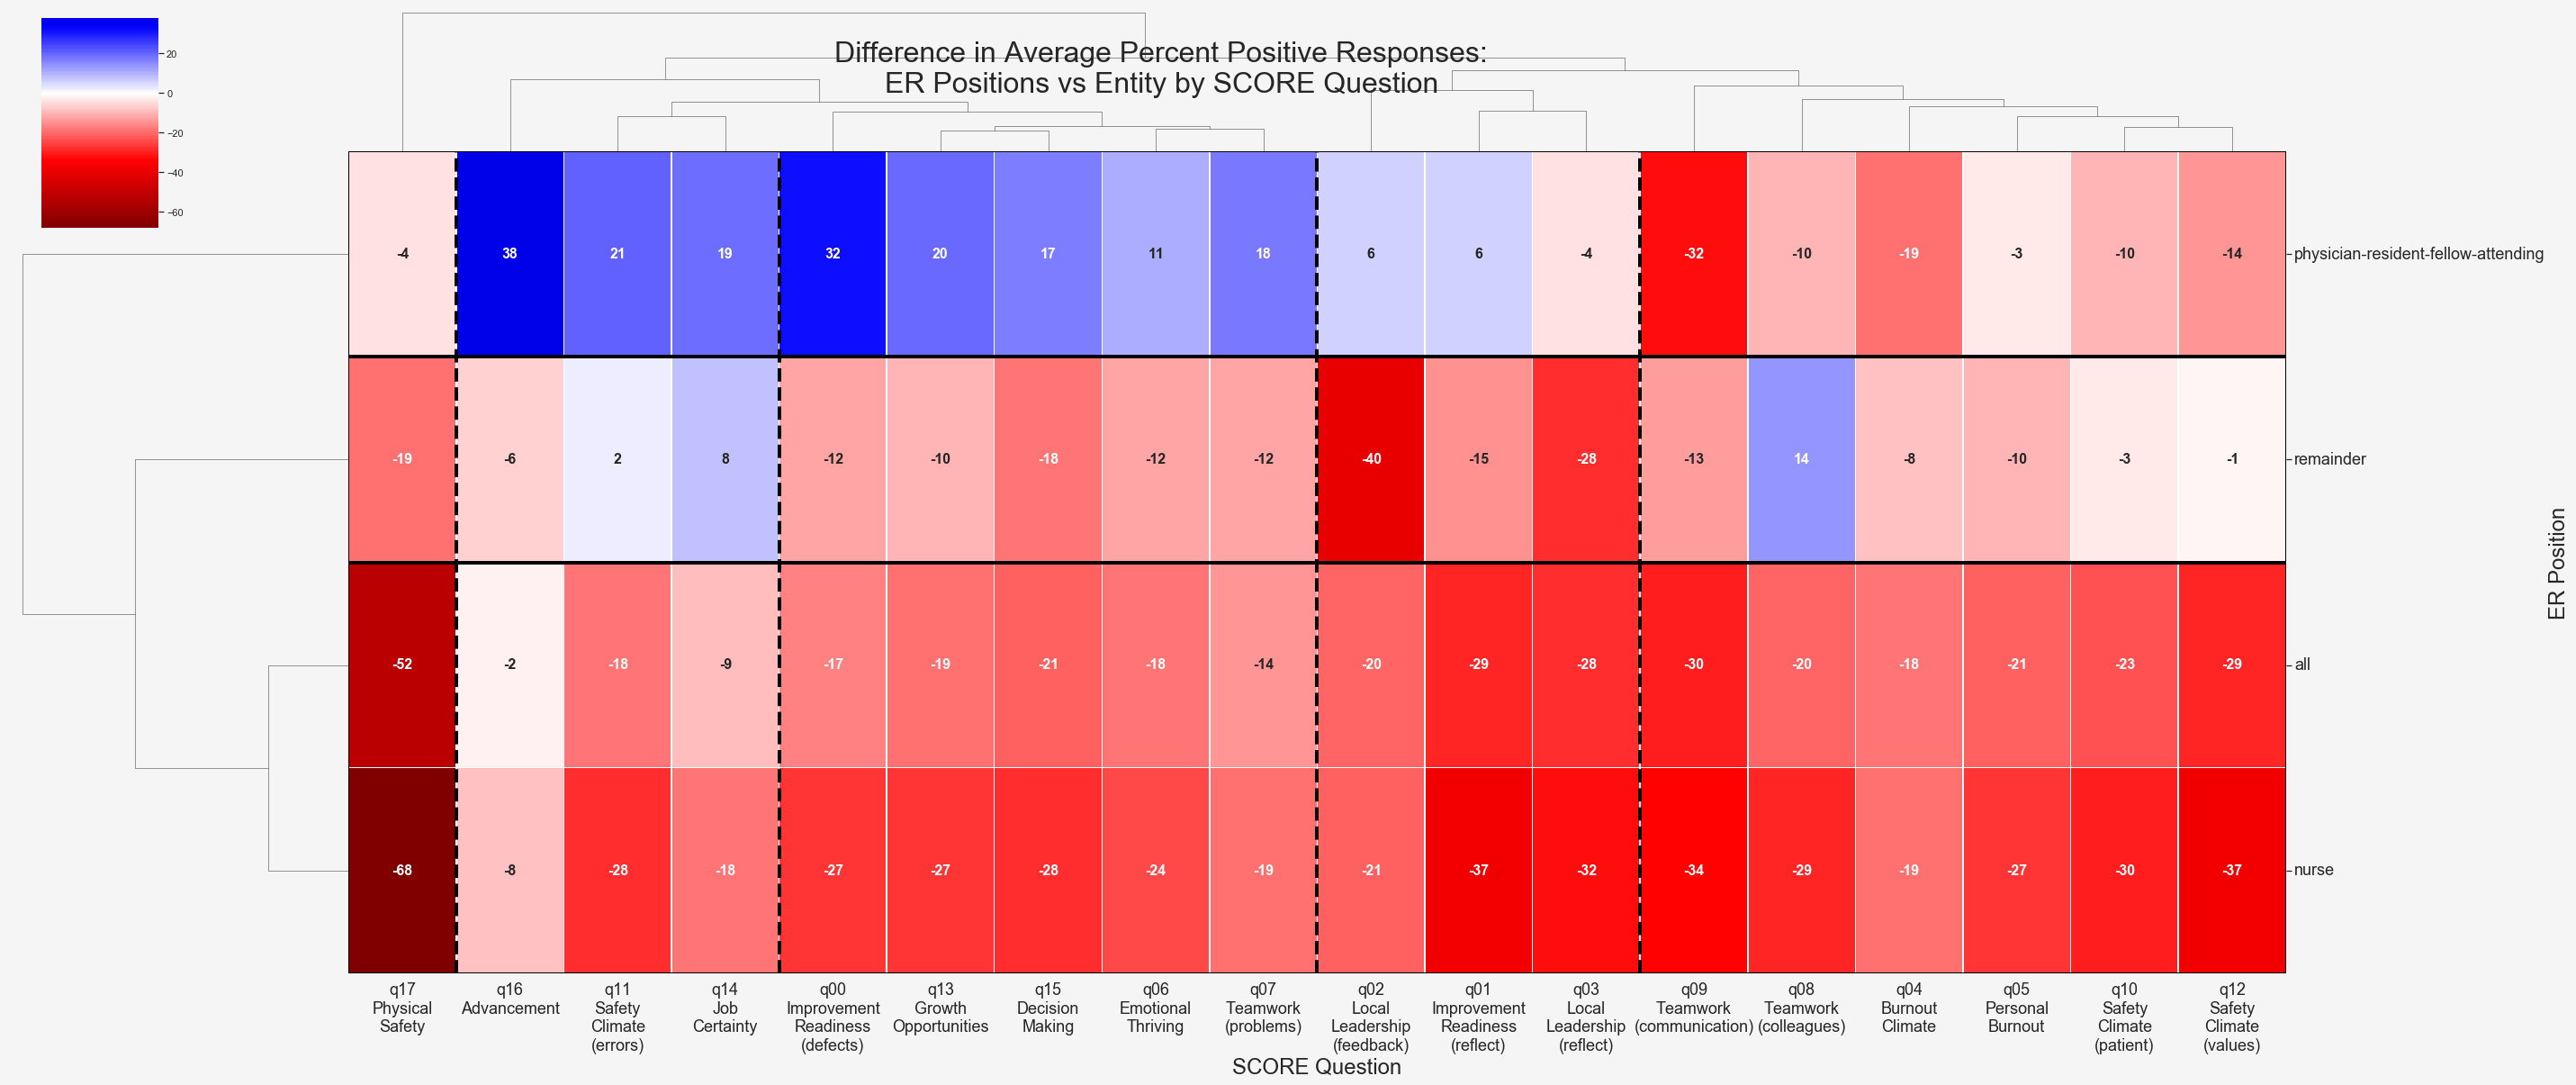

In [75]:
sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'whitesmoke'})

data = score_er_qid_data_grouped.fillna(0)
a = sns.clustermap(data,figsize=(36,18),annot=True,annot_kws={'fontsize':16,'weight':'bold'},
                   cmap='seismic_r',center=0,dendrogram_ratio=[0.15,0.15],lw=0.5)

#labels
title = 'Difference in Average Percent Positive Responses:\nER Positions vs Entity by SCORE Question'
a.fig.suptitle(title, x=0.5, y=0.96, fontsize=32)
a.ax_heatmap.set_xlabel('SCORE Question', fontsize=24)
a.ax_heatmap.set_ylabel('ER Position', fontsize=24)

# tick labels
xticklabels = ['\n'.join(item.get_text().split()) for item in a.ax_heatmap.get_xticklabels()]
yticklabels = a.ax_heatmap.get_yticklabels()
a.ax_heatmap.set_xticklabels(xticklabels, rotation=0, ha='center', fontsize=18)
a.ax_heatmap.set_yticklabels(yticklabels, rotation=0, va='center', fontsize=18)

# bounding boxes
ax = a.ax_heatmap
ax.add_patch(Rectangle((0, 0), len(data.columns), len(data), fill=False, edgecolor='black', lw=2))
#ax.add_patch(Rectangle((0, 3), len(data.columns), 1, fill=False, edgecolor='black', lw=2))

# TEMP LINES
ax.axhline(1, color='black', lw=4)
ax.axhline(2, color='black', lw=4)

ax.axvline(1, color='black', lw=4, ls='--')
ax.axvline(4, color='black', lw=4, ls='--')
ax.axvline(9, color='black', lw=4, ls='--')
ax.axvline(12, color='black', lw=4, ls='--')

#save_figure(a.fig,FIGURE_PATH,'score_er_qid_pct_pos_')

### ER Work Setting: Question Category and Question ID - Relative Comparison
* Comparison of ER positions - nurses, physaicians, remainder - relative to the ER setting, rather than the entire entity

In [76]:
temp_er_qc_pct_pos = score_er_qc_data[score_er_qc_data['position']=='all'][['question_id','group_pct_pos']].copy()
temp_er_qc_pct_pos = temp_er_qc_pct_pos.rename(columns={'group_pct_pos':'er_pct_pos'})
score_er_qc_rel_data = score_er_qc_data.merge(temp_er_qc_pct_pos, how='inner', on='question_id')
score_er_qc_rel_data['group_er_pct_pos_diff']=score_er_qc_rel_data['group_pct_pos']-score_er_qc_rel_data['er_pct_pos']
score_er_qc_rel_data_grouped = score_er_qc_rel_data.groupby(['position','question_category']).mean()['group_er_pct_pos_diff'].unstack()

temp_er_qid_pct_pos = score_er_qc_data[score_er_qc_data['position']=='all'][['question_id','group_pct_pos']].copy()
temp_er_qid_pct_pos = temp_er_qid_pct_pos.rename(columns={'group_pct_pos':'er_pct_pos'})
score_er_qid_rel_data = score_er_qc_data.merge(temp_er_qid_pct_pos, how='inner', on='question_id')
score_er_qid_rel_data['group_er_pct_pos_diff']=score_er_qid_rel_data['group_pct_pos']-score_er_qid_rel_data['er_pct_pos']
score_er_qid_rel_data_grouped = score_er_qid_rel_data.groupby(['position','question_id']).mean()['group_er_pct_pos_diff'].unstack()
score_er_qid_rel_data_grouped.columns = [col+' '+qid_cat_label_dict[col] for col in score_er_qid_rel_data_grouped.columns]

In [77]:
print(len(score_er_qc_rel_data_grouped))
print(len(score_er_qc_rel_data_grouped.columns))
score_er_qc_rel_data_grouped.head()

4
12


question_category                    Advancement  Burnout Climate  \
position                                                            
all                                          0.0              0.0   
nurse                                       -6.0             -1.0   
physician-resident-fellow-attending         40.0             -1.0   
remainder                                   -4.0             10.0   

question_category                    Decision Making  Emotional Thriving  \
position                                                                   
all                                              0.0                 0.0   
nurse                                           -7.0                -6.0   
physician-resident-fellow-attending             38.0                29.0   
remainder                                        3.0                 6.0   

question_category                    Growth Opportunities  \
position                                                    
all                                                   0.0   
nurse                                                -8.0   
physician-resident-fellow-attending                  39.0   
remainder                                             9.0   

question_category                    Improvement Readiness  Job Certainty  \
position                                                                    
all                                                    0.0            0.0   
nurse                                                 -9.0           -9.0   
physician-resident-fellow-attending                   42.0           28.0   
remainder                                              9.5           17.0   

question_category                    Local Leadership  Personal Burnout  \
position                                                                  
all                                               0.0               0.0   
nurse                                            -2.5              -6.0   
physician-resident-fellow-attending              25.0              18.0   
remainder                                       -10.0              11.0   

question_category                    Physical Safety  Safety Climate  Teamwork  
position                                                                        
all                                              0.0          0.0000    0.0000  
nurse                                          -16.0         -8.3333   -6.0000  
physician-resident-fellow-attending             48.0         22.3333   13.3333  
remainder                                       33.0         22.6667   17.6667

In [78]:
print(len(score_er_qid_rel_data_grouped))
print(len(score_er_qid_rel_data_grouped.columns))
score_er_qid_rel_data_grouped.head()

4
18


q00 Improvement Readiness (defects)  \
position                                                                   
all                                                                  0.0   
nurse                                                              -10.0   
physician-resident-fellow-attending                                 49.0   
remainder                                                            5.0   

                                     q01 Improvement Readiness (reflect)  \
position                                                                   
all                                                                  0.0   
nurse                                                               -8.0   
physician-resident-fellow-attending                                 35.0   
remainder                                                           14.0   

                                     q02 Local Leadership (feedback)  \
position                                                               
all                                                              0.0   
nurse                                                           -1.0   
physician-resident-fellow-attending                             26.0   
remainder                                                      -20.0   

                                     q03 Local Leadership (reflect)  \
position                                                              
all                                                             0.0   
nurse                                                          -4.0   
physician-resident-fellow-attending                            24.0   
remainder                                                       0.0   

                                     q04 Burnout Climate  \
position                                                   
all                                                  0.0   
nurse                                               -1.0   
physician-resident-fellow-attending                 -1.0   
remainder                                           10.0   

                                     q05 Personal Burnout  \
position                                                    
all                                                   0.0   
nurse                                                -6.0   
physician-resident-fellow-attending                  18.0   
remainder                                            11.0   

                                     q06 Emotional Thriving  \
position                                                      
all                                                     0.0   
nurse                                                  -6.0   
physician-resident-fellow-attending                    29.0   
remainder                                               6.0   

                                     q07 Teamwork (problems)  \
position                                                       
all                                                      0.0   
nurse                                                   -5.0   
physician-resident-fellow-attending                     32.0   
remainder                                                2.0   

                                     q08 Teamwork (colleagues)  \
position                                                         
all                                                        0.0   
nurse                                                     -9.0   
physician-resident-fellow-attending                       10.0   
remainder                                                 34.0   

                                     q09 Teamwork (communication)  \
position                                                            
all                                                           0.0   
nurse                                                        -4.0   
physician-resident-fellow-attending                          -2.0   
remainder                    

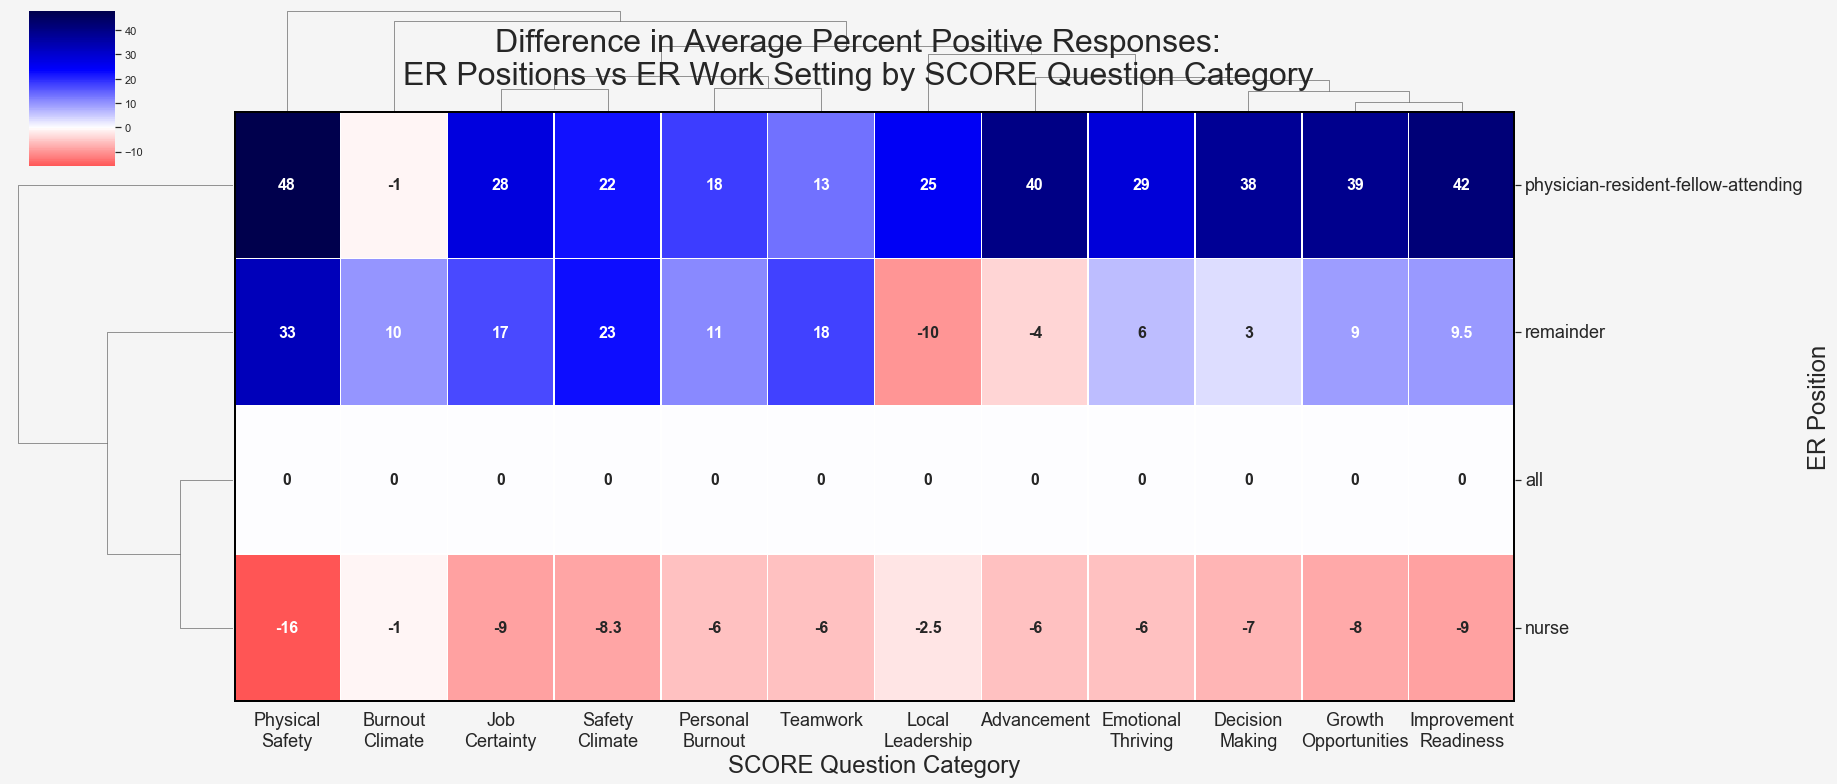

In [79]:
sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'whitesmoke'})

data = score_er_qc_rel_data_grouped.fillna(0)
a = sns.clustermap(data,figsize=(24,12),annot=True,annot_kws={'fontsize':16,'weight':'bold'},
                   cmap='seismic_r',center=0,dendrogram_ratio=[0.15,0.15],lw=0.5)

#labels
title ='Difference in Average Percent Positive Responses:\nER Positions vs ER Work Setting by SCORE Question Category'
a.fig.suptitle(title, x=0.5, y=0.96, fontsize=32)
a.ax_heatmap.set_xlabel('SCORE Question Category', fontsize=24)
a.ax_heatmap.set_ylabel('ER Position', fontsize=24)

# tick labels
xticklabels = ['\n'.join(item.get_text().split()) for item in a.ax_heatmap.get_xticklabels()]
yticklabels = a.ax_heatmap.get_yticklabels()
a.ax_heatmap.set_xticklabels(xticklabels, rotation=0, ha='center', fontsize=18)
a.ax_heatmap.set_yticklabels(yticklabels, rotation=0, va='center', fontsize=18)

# bounding boxes
ax = a.ax_heatmap
ax.add_patch(Rectangle((0, 0), len(data.columns), len(data), fill=False, edgecolor='black', lw=4))
#ax.add_patch(Rectangle((0, 3), len(data.columns), 1, fill=False, edgecolor='black', lw=2))

#save_figure(a.fig,FIGURE_PATH,'score_er_qc_rel_pct_pos_')

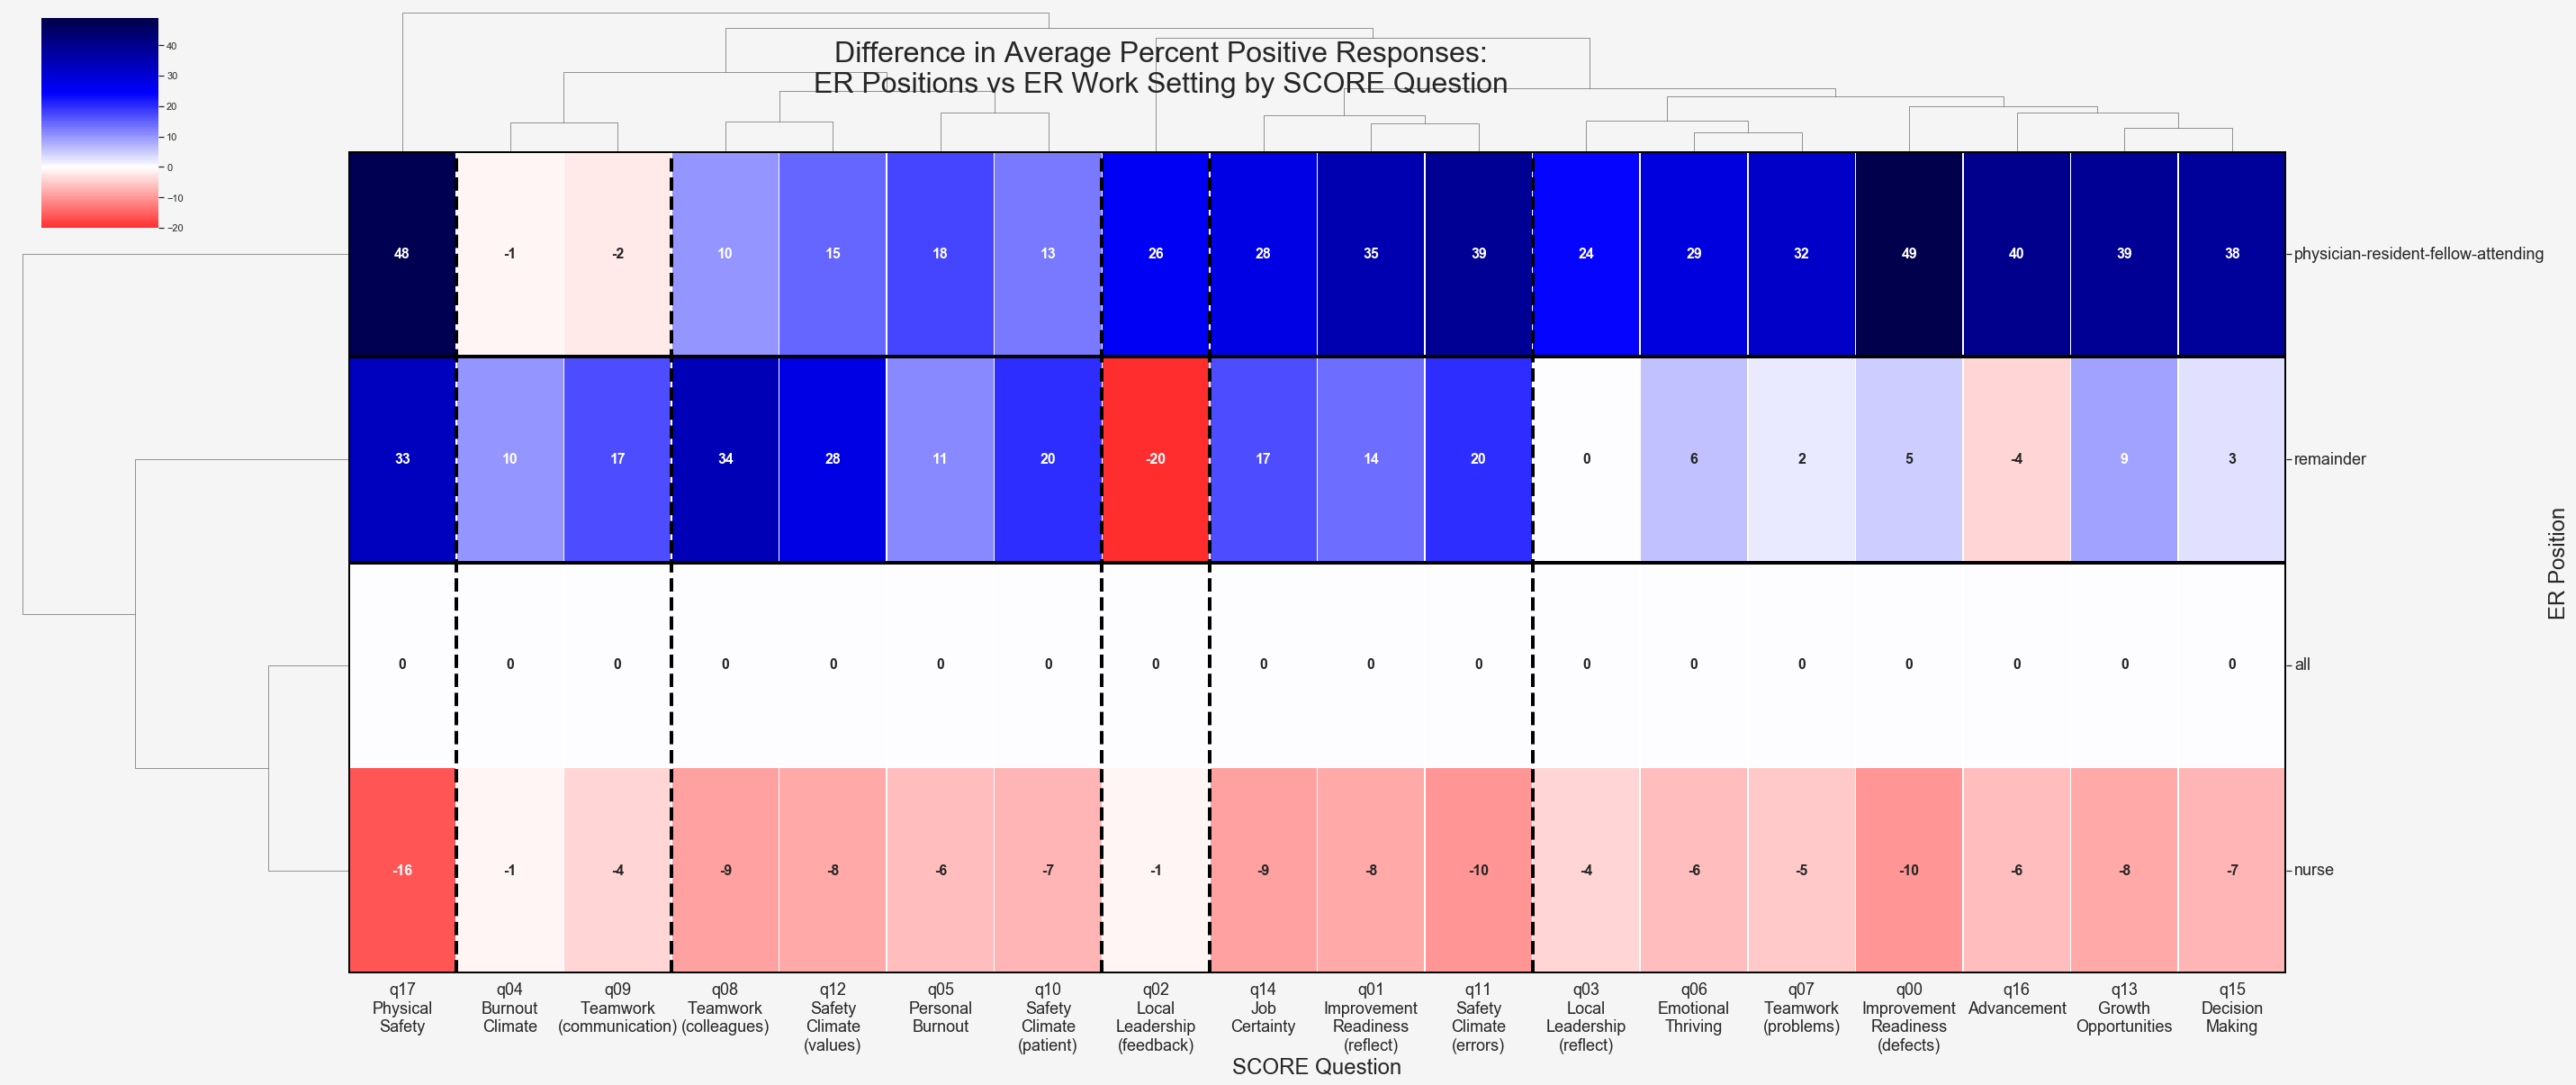

In [80]:
sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'whitesmoke'})

data = score_er_qid_rel_data_grouped.fillna(0)
a = sns.clustermap(data,figsize=(36,18),annot=True,annot_kws={'fontsize':16,'weight':'bold'},
                   cmap='seismic_r',center=0,dendrogram_ratio=[0.15,0.15],lw=0.5)

#labels
title = 'Difference in Average Percent Positive Responses:\nER Positions vs ER Work Setting by SCORE Question'
a.fig.suptitle(title, x=0.5, y=0.96, fontsize=32)
a.ax_heatmap.set_xlabel('SCORE Question', fontsize=24)
a.ax_heatmap.set_ylabel('ER Position', fontsize=24)

# tick labels
xticklabels = ['\n'.join(item.get_text().split()) for item in a.ax_heatmap.get_xticklabels()]
yticklabels = a.ax_heatmap.get_yticklabels()
a.ax_heatmap.set_xticklabels(xticklabels, rotation=0, ha='center', fontsize=18)
a.ax_heatmap.set_yticklabels(yticklabels, rotation=0, va='center', fontsize=18)

# bounding boxes
ax = a.ax_heatmap
ax.add_patch(Rectangle((0, 0), len(data.columns), len(data), fill=False, edgecolor='black', lw=4))
#ax.add_patch(Rectangle((0, 3), len(data.columns), 1, fill=False, edgecolor='black', lw=2))

# TEMP LINES
ax.axhline(1, color='black', lw=4)
ax.axhline(2, color='black', lw=4)

ax.axvline(1, color='black', lw=4, ls='--')
ax.axvline(3, color='black', lw=4, ls='--')
ax.axvline(7, color='black', lw=4, ls='--')
ax.axvline(8, color='black', lw=4, ls='--')
ax.axvline(11, color='black', lw=4, ls='--')

#save_figure(a.fig,FIGURE_PATH,'score_er_qid_rel_pct_pos_')

## End Validated Output

# Unused / Deprecated Code

In [ ]:
"""

# File paths
PPMC_path = SCORE_SURVEY_PATH + 'score_PPMC_20201201.pdf'
ER_path = SCORE_SURVEY_PATH + 'score_PPMC_ER_20201201.pdf'
nurse_path = SCORE_SURVEY_PATH + 'score_PPMC_ER_nurse_20201201.pdf'
physician_path = SCORE_SURVEY_PATH + 'score_PPMC_ER_physician_20201201.pdf'
overall_path = SCORE_SURVEY_PATH + 'score_PPMC_overall_20201201.pdf'


# Main data structure
data_dict = {
    'PPMC':{
        'path':PPMC_path,
        'raw_data':[],
        'master_data':[]
    },
    'ER':{
        'path':ER_path,
        'raw_data':[],
        'master_data':[]
    },
    'nurse':{
        'path':nurse_path,
        'raw_data':[],
        'master_data':[]
    },
    'physician':{
        'path':physician_path,
        'raw_data':[],
        'master_data':[]
    },
    'overall':{
        'path':overall_path,
        'raw_data':[],
        'master_data':[]
    }
}

"""

In [ ]:
"""

a = sns.clustermap(score_ws_qc_data_grouped.fillna(0),figsize=(18,18),annot=True,cmap='seismic_r',center=0)

save_figure(a.fig,FIGURE_PATH,'score_ws_qc_pct_pos_simple_')

"""

In [ ]:
"""

for item in yticklabels:
    text = item.get_text()
    word_list = text.split('-')
    label = ' '.join([word.capitalize() for word in word_list]) + ' (' + str(ws_respondents_dict[text]) + ')'
    item.set_text(label)
    if not set(word_list).isdisjoint(leadership_keywords):
        item.set_fontweight('bold')

"""